# Exercise 2 - Deep Neural Networks

## Group *ID* : $2207$

### Members

- Pietro Cappelli
    - e-mail: pietro.cappelli@studenti.unipd.it
    - ID: 2058332
- Alberto Coppi
    - e-mail: alberto.coppi@studenti.unipd.it
    - ID: 2053063
- Giacomo Franceschetto
    - e-mail: giacomo.franceschetto@studenti.unipd.it
    - ID: 2053348
- Nicolò Lai
    - e-mail: nicolo.lai@studenti.unipd.it
    - ID: 2064377 
### Author contribution statement

Each and every member of the group equally worked on the assigned project and the drafting of this notebook. 

---

## Import modules and custom libraries

In [ ]:
import tensorflow         as tf
import numpy              as np
import matplotlib.pyplot  as plt
import matplotlib.patches as mpatches
import seaborn            as sns

from sklearn.model_selection     import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics             import confusion_matrix

import time
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=UserWarning) 


import _2207_nn_model    as nn_model
import _2207_create_data as create_data
import _2207_preprocess  as preprocess
import _2207_plot_utils  as plot_utils
import _2207_gridsearch  as gridsearch

## 0 - Generate data <a name="first"></a>

Let us first introduce data, namely how we generate it and how we label it. 

We uniformly sample $N=5000$ examples $x \in [-50,\,+50] \times [-50,\,+50] \equiv \mathcal{D}$. Then we apply the following labeling function:

$$
    f(x) = 
    \begin{cases}
    1 & \text{if} & x_1 > -20 \,\land\, x_2 > -40 \,\land\, x_1+x_2 < 40 \\
    0 && \text{otherwise}
    \end{cases}
$$

We show here a figure in which data is plotted and color-coded with its label. On top of that, we also show labeling boundaries (in orange) to better visualize the underlying labeling criterion.

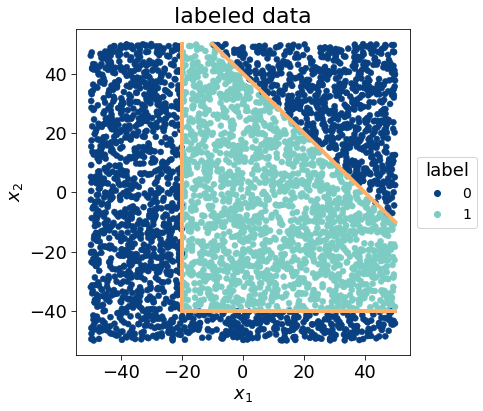

In [ ]:
# number of data
N = 4000
# box size
B = 100

# random seed for reproducibility
np.random.seed(20220308)

x, y_true = create_data.create_data(N, B, c="triang")

fig = plt.figure(figsize=(6,6))
ax  = plot_utils.plot_labeled_data(
    x               = x, 
    labels          = y_true, 
    fig             = fig, 
    title           = "labeled data", 
    palette         = "GnBu_r",
    hue_norm        = (0, 2),
    fontsize        = 18, 
    show_boundaries = True
)

plt.show()

## 1 - Study the performance of the DNN when the number N of samples is
### a) reduced
### b) increased 
### c) augmented

### 1a) reduced

Let us begin with evaluating the neural network performance as a function of the input dataset size. First, we study the case in which the input dataset has lower size than the "standard" $N=4000$.

#### Neural network model

We take the optimized model we found when tackling the second task of this exercise sheet, that is the one that follows.

In [ ]:
#first of all let's define the best model of the NN
n_features = x.shape[1]

# NN hyperparameters
architecture      = [n_features, 20, 20, 1]
dropout_arc       = [1]
dropout_rates     = [0.3]
batch_norm_arc    = None
input_dim         = architecture[0]
hidden_activation = "softsign"
output_activation = "sigmoid"
name              = "neural network - optimized"

# build the NN model
network = nn_model.NN(
    input_dim         = input_dim,
    architecture      = architecture,
    dropout_layers    = dropout_arc,
    dropout_rates     = dropout_rates,
    batch_norm_layers = batch_norm_arc,
    hidden_activation = hidden_activation,
    output_activation = output_activation,
    nn_name           = name,
)

# print summary
network.summary()

# compile NN with loss, optimizer and metrics
loss      = "binary_crossentropy"
optimizer = "adam"
metrics   = ["accuracy"]


Model: "neural network - optimized"
____________________________________________________________________________________________________
 Layer (type)                                Output Shape                            Param #        
 input_layer (InputLayer)                    [(None, 2)]                             0              
                                                                                                    
 hidden_0 (Dense)                            (None, 20)                              60             
                                                                                                    
 dropout_0 (Dropout)                         (None, 20)                              0              
                                                                                                    
 hidden_1 (Dense)                            (None, 20)                              420            
                                                       

#### Training, validation and test sets

Then we generate our input datasets, changing the number of instances we sample. We split each dataset into *training*, *validation* and *test* set according to the two ratios at the beginning of the following cell. 

In [ ]:
reduction_rates  = [0.2, 0.4, 0.6, 0.8, 1.0]
train_test_frac  = 0.7
valid_train_frac = 0.3 


training_set      = []
training_labels   = []
test_set          = []
test_labels       = []
validation_set    = []
validation_labels = []


for i, red_rate in enumerate(reduction_rates):

    # compute the appropriate total number of examples
    Ni = N * red_rate

    # split into training validation and test set
    N_train = int(Ni*train_test_frac*(1-valid_train_frac))
    N_valid = int(Ni*train_test_frac*valid_train_frac)
    N_test  = int(Ni*(1-train_test_frac))

    train_idx = N_train
    valid_idx = N_train + N_valid
    test_idx  = N_train + N_valid + N_test

    data_split = {
        "training_set"   : N_train,
        "test_set"       : N_test,
        "validation_set" : N_valid
    }

    print("="*30, "\n")
    print("Reduction rate", red_rate)
    for key, val in data_split.items():
        print(f"{key} \t N = {val}")
    print("\n", "="*30, "\n")
    x_, y_true_ = create_data.create_data(int(Ni), B, c="triang")

    # rescale data 
    mean = np.mean(x, axis=0)
    std = np.std(x, axis=0)
    x_ = preprocess.standardize(x_, mean, std)

    training_set.append(x_[0:train_idx])
    training_labels.append(y_true_[0:train_idx])
    validation_set.append(x_[train_idx:valid_idx])
    validation_labels.append(y_true_[train_idx:valid_idx])
    test_set.append(x_[valid_idx:test_idx])
    test_labels.append(y_true_[valid_idx:test_idx])


Reduction rate 0.2
training_set 	 N = 392
test_set 	 N = 240
validation_set 	 N = 168



Reduction rate 0.4
training_set 	 N = 784
test_set 	 N = 480
validation_set 	 N = 336



Reduction rate 0.6
training_set 	 N = 1176
test_set 	 N = 720
validation_set 	 N = 504



Reduction rate 0.8
training_set 	 N = 1568
test_set 	 N = 960
validation_set 	 N = 672



Reduction rate 1.0
training_set 	 N = 1959
test_set 	 N = 1200
validation_set 	 N = 840




#### Neural network training

For each dataset we have created, we fit the neural network using training datasets and evaluate the performance run-time using validation datasets. At the end of the training, we further evaluate the performance of the network on test sets.  

In [ ]:
minibatch = 50
N_epochs  = 300

networks     = []
fit_results  = []
test_results = []

for i in range(len(reduction_rates)):

    name = f"reduction rate {reduction_rates[i]}"

    network = nn_model.create_model(
        input_dim         = input_dim,
        architecture      = architecture,
        dropout_layers    = dropout_arc,
        dropout_rates     = dropout_rates,
        batch_norm_layers = batch_norm_arc,
        hidden_activation = hidden_activation,
        output_activation = output_activation,
        loss              = loss,
        optimizer         = optimizer,
        metrics           = metrics,
        nn_name           = name,
    )

    # network.summary()

    t0 = time.time()
    fit = network.fit(
        training_set[i], training_labels[i],
        epochs          = N_epochs,
        batch_size      = minibatch,
        validation_data = (validation_set[i], validation_labels[i]),
        verbose         = 0,
    )
    t1 = time.time()

    test = network.evaluate(
        test_set[i], test_labels[i],
        batch_size      = minibatch,
        verbose         = 0,
    )

    
    print("="*30)
    print(f"\nreduction rate {reduction_rates[i]} training : {t1-t0:.2f} seconds")

    print(f"\ntraining loss     : {fit.history['loss'][-1]:.5f}")
    print(f"training accuracy : {fit.history['accuracy'][-1]:.5f}")

    print(f"\nvalid loss        : {fit.history['val_loss'][-1]:.5f}")
    print(f"valid accuracy    : {fit.history['val_accuracy'][-1]:.5f}\n")

    print(f"\nreduction rate {reduction_rates[i]} testing")

    print(f"\ntest loss         : {test[0]:.5f}")
    print(f"test accuracy     : {test[1]:.5f}\n")

    print("="*30)

    networks.append(network)
    fit_results.append(fit)
    test_results.append(test)


reduction rate 0.2 training : 14.75 seconds

training loss     : 0.19019
training accuracy : 0.93622

valid loss        : 0.19208
valid accuracy    : 0.92262


reduction rate 0.2 testing

test loss         : 0.21780
test accuracy     : 0.90417


reduction rate 0.4 training : 20.97 seconds

training loss     : 0.08259
training accuracy : 0.98214

valid loss        : 0.05921
valid accuracy    : 0.98810


reduction rate 0.4 testing

test loss         : 0.07851
test accuracy     : 0.97500


reduction rate 0.6 training : 23.42 seconds

training loss     : 0.02898
training accuracy : 1.00000

valid loss        : 0.02875
valid accuracy    : 0.99206


reduction rate 0.6 testing

test loss         : 0.02605
test accuracy     : 0.99444


reduction rate 0.8 training : 41.49 seconds

training loss     : 0.02725
training accuracy : 0.99362

valid loss        : 0.02114
valid accuracy    : 0.99405


reduction rate 0.8 testing

test loss         : 0.01608
test accuracy     : 0.99687


reduction rate 

#### Performance visualization

Note that here and in the following plots, marker size is related to accuracy when we scatter final loss value, and is related to final loss value when we scatter accuracy vs sample size. This will hold until the end of the notebook.

In [ ]:
red_training_loss = []
red_training_acc  = []
red_valid_loss    = []
red_valid_acc     = []
red_test_loss     = []
red_test_acc      = []

for i in range(len(reduction_rates)):
    red_training_loss.append(fit_results[i].history["loss"])
    red_training_acc.append(fit_results[i].history["accuracy"])
    red_valid_loss.append(fit_results[i].history["val_loss"])
    red_valid_acc.append(fit_results[i].history["val_accuracy"])
    red_test_loss.append(test_results[i][0])
    red_test_acc.append(test_results[i][1])

final_red_training_loss = [x[-1] for x in red_training_loss]
final_red_valid_loss    = [x[-1] for x in red_valid_loss]
final_red_test_loss     = [x     for x in red_test_loss]

final_red_training_acc = [x[-1] for x in red_training_acc]
final_red_valid_acc    = [x[-1] for x in red_valid_acc]
final_red_test_acc     = [x     for x in red_test_acc]

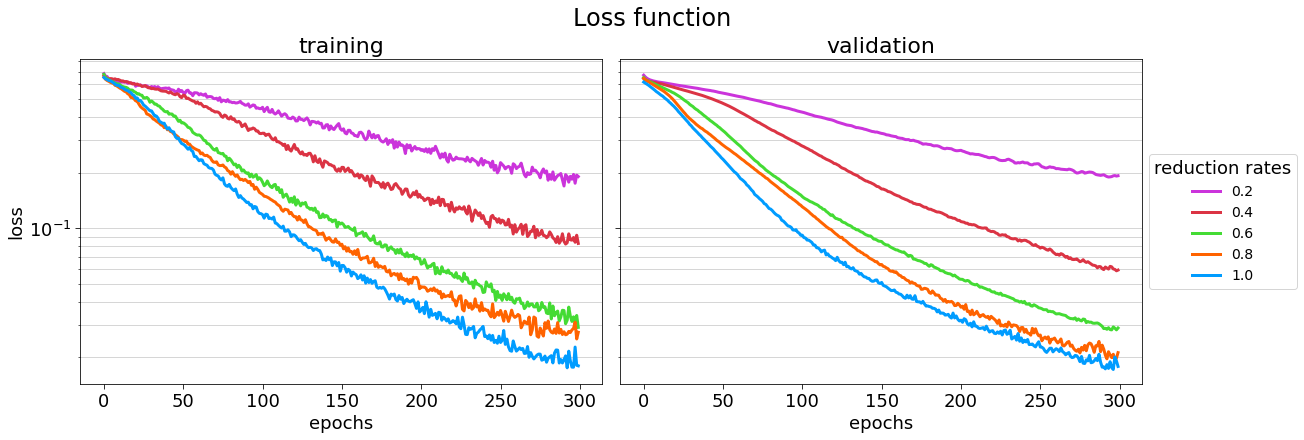

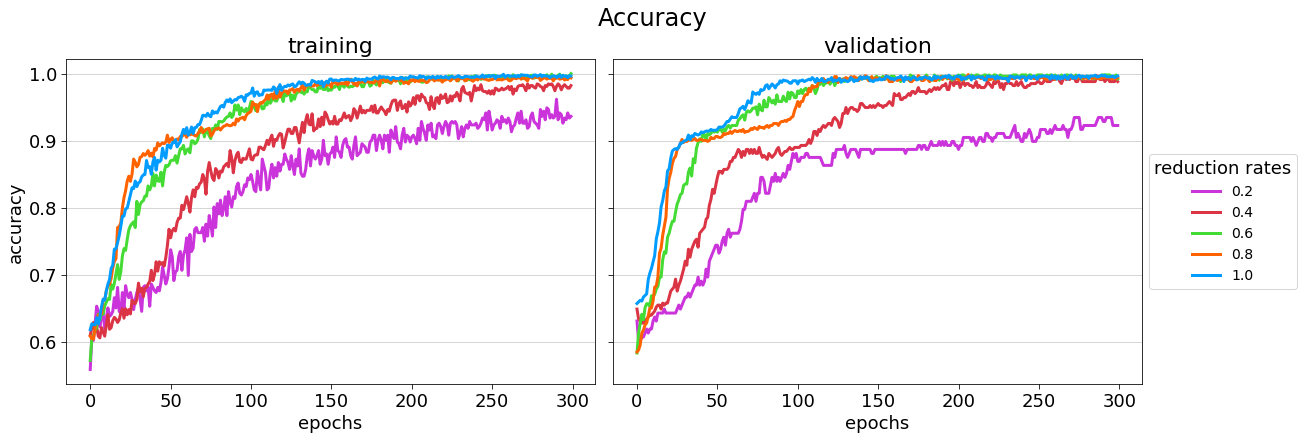

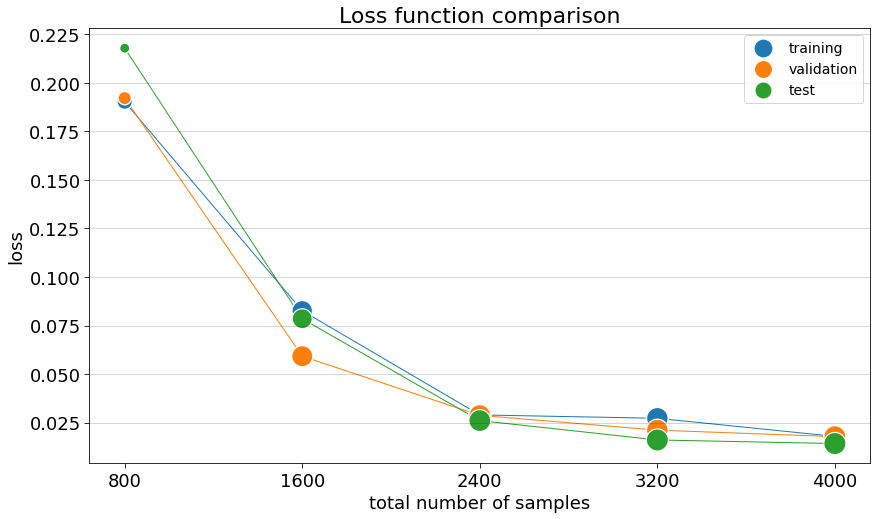

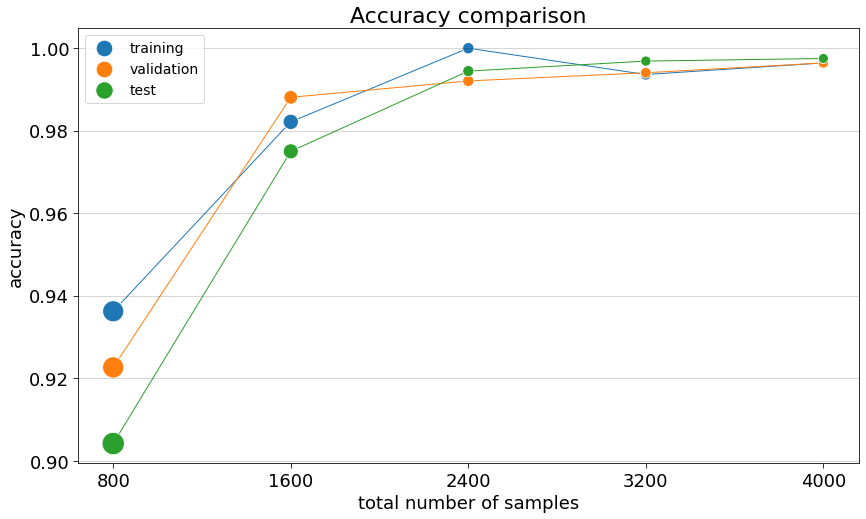

In [ ]:
palette = {
    1.0 : ["#009cff"],
    0.8 : ["#ff6300"],#44db34
    0.6 : ["#44db34"],#db3444
    0.4 : ["#db3444"],#ff6300
    0.2 : ["#cb34db"],
}

Ntot = [N*rate for rate in reduction_rates]

fig, (ax1, ax2) = plt.subplots(
    nrows              = 1, 
    ncols              = 2, 
    sharex             = "all", 
    sharey             = "all",
    figsize            = (18,6), 
    constrained_layout = True
)
fig.suptitle("Loss function", fontsize=24)

ax1.grid(axis="y", color="k", alpha=0.2, which="both")
ax2.grid(axis="y", color="k", alpha=0.2, which="both")

for i in range(len(reduction_rates)):

    ax1 = plot_utils.plot_loss(
        epochs     = N_epochs,
        loss       = red_training_loss[i],
        fig        = fig,
        ax         = ax1,
        color      = palette[reduction_rates[i]][0],
        loss_label = "loss",
        title      = "training",
        label      = f"{reduction_rates[i]}",
        legend     = False
    )
    ax2 = plot_utils.plot_loss(
        epochs     = N_epochs,
        loss       = red_valid_loss[i],
        fig        = fig,
        ax         = ax2,
        color      = palette[reduction_rates[i]][0],
        title      = "validation",
        label      = f"{reduction_rates[i]}",
        legend     = False
    )

ax1.set_yscale("log")

ax2.legend(title="reduction rates", title_fontsize=18, loc="center left", bbox_to_anchor=(1, 0.5), fontsize=14)

plt.show()


## ====================================================##


fig, (ax1, ax2) = plt.subplots(
    nrows              = 1, 
    ncols              = 2, 
    sharex             = "all", 
    sharey             = "all",
    figsize            = (18,6), 
    constrained_layout = True
)
fig.suptitle("Accuracy", fontsize=24)

ax1.grid(axis="y", color="k", alpha=0.2)
ax2.grid(axis="y", color="k", alpha=0.2)

for i in range(len(reduction_rates)):

    ax1 = plot_utils.plot_metric(
        epochs       = N_epochs,
        metric       = red_training_acc[i],
        fig          = fig,
        ax           = ax1,
        color        = palette[reduction_rates[i]][0],
        metric_label = "accuracy",
        title        = "training",
        label        = f"{reduction_rates[i]}",
        legend       = False
    )
    ax2 = plot_utils.plot_metric(
        epochs       = N_epochs,
        metric       = red_valid_acc[i],
        fig          = fig,
        ax           = ax2,
        color        = palette[reduction_rates[i]][0],
        title        = "validation",
        label        = f"{reduction_rates[i]}",
        legend       = False
    )

ax1.set_yscale("linear")

ax2.legend(title="reduction rates", title_fontsize=18, loc="center left", bbox_to_anchor=(1, 0.5), fontsize=14)

plt.show()

## ====================================================##



loss_max = max(
    final_red_training_loss + 
    final_red_valid_loss    +
    final_red_test_loss     
)
loss_min = min(
    final_red_training_loss + 
    final_red_valid_loss    +
    final_red_test_loss 
)
acc_max  = max(
    final_red_training_acc + 
    final_red_valid_acc    +
    final_red_test_acc
)
acc_min  = min(
    final_red_training_acc + 
    final_red_valid_acc    +
    final_red_test_acc
)

loss_norm = (loss_min, loss_max)
acc_norm  = (acc_min,  acc_max)



fig, ax = plt.subplots(figsize=(14,8))

ax.grid(axis="y", color="k", alpha=0.2)

ax.set_title("Loss function", fontsize=22)

ax = plot_utils.scatter_results(
    parameter    = Ntot,
    result       = final_red_training_loss,
    fig          = fig, 
    ax           = ax,
    label        = "training",
    metric_label = "loss",
    par_label    = "total number of samples",
    color        = "tab:blue",
    ms           = final_red_training_acc,
    mnorm        = acc_norm,
    fontsize     = 18,
    legend       = True,
    title        = "Loss function comparison"
)

ax = plot_utils.scatter_results(
    parameter    = Ntot,
    result       = final_red_valid_loss,
    fig          = fig, 
    ax           = ax,
    label        = "validation",
    metric_label = "loss",
    par_label    = "total number of samples",
    color        = "tab:orange",
    ms           = final_red_valid_acc,
    mnorm        = acc_norm,
    fontsize     = 18,
    legend       = True,
    title        = "Loss function comparison"
)

ax = plot_utils.scatter_results(
    parameter    = Ntot,
    result       = final_red_test_loss,
    fig          = fig, 
    ax           = ax,
    label        = "test",
    metric_label = "loss",
    par_label    = "total number of samples",
    color        = "tab:green",
    ms           = final_red_test_acc,
    mnorm        = acc_norm,
    fontsize     = 18,
    legend       = True,
    title        = "Loss function comparison"
)

ax.set_yscale("linear")

ax.set_xticks(Ntot)

plt.show()


fig, ax = plt.subplots(figsize=(14,8))

ax.grid(axis="y", color="k", alpha=0.2)

ax.set_title("Accuracy", fontsize=22)

ax = plot_utils.scatter_results(
    parameter    = Ntot,
    result       = final_red_training_acc,
    fig          = fig, 
    ax           = ax,
    label        = "training",
    metric_label = "accuracy",
    par_label    = "total number of samples",
    color        = "tab:blue",
    ms           = final_red_training_loss,
    mnorm        = loss_norm,
    fontsize     = 18,
    legend       = True,
    title        = "Accuracy comparison"
)

ax = plot_utils.scatter_results(
    parameter    = Ntot,
    result       = final_red_valid_acc,
    fig          = fig, 
    ax           = ax,
    label        = "validation",
    metric_label = "accuracy",
    par_label    = "total number of samples",
    color        = "tab:orange",
    ms           = final_red_valid_loss,
    mnorm        = loss_norm,
    fontsize     = 18,
    legend       = True,
    title        = "Accuracy comparison"
)

ax = plot_utils.scatter_results(
    parameter    = Ntot,
    result       = final_red_test_acc,
    fig          = fig, 
    ax           = ax,
    label        = "test",
    metric_label = "accuracy",
    par_label    = "total number of samples",
    color        = "tab:green",
    ms           = final_red_test_loss,
    mnorm        = loss_norm,
    fontsize     = 18,
    legend       = True,
    title        = "Accuracy comparison"
)

ax.set_yscale("linear")

ax.set_xticks(Ntot)

plt.show()

The figures above clearly show that as the number of samples N decreases, the accuracy gets lower. This happens because the network struggle to learn the underlying pattern if it does not have enough data to fit. 

### 1b) increased

Here we replicate the same procedure shown in 1a). Instead of decreasing the number of samples in our datasets, we here increase them to check whether we get any improvement in the overall network performance if we feed it with more data.

#### Training, validation and test sets

In [ ]:
increase_rates  = [1.2, 1.5, 1.8, 2.0, 2.5]
train_test_frac  = 0.7
valid_train_frac = 0.3 


training_set      = []
training_labels   = []
test_set          = []
test_labels       = []
validation_set    = []
validation_labels = []


for i, inc_rate in enumerate(increase_rates):

    # compute the appropriate total number of examples
    Ni = N * inc_rate

    # split into training validation and test set
    N_train = int(Ni*train_test_frac*(1-valid_train_frac))
    N_valid = int(Ni*train_test_frac*valid_train_frac)
    N_test  = int(Ni*(1-train_test_frac))

    train_idx = N_train
    valid_idx = N_train + N_valid
    test_idx  = N_train + N_valid + N_test

    data_split = {
        "training_set"   : N_train,
        "test_set"       : N_test,
        "validation_set" : N_valid
    }

    print("="*30, "\n")
    print("Increase rate", inc_rate)
    for key, val in data_split.items():
        print(f"{key} \t N = {val}")
    print("\n", "="*30, "\n")
    x_, y_true_ = create_data.create_data(int(Ni), B, c="triang")

    # rescale data 
    mean = np.mean(x, axis=0)
    std = np.std(x, axis=0)
    x_ = preprocess.standardize(x_, mean, std)

    training_set.append(x_[0:train_idx])
    training_labels.append(y_true_[0:train_idx])
    validation_set.append(x_[train_idx:valid_idx])
    validation_labels.append(y_true_[train_idx:valid_idx])
    test_set.append(x_[valid_idx:test_idx])
    test_labels.append(y_true_[valid_idx:test_idx])


Increase rate 1.2
training_set 	 N = 2352
test_set 	 N = 1440
validation_set 	 N = 1008



Increase rate 1.5
training_set 	 N = 2940
test_set 	 N = 1800
validation_set 	 N = 1260



Increase rate 1.8
training_set 	 N = 3528
test_set 	 N = 2160
validation_set 	 N = 1512



Increase rate 2.0
training_set 	 N = 3919
test_set 	 N = 2400
validation_set 	 N = 1680



Increase rate 2.5
training_set 	 N = 4900
test_set 	 N = 3000
validation_set 	 N = 2100




#### Neural network training

In [ ]:
minibatch = 50
N_epochs  = 300

networks     = []
fit_results  = []
test_results = []

for i in range(len(increase_rates)):

    name = f"increase rate {increase_rates[i]}"

    network = nn_model.create_model(
        input_dim         = input_dim,
        architecture      = architecture,
        dropout_layers    = dropout_arc,
        dropout_rates     = dropout_rates,
        batch_norm_layers = batch_norm_arc,
        hidden_activation = hidden_activation,
        output_activation = output_activation,
        loss              = loss,
        optimizer         = optimizer,
        metrics           = metrics,
        nn_name           = name,
    )

    # network.summary()

    t0 = time.time()
    fit = network.fit(
        training_set[i], training_labels[i],
        epochs          = N_epochs,
        batch_size      = minibatch,
        validation_data = (validation_set[i], validation_labels[i]),
        verbose         = 0,
    )
    t1 = time.time()

    test = network.evaluate(
        test_set[i], test_labels[i],
        batch_size      = minibatch,
        verbose         = 0,
    )

    
    print("="*30)
    print(f"\nincrease rate {increase_rates[i]} training : {t1-t0:.2f} seconds")

    print(f"\ntraining loss     : {fit.history['loss'][-1]:.5f}")
    print(f"training accuracy : {fit.history['accuracy'][-1]:.5f}")

    print(f"\nvalid loss        : {fit.history['val_loss'][-1]:.5f}")
    print(f"valid accuracy    : {fit.history['val_accuracy'][-1]:.5f}\n")

    print(f"\nincrease rate {increase_rates[i]} testing")

    print(f"\ntest loss         : {test[0]:.5f}")
    print(f"test accuracy     : {test[1]:.5f}\n")

    print("="*30)

    networks.append(network)
    fit_results.append(fit)
    test_results.append(test)


increase rate 1.2 training : 39.57 seconds

training loss     : 0.01924
training accuracy : 0.99575

valid loss        : 0.01404
valid accuracy    : 0.99702


increase rate 1.2 testing

test loss         : 0.01415
test accuracy     : 0.99722


increase rate 1.5 training : 82.43 seconds

training loss     : 0.01198
training accuracy : 0.99660

valid loss        : 0.00626
valid accuracy    : 0.99841


increase rate 1.5 testing

test loss         : 0.00726
test accuracy     : 0.99889


increase rate 1.8 training : 82.41 seconds

training loss     : 0.00921
training accuracy : 0.99660

valid loss        : 0.00890
valid accuracy    : 0.99802


increase rate 1.8 testing

test loss         : 0.00817
test accuracy     : 0.99769


increase rate 2.0 training : 56.62 seconds

training loss     : 0.00821
training accuracy : 0.99719

valid loss        : 0.01081
valid accuracy    : 0.99524


increase rate 2.0 testing

test loss         : 0.01119
test accuracy     : 0.99500


increase rate 2.5 train

#### Neural network performance visualization

In [ ]:
inc_training_loss = []
inc_training_acc  = []
inc_valid_loss    = []
inc_valid_acc     = []
inc_test_loss     = []
inc_test_acc      = []

for i in range(len(reduction_rates)):
    inc_training_loss.append(fit_results[i].history["loss"])
    inc_training_acc.append(fit_results[i].history["accuracy"])
    inc_valid_loss.append(fit_results[i].history["val_loss"])
    inc_valid_acc.append(fit_results[i].history["val_accuracy"])
    inc_test_loss.append(test_results[i][0])
    inc_test_acc.append(test_results[i][1])

final_inc_training_loss = [x[-1] for x in inc_training_loss]
final_inc_valid_loss    = [x[-1] for x in inc_valid_loss]
final_inc_test_loss     = [x     for x in inc_test_loss]


final_inc_training_acc = [x[-1] for x in inc_training_acc]
final_inc_valid_acc    = [x[-1] for x in inc_valid_acc]
final_inc_test_acc     = [x     for x in inc_test_acc]


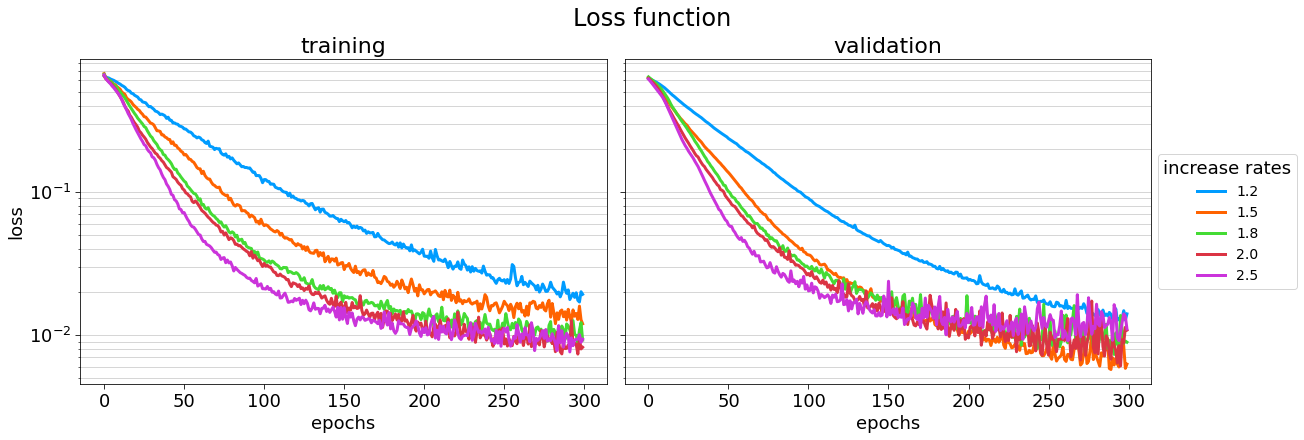

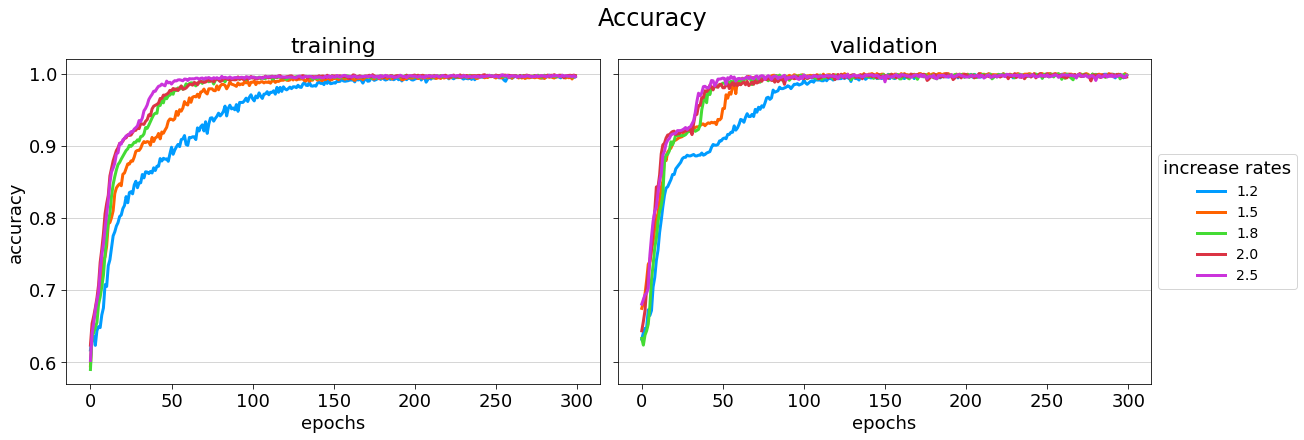

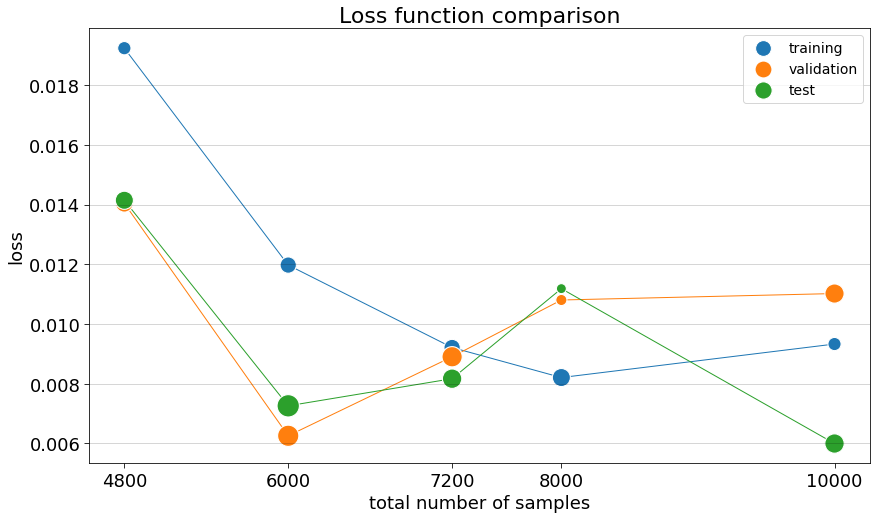

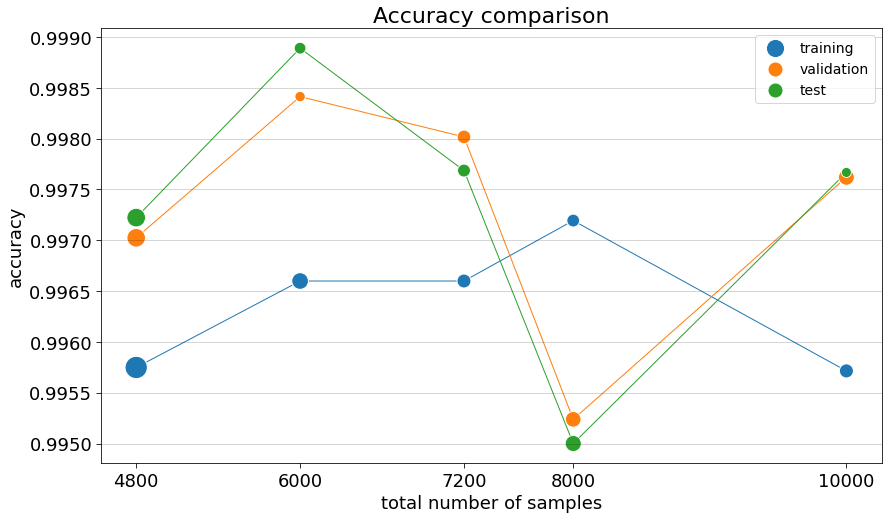

In [ ]:
palette = {
    1.2 : ["#009cff"],
    1.5 : ["#ff6300"],#44db34
    1.8 : ["#44db34"],#db3444
    2.0 : ["#db3444"],#ff6300
    2.5 : ["#cb34db"],
}
Ntot = [N*rate for rate in increase_rates]

fig, (ax1, ax2) = plt.subplots(
    nrows              = 1, 
    ncols              = 2, 
    sharex             = "all", 
    sharey             = "all",
    figsize            = (18,6), 
    constrained_layout = True
)
fig.suptitle("Loss function", fontsize=24)

ax1.grid(axis="y", color="k", alpha=0.2, which="both")
ax2.grid(axis="y", color="k", alpha=0.2, which="both")

for i in range(len(increase_rates)):

    ax1 = plot_utils.plot_loss(
        epochs     = N_epochs,
        loss       = inc_training_loss[i],
        fig        = fig,
        ax         = ax1,
        color      = palette[increase_rates[i]][0],
        loss_label = "loss",
        title      = "training",
        label      = f"{increase_rates[i]}",
        legend     = False
    )
    ax2 = plot_utils.plot_loss(
        epochs     = N_epochs,
        loss       = inc_valid_loss[i],
        fig        = fig,
        ax         = ax2,
        color      = palette[increase_rates[i]][0],
        title      = "validation",
        label      = f"{increase_rates[i]}",
        legend     = False
    )

ax1.set_yscale("log")

ax2.legend(title="increase rates", title_fontsize=18, loc="center left", bbox_to_anchor=(1, 0.5), fontsize=14)

plt.show()


## ====================================================##


fig, (ax1, ax2) = plt.subplots(
    nrows              = 1, 
    ncols              = 2, 
    sharex             = "all", 
    sharey             = "all",
    figsize            = (18,6), 
    constrained_layout = True
)
fig.suptitle("Accuracy", fontsize=24)

ax1.grid(axis="y", color="k", alpha=0.2)
ax2.grid(axis="y", color="k", alpha=0.2)

for i in range(len(increase_rates)):

    ax1 = plot_utils.plot_metric(
        epochs       = N_epochs,
        metric       = inc_training_acc[i],
        fig          = fig,
        ax           = ax1,
        color        = palette[increase_rates[i]][0],
        metric_label = "accuracy",
        title        = "training",
        label        = f"{increase_rates[i]}",
        legend       = False
    )
    ax2 = plot_utils.plot_metric(
        epochs       = N_epochs,
        metric       = inc_valid_acc[i],
        fig          = fig,
        ax           = ax2,
        color        = palette[increase_rates[i]][0],
        title        = "validation",
        label        = f"{increase_rates[i]}",
        legend       = False
    )

ax1.set_yscale("linear")

ax2.legend(title="increase rates", title_fontsize=18, loc="center left", bbox_to_anchor=(1, 0.5), fontsize=14)

plt.show()

## ====================================================##



loss_max = max(
    final_inc_training_loss + 
    final_inc_valid_loss    +
    final_inc_test_loss     
)
loss_min = min(
    final_inc_training_loss + 
    final_inc_valid_loss    +
    final_inc_test_loss 
)
acc_max  = max(
    final_inc_training_acc + 
    final_inc_valid_acc    +
    final_inc_test_acc
)
acc_min  = min(
    final_inc_training_acc + 
    final_inc_valid_acc    +
    final_inc_test_acc
)

loss_norm = (loss_min, loss_max)
acc_norm  = (acc_min,  acc_max)


fig, ax = plt.subplots(figsize=(14,8))

ax.grid(axis="y", color="k", alpha=0.2)

ax.set_title("Loss function", fontsize=22)

ax = plot_utils.scatter_results(
    parameter    = Ntot,
    result       = final_inc_training_loss,
    fig          = fig, 
    ax           = ax,
    label        = "training",
    metric_label = "loss",
    par_label    = "total number of samples",
    color        = "tab:blue",
    fontsize     = 18,
    ms           = final_inc_training_acc,
    mnorm        = acc_norm,
    legend       = True,
    title        = "Loss function comparison"
)

ax = plot_utils.scatter_results(
    parameter    = Ntot,
    result       = final_inc_valid_loss,
    fig          = fig, 
    ax           = ax,
    label        = "validation",
    metric_label = "loss",
    par_label    = "total number of samples",
    color        = "tab:orange",
    fontsize     = 18,
    ms           = final_inc_valid_acc,
    mnorm        = acc_norm,
    legend       = True,
    title        = "Loss function comparison"
)

ax = plot_utils.scatter_results(
    parameter    = Ntot,
    result       = final_inc_test_loss,
    fig          = fig, 
    ax           = ax,
    label        = "test",
    metric_label = "loss",
    par_label    = "total number of samples",
    color        = "tab:green",
    fontsize     = 18,
    ms           = final_inc_test_acc,
    mnorm        = acc_norm,
    legend       = True,
    title        = "Loss function comparison"
)

ax.set_yscale("linear")

ax.set_xticks(Ntot)

plt.show()


fig, ax = plt.subplots(figsize=(14,8))

ax.grid(axis="y", color="k", alpha=0.2)

ax.set_title("Accuracy", fontsize=22)

ax = plot_utils.scatter_results(
    parameter    = Ntot,
    result       = final_inc_training_acc,
    fig          = fig, 
    ax           = ax,
    label        = "training",
    metric_label = "accuracy",
    par_label    = "total number of samples",
    color        = "tab:blue",
    fontsize     = 18,
    ms           = final_inc_training_loss,
    mnorm        = loss_norm,
    legend       = True,
    title        = "Accuracy comparison"
)

ax = plot_utils.scatter_results(
    parameter    = Ntot,
    result       = final_inc_valid_acc,
    fig          = fig, 
    ax           = ax,
    label        = "validation",
    metric_label = "accuracy",
    par_label    = "total number of samples",
    color        = "tab:orange",
    fontsize     = 18,
    ms           = final_inc_valid_loss,
    mnorm        = loss_norm,
    legend       = True,
    title        = "Accuracy comparison"
)

ax = plot_utils.scatter_results(
    parameter    = Ntot,
    result       = final_inc_test_acc,
    fig          = fig, 
    ax           = ax,
    label        = "test",
    metric_label = "accuracy",
    par_label    = "total number of samples",
    color        = "tab:green",
    fontsize     = 18,
    ms           = final_inc_test_loss,
    mnorm        = loss_norm,
    legend       = True,
    title        = "Accuracy comparison"
)

ax.set_yscale("linear")

ax.set_xticks(Ntot)

plt.show()

As we clearly see, we do not get any significant improvements by enlarging the input dataset. This means that $N=4000$ samples are enough for the neural network to properly learn the underlying pattern of our data.

#### Reduced and increased data visualization

Here we want to merge the results of the two last sections to have a broader view of what happens when we change the input dataset sample size.

In [ ]:
red_inc_training_loss = red_training_loss + inc_training_loss
red_inc_training_acc  = red_training_acc  + inc_training_acc

red_inc_valid_loss    = red_valid_loss + inc_valid_loss
red_inc_valid_acc     = red_valid_acc  + inc_valid_acc

red_inc_test_loss     = red_test_loss + inc_test_loss
red_inc_test_acc      = red_test_acc  + inc_test_acc

red_inc_rates         = reduction_rates + increase_rates

final_red_inc_training_loss = [x[-1] for x in red_inc_training_loss]
final_red_inc_valid_loss    = [x[-1] for x in red_inc_valid_loss]
final_red_inc_test_loss     = [x     for x in red_inc_test_loss]


final_red_inc_training_acc = [x[-1] for x in red_inc_training_acc]
final_red_inc_valid_acc    = [x[-1] for x in red_inc_valid_acc]
final_red_inc_test_acc     = [x     for x in red_inc_test_acc]

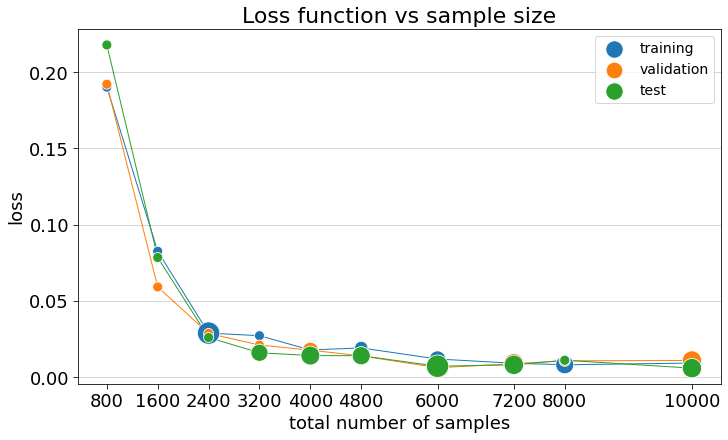

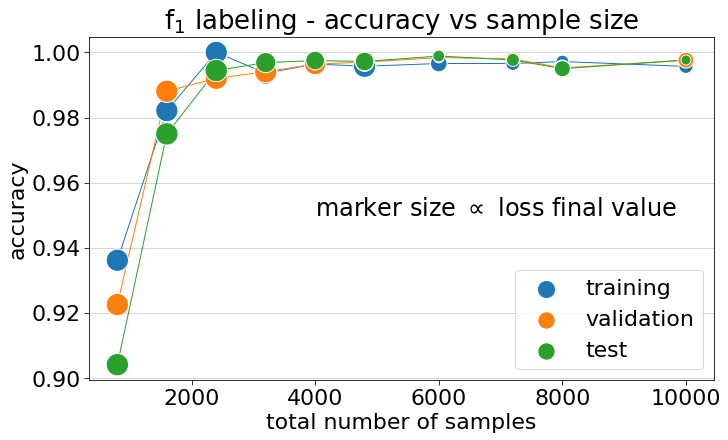

In [ ]:

Ntot = [N*rate for rate in red_inc_rates]

loss_max = max(
    final_red_inc_training_loss + 
    final_red_inc_valid_loss    +
    final_red_inc_test_loss     
)
loss_min = min(
    final_red_inc_training_loss + 
    final_red_inc_valid_loss    +
    final_red_inc_test_loss 
)
acc_max  = max(
    final_red_inc_training_acc + 
    final_red_inc_valid_acc    +
    final_red_inc_test_acc
)
acc_min  = min(
    final_red_inc_training_acc + 
    final_red_inc_valid_acc    +
    final_red_inc_test_acc
)

fig, ax = plt.subplots(figsize=(10,6), constrained_layout=True)
ax.set_axisbelow(True)
ax.grid(axis="y", color="k", alpha=0.2)

ax.set_title("Loss function", fontsize=22)

ax = plot_utils.scatter_results(
    parameter    = Ntot,
    result       = final_red_inc_training_loss,
    fig          = fig, 
    ax           = ax,
    label        = "training",
    metric_label = "loss",
    par_label    = "total number of samples",
    color        = "tab:blue",
    ms           = final_red_inc_training_acc,
    mnorm        = acc_norm,
    fontsize     = 18,
    legend       = True,
    title        = "Loss function comparison"
)

ax = plot_utils.scatter_results(
    parameter    = Ntot,
    result       = final_red_inc_valid_loss,
    fig          = fig, 
    ax           = ax,
    label        = "validation",
    metric_label = "loss",
    par_label    = "total number of samples",
    color        = "tab:orange",
    fontsize     = 18,
    ms           = final_red_inc_valid_acc,
    mnorm        = acc_norm,
    legend       = True,
    title        = "Loss function comparison"
)

ax = plot_utils.scatter_results(
    parameter    = Ntot,
    result       = final_red_inc_test_loss,
    fig          = fig, 
    ax           = ax,
    label        = "test",
    metric_label = "loss",
    par_label    = "total number of samples",
    color        = "tab:green",
    fontsize     = 18,
    ms           = final_red_inc_test_acc,
    mnorm        = acc_norm,
    legend       = True,
    title        = "Loss function vs sample size"
)

ax.set_yscale("linear")

ax.set_xticks(Ntot)

plt.show()



fig, ax = plt.subplots(figsize=(10,6), constrained_layout=True)
ax.set_axisbelow(True)
ax.grid(axis="y", color="k", alpha=0.2)

#ax.set_title("Accuracy", fontsize=22)

ax = plot_utils.scatter_results(
    parameter    = Ntot,
    result       = final_red_inc_training_acc,
    fig          = fig, 
    ax           = ax,
    label        = "training",
    metric_label = "accuracy",
    par_label    = "total number of samples",
    color        = "tab:blue",
    fontsize     = 22,
    ms           = final_red_inc_training_loss,
    mnorm        = loss_norm,
    legend       = True,
    title        = "Accuracy comparison"
)

ax = plot_utils.scatter_results(
    parameter    = Ntot,
    result       = final_red_inc_valid_acc,
    fig          = fig, 
    ax           = ax,
    label        = "validation",
    metric_label = "accuracy",
    par_label    = "total number of samples",
    color        = "tab:orange",
    fontsize     = 22,
    ms           = final_red_inc_valid_loss,
    mnorm        = loss_norm,
    legend       = True,
    title        = "Accuracy comparison"
)

ax = plot_utils.scatter_results(
    parameter    = Ntot,
    result       = final_red_inc_test_acc,
    fig          = fig, 
    ax           = ax,
    label        = "test",
    metric_label = "accuracy",
    par_label    = "total number of samples",
    color        = "tab:green",
    fontsize     = 22,
    ms           = final_red_inc_test_loss,
    mnorm        = loss_norm,
    legend       = True,
    title        = "f$_1$ labeling - accuracy vs sample size"
)

ax.set_yscale("linear")

ax.text(
    4000, 0.95,
    "marker size $\propto$ loss final value",
    fontsize=24,
    transform=ax.transData
)

#ax.set_xticks(Ntot)

ax.legend(fontsize=22)

plt.savefig("plots/reduced_increased_accuracy.pdf", dpi=300, facecolor='white')
plt.show()

### 1c) augmented

Here we follow the same approach of 1b), as we want to evaluate the performance of the neural network when we increase the number of input samples. However, we do something more realistic now. Let us imagine that we do not have the ability of generating as much data we want, as data may come from a detector for example. We do not even know the underlying labeling in many real world scenarios. 

Thus, if we really need to enlarge the input dataset, we may think of generating new data that follows the original data. That is, we generate new samples close to the one we already have. However, since we do not know the labeling function, we have to assume that the newly generated instance has the same label as the original instance. This will certainly create some noise in the labeling boundaries.

In order to evaluate the neural network performance, we change the number of original samples from which we generate the new ones.

#### Simulated data generation example

In [ ]:
# number of data
N = 4000
# box size
B = 100

# random seed for reproducibility
np.random.seed(20220308)

# sample data
x, y_true = create_data.create_data(N, B, c="triang")

# generate new data
x_augmented, y_augmented = preprocess.augment_data(x, y_true, 0.5)

# concatenate new data with original data
x_tot = np.concatenate((x,      x_augmented), axis=0)
y_tot = np.concatenate((y_true, y_augmented), axis=0)

# shuffle data 
y_tot = np.expand_dims(y_tot, axis=1)
data_tot = np.concatenate((x_tot, y_tot), axis=1)
np.random.shuffle(data_tot)

# extract shuffled data
x_tot = data_tot[:,0:2]
y_tot = data_tot[:,2]

#### Simulated data visualization

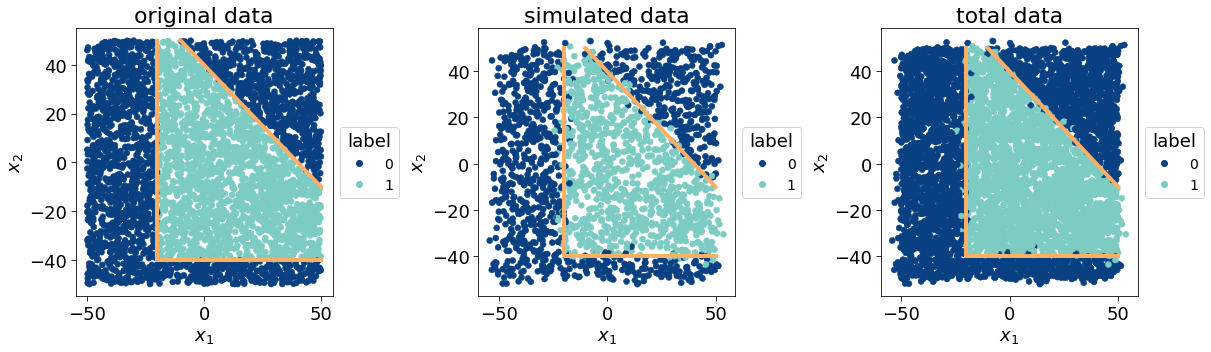

In [ ]:
fig = plt.figure(figsize=(16,5))
ax  = plot_utils.plot_labeled_data(
    x               = x, 
    labels          = y_true, 
    fig             = fig, 
    subplot_id      = 131,
    title           = "original data", 
    palette         = "GnBu_r",
    hue_norm        = (0, 2),
    fontsize        = 18, 
    show_boundaries = True
)

ax  = plot_utils.plot_labeled_data(
    x               = x_augmented, 
    labels          = y_augmented, 
    fig             = fig, 
    subplot_id      = 132,
    title           = "simulated data", 
    palette         = "GnBu_r",
    hue_norm        = (0, 2),
    fontsize        = 18, 
    show_boundaries = True
)
ax  = plot_utils.plot_labeled_data(
    x               = x_tot, 
    labels          = y_tot, 
    fig             = fig, 
    subplot_id      = 133,
    title           = "total data", 
    palette         = "GnBu_r",
    hue_norm        = (0, 2),
    fontsize        = 18, 
    show_boundaries = True
)
plt.show()

On the left we see the original data. The figure in the middle shows only the newly generated data, that in this example corresponds to $1/2$ of the entire original dataset. On the right we see the new dataset on its entirety, with both original and simulated data.

We clearly see some noise at the labeling boundaries.

#### Training, validation and test sets

In [ ]:
simulation_rates  = [0.2, 0.5, 0.8, 1.0]
train_test_frac   = 0.7
valid_train_frac  = 0.3 


training_set      = []
training_labels   = []
test_set          = []
test_labels       = []
validation_set    = []
validation_labels = []


for i, sim_rate in enumerate(simulation_rates):

    # sample data
    x_, y_true_ = create_data.create_data(N, B, c="triang")

    # generate new data
    x_augmented_, y_augmented_ = preprocess.augment_data(x_, y_true_, sim_rate)

    # concatenate new data with original data
    x_tot_ = np.concatenate((x_,      x_augmented_), axis=0)
    y_tot_ = np.concatenate((y_true_, y_augmented_), axis=0)

    # shuffle data 
    y_tot_ = np.expand_dims(y_tot_, axis=1)
    data_tot_ = np.concatenate((x_tot_, y_tot_), axis=1)
    np.random.shuffle(data_tot_)

    # extract shuffled data
    x_tot_ = data_tot_[:,0:2]
    y_tot_ = data_tot_[:,2]

    # rescale data 
    mean = np.mean(x_tot_, axis=0)
    std = np.std(x_tot_, axis=0)
    x_tot_ = preprocess.standardize(x_tot_, mean, std)

    # compute the appropriate total number of examples
    Ntot = x_tot_.shape[0]

    # split into training validation and test set
    N_train = int(Ntot*train_test_frac*(1-valid_train_frac))
    N_valid = int(Ntot*train_test_frac*valid_train_frac)
    N_test  = int(Ntot*(1-train_test_frac))

    train_idx = N_train
    valid_idx = N_train + N_valid
    test_idx  = N_train + N_valid + N_test

    data_split = {
        "training_set"   : N_train,
        "test_set"       : N_test,
        "validation_set" : N_valid
    }

    print("="*30, "\n")
    print("Simulation rate", sim_rate)
    for key, val in data_split.items():
        print(f"{key} \t N = {val}")
    print("\n", "="*30, "\n")

    training_set.append(x_tot_[0:train_idx])
    training_labels.append(y_tot_[0:train_idx])
    validation_set.append(x_tot_[train_idx:valid_idx])
    validation_labels.append(y_tot_[train_idx:valid_idx])
    test_set.append(x_tot_[valid_idx:test_idx])
    test_labels.append(y_tot_[valid_idx:test_idx])

    


Simulation rate 0.2
training_set 	 N = 2352
test_set 	 N = 1440
validation_set 	 N = 1008



Simulation rate 0.5
training_set 	 N = 2940
test_set 	 N = 1800
validation_set 	 N = 1260



Simulation rate 0.8
training_set 	 N = 3528
test_set 	 N = 2160
validation_set 	 N = 1512



Simulation rate 1.0
training_set 	 N = 3919
test_set 	 N = 2400
validation_set 	 N = 1680




#### Neural network training

In [ ]:
minibatch = 50
N_epochs  = 300

networks     = []
fit_results  = []
test_results = []

for i in range(len(simulation_rates)):

    name = f"simulation rate {simulation_rates[i]}"

    network = nn_model.create_model(
        input_dim         = input_dim,
        architecture      = architecture,
        dropout_layers    = dropout_arc,
        dropout_rates     = dropout_rates,
        batch_norm_layers = batch_norm_arc,
        hidden_activation = hidden_activation,
        output_activation = output_activation,
        loss              = loss,
        optimizer         = optimizer,
        metrics           = metrics,
        nn_name           = name,
    )

    # network.summary()

    t0 = time.time()
    fit = network.fit(
        training_set[i], training_labels[i],
        epochs          = N_epochs,
        batch_size      = minibatch,
        validation_data = (validation_set[i], validation_labels[i]),
        verbose         = 0,
    )
    t1 = time.time()

    test = network.evaluate(
        test_set[i], test_labels[i],
        batch_size      = minibatch,
        verbose         = 0,
    )

    
    print("="*30)
    print(f"\nsimulation rate {simulation_rates[i]} training : {t1-t0:.2f} seconds")

    print(f"\ntraining loss     : {fit.history['loss'][-1]:.5f}")
    print(f"training accuracy : {fit.history['accuracy'][-1]:.5f}")

    print(f"\nvalid loss        : {fit.history['val_loss'][-1]:.5f}")
    print(f"valid accuracy    : {fit.history['val_accuracy'][-1]:.5f}\n")

    print(f"\nsimulation rate {simulation_rates[i]} testing")

    print(f"\ntest loss         : {test[0]:.5f}")
    print(f"test accuracy     : {test[1]:.5f}\n")

    print("="*30)

    networks.append(network)
    fit_results.append(fit)
    test_results.append(test)


simulation rate 0.2 training : 41.54 seconds

training loss     : 0.04433
training accuracy : 0.99022

valid loss        : 0.04696
valid accuracy    : 0.98611


simulation rate 0.2 testing

test loss         : 0.05878
test accuracy     : 0.98403


simulation rate 0.5 training : 82.41 seconds

training loss     : 0.05991
training accuracy : 0.98197

valid loss        : 0.07008
valid accuracy    : 0.97698


simulation rate 0.5 testing

test loss         : 0.04550
test accuracy     : 0.98556


simulation rate 0.8 training : 45.17 seconds

training loss     : 0.06883
training accuracy : 0.97562

valid loss        : 0.08181
valid accuracy    : 0.97222


simulation rate 0.8 testing

test loss         : 0.07464
test accuracy     : 0.97500


simulation rate 1.0 training : 49.99 seconds

training loss     : 0.05680
training accuracy : 0.98214

valid loss        : 0.06012
valid accuracy    : 0.97857


simulation rate 1.0 testing

test loss         : 0.06947
test accuracy     : 0.97917



#### Neural network performance visualization

In [ ]:
sim_training_loss = []
sim_training_acc  = []
sim_valid_loss    = []
sim_valid_acc     = []
sim_test_loss     = []
sim_test_acc      = []

for i in range(len(simulation_rates)):
    sim_training_loss.append(fit_results[i].history["loss"])
    sim_training_acc.append(fit_results[i].history["accuracy"])
    sim_valid_loss.append(fit_results[i].history["val_loss"])
    sim_valid_acc.append(fit_results[i].history["val_accuracy"])
    sim_test_loss.append(test_results[i][0])
    sim_test_acc.append(test_results[i][1])

final_sim_training_loss = [x[-1] for x in sim_training_loss]
final_sim_valid_loss    = [x[-1] for x in sim_valid_loss]
final_sim_test_loss     = [x     for x in sim_test_loss]


final_sim_training_acc = [x[-1] for x in sim_training_acc]
final_sim_valid_acc    = [x[-1] for x in sim_valid_acc]
final_sim_test_acc     = [x     for x in sim_test_acc]


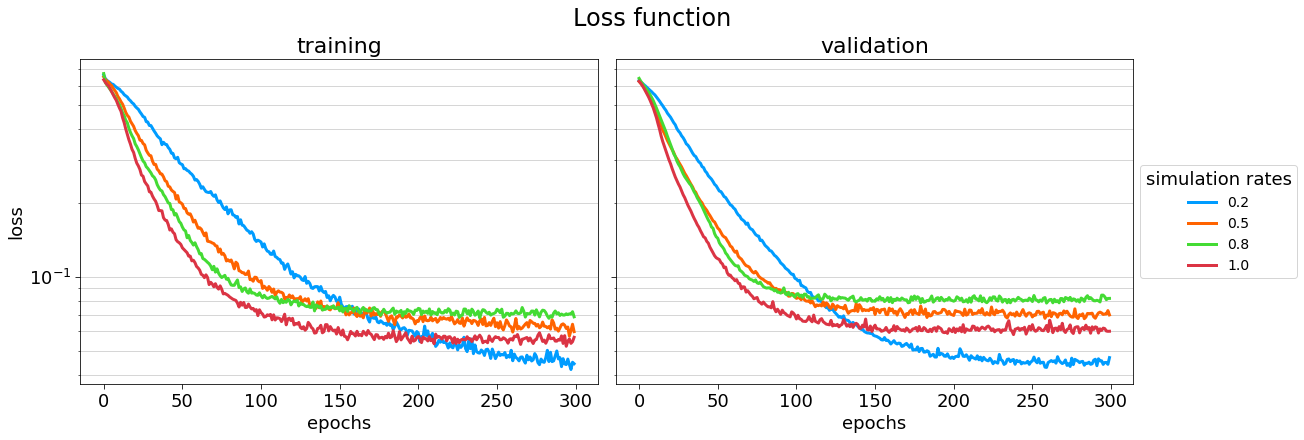

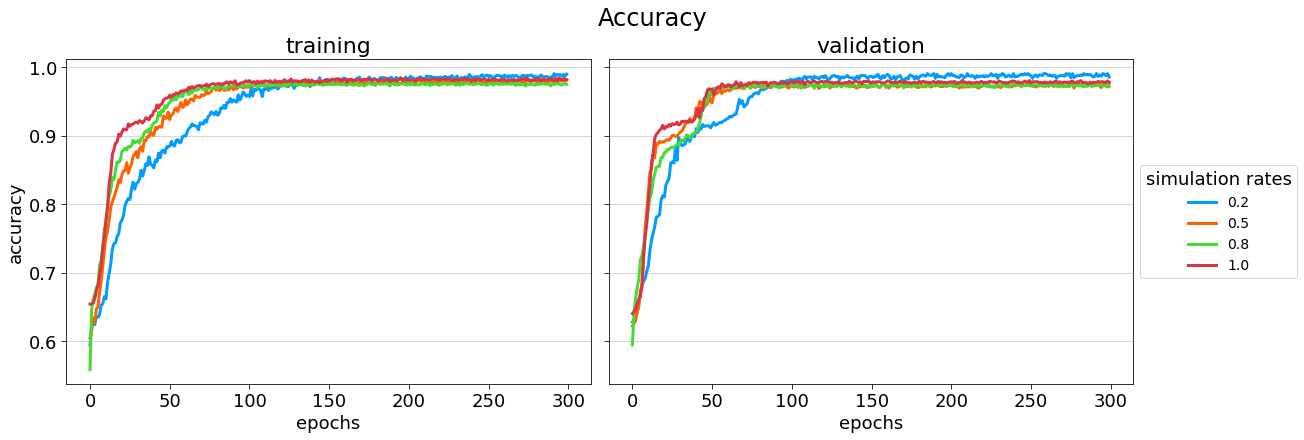

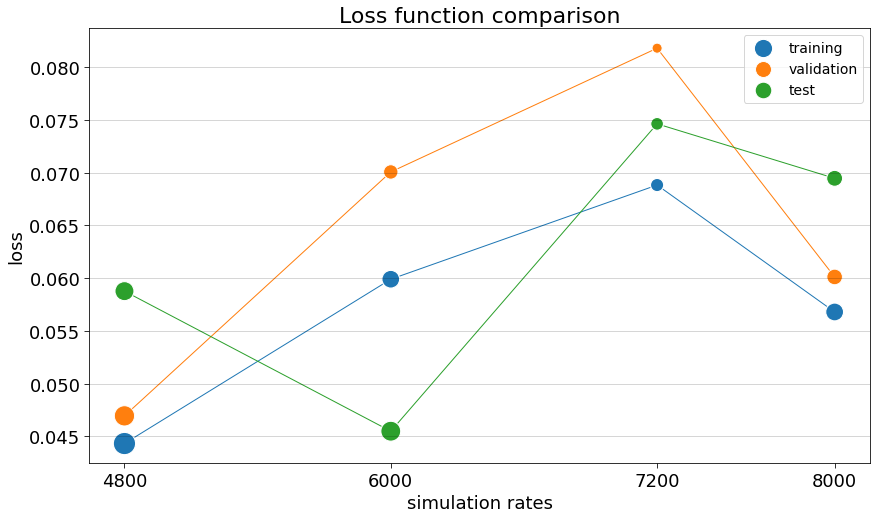

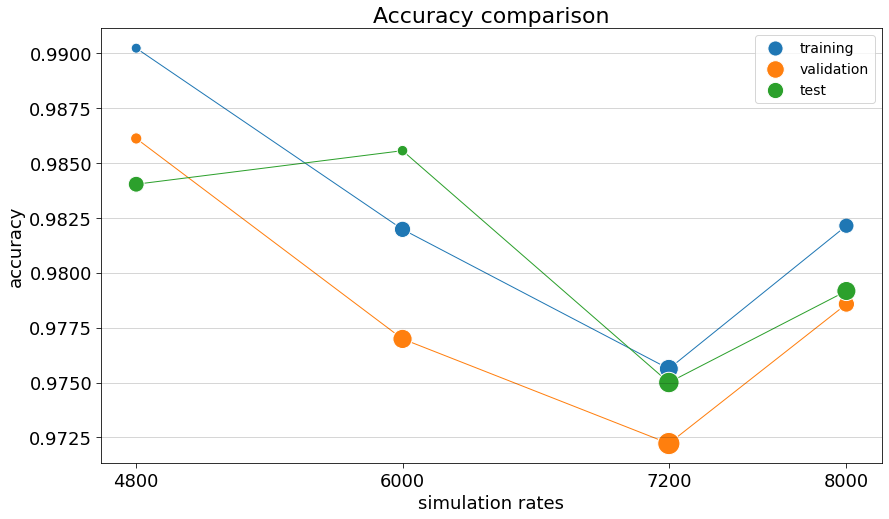

In [ ]:
palette = {
    0.2 : ["#009cff"],
    0.5 : ["#ff6300"],#44db34
    0.8 : ["#44db34"],#db3444
    1.0 : ["#db3444"],#ff6300
}

Ntot = [N*(1+rate) for rate in simulation_rates]

fig, (ax1, ax2) = plt.subplots(
    nrows              = 1, 
    ncols              = 2, 
    sharex             = "all", 
    sharey             = "all",
    figsize            = (18,6), 
    constrained_layout = True
)
fig.suptitle("Loss function", fontsize=24)

ax1.grid(axis="y", color="k", alpha=0.2, which="both")
ax2.grid(axis="y", color="k", alpha=0.2, which="both")

for i in range(len(simulation_rates)):

    ax1 = plot_utils.plot_loss(
        epochs     = N_epochs,
        loss       = sim_training_loss[i],
        fig        = fig,
        ax         = ax1,
        color      = palette[simulation_rates[i]][0],
        loss_label = "loss",
        title      = "training",
        label      = f"{simulation_rates[i]}",
        legend     = False
    )
    ax2 = plot_utils.plot_loss(
        epochs     = N_epochs,
        loss       = sim_valid_loss[i],
        fig        = fig,
        ax         = ax2,
        color      = palette[simulation_rates[i]][0],
        title      = "validation",
        label      = f"{simulation_rates[i]}",
        legend     = False
    )

ax1.set_yscale("log")

ax2.legend(title="simulation rates", title_fontsize=18, loc="center left", bbox_to_anchor=(1, 0.5), fontsize=14)

plt.show()


## ====================================================##


fig, (ax1, ax2) = plt.subplots(
    nrows              = 1, 
    ncols              = 2, 
    sharex             = "all", 
    sharey             = "all",
    figsize            = (18,6), 
    constrained_layout = True
)
fig.suptitle("Accuracy", fontsize=24)

ax1.grid(axis="y", color="k", alpha=0.2)
ax2.grid(axis="y", color="k", alpha=0.2)

for i in range(len(simulation_rates)):

    ax1 = plot_utils.plot_metric(
        epochs       = N_epochs,
        metric       = sim_training_acc[i],
        fig          = fig,
        ax           = ax1,
        color        = palette[simulation_rates[i]][0],
        metric_label = "accuracy",
        title        = "training",
        label        = f"{simulation_rates[i]}",
        legend       = False
    )
    ax2 = plot_utils.plot_metric(
        epochs       = N_epochs,
        metric       = sim_valid_acc[i],
        fig          = fig,
        ax           = ax2,
        color        = palette[simulation_rates[i]][0],
        title        = "validation",
        label        = f"{simulation_rates[i]}",
        legend       = False
    )

ax1.set_yscale("linear")

ax2.legend(title="simulation rates", title_fontsize=18, loc="center left", bbox_to_anchor=(1, 0.5), fontsize=14)

plt.show()

## ====================================================##



oss_max = max(
    final_sim_training_loss + 
    final_sim_valid_loss    +
    final_sim_test_loss     
)
loss_min = min(
    final_sim_training_loss + 
    final_sim_valid_loss    +
    final_sim_test_loss 
)
acc_max  = max(
    final_sim_training_acc + 
    final_sim_valid_acc    +
    final_sim_test_acc
)
acc_min  = min(
    final_sim_training_acc + 
    final_sim_valid_acc    +
    final_sim_test_acc
)

loss_norm = (loss_min, loss_max)
acc_norm  = (acc_min,  acc_max)


fig, ax = plt.subplots(figsize=(14,8))

ax.grid(axis="y", color="k", alpha=0.2)

ax.set_title("Loss function", fontsize=22)

ax = plot_utils.scatter_results(
    parameter    = Ntot,
    result       = final_sim_training_loss,
    fig          = fig, 
    ax           = ax,
    label        = "training",
    metric_label = "loss",
    par_label    = "simulation rates",
    color        = "tab:blue",
    fontsize     = 18,
    ms           = final_sim_training_acc,
    mnorm        = acc_norm,
    legend       = True,
    title        = "Loss function comparison"
)

ax = plot_utils.scatter_results(
    parameter    = Ntot,
    result       = final_sim_valid_loss,
    fig          = fig, 
    ax           = ax,
    label        = "validation",
    metric_label = "loss",
    par_label    = "simulation rates",
    color        = "tab:orange",
    fontsize     = 18,
    ms           = final_sim_valid_acc,
    mnorm        = acc_norm,
    legend       = True,
    title        = "Loss function comparison"
)

ax = plot_utils.scatter_results(
    parameter    = Ntot,
    result       = final_sim_test_loss,
    fig          = fig, 
    ax           = ax,
    label        = "test",
    metric_label = "loss",
    par_label    = "simulation rates",
    color        = "tab:green",
    fontsize     = 18,
    ms           = final_sim_test_acc,
    mnorm        = acc_norm,
    legend       = True,
    title        = "Loss function comparison"
)

ax.set_yscale("linear")

ax.set_xticks(Ntot)

plt.show()


fig, ax = plt.subplots(figsize=(14,8))

ax.grid(axis="y", color="k", alpha=0.2)

ax.set_title("Accuracy", fontsize=22)

ax = plot_utils.scatter_results(
    parameter    = Ntot,
    result       = final_sim_training_acc,
    fig          = fig, 
    ax           = ax,
    label        = "training",
    metric_label = "accuracy",
    par_label    = "simulation rates",
    color        = "tab:blue",
    fontsize     = 18,
    ms           = final_sim_training_loss,
    mnorm        = loss_norm,
    legend       = True,
    title        = "Accuracy comparison"
)

ax = plot_utils.scatter_results(
    parameter    = Ntot,
    result       = final_sim_valid_acc,
    fig          = fig, 
    ax           = ax,
    label        = "validation",
    metric_label = "accuracy",
    par_label    = "simulation rates",
    color        = "tab:orange",
    fontsize     = 18,
    ms           = final_sim_valid_loss,
    mnorm        = loss_norm,
    legend       = True,
    title        = "Accuracy comparison"
)

ax = plot_utils.scatter_results(
    parameter    = Ntot,
    result       = final_sim_test_acc,
    fig          = fig, 
    ax           = ax,
    label        = "test",
    metric_label = "accuracy",
    par_label    = "simulation rates",
    color        = "tab:green",
    fontsize     = 18,
    ms           = final_sim_test_loss,
    mnorm        = loss_norm,
    legend       = True,
    title        = "Accuracy comparison"
)

ax.set_yscale("linear")

ax.set_xticks(Ntot)

plt.show()

#### Increased datasets vs augmented datasets

Finally, we want to compare 1b) with 1c). In both cases we enlarged the input dataset. In 1b) we enlarged it perfectly, simply generating more samples as we had the ability to do so and we knew how to label data. In 1c) instead, we assumed that we did not know the labeling function and enlarged the input dataset by simulated new data from the original dataset. This, of course, introduced some noise at the labeling boundaries that lowered the neural network accuracy.

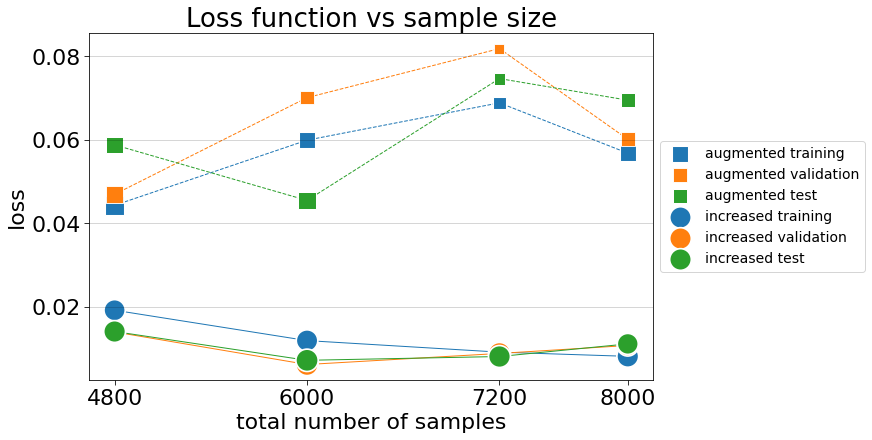

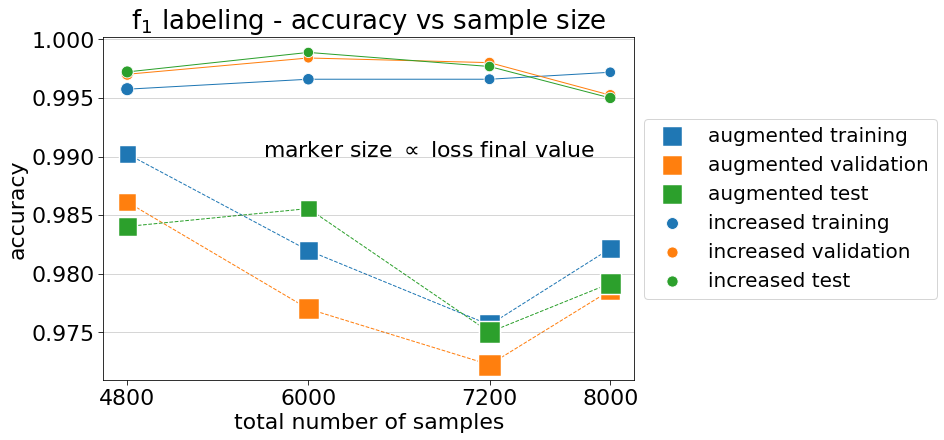

In [ ]:
N_total = [N*i for i in increase_rates[:-1]]
fontsize=22

loss_max = max(
    final_sim_training_loss + 
    final_sim_valid_loss    +
    final_sim_test_loss     +
    final_inc_training_loss + 
    final_inc_valid_loss    +
    final_inc_test_loss     
)
loss_min = min(
    final_sim_training_loss + 
    final_sim_valid_loss    +
    final_sim_test_loss     +
    final_inc_training_loss + 
    final_inc_valid_loss    +
    final_inc_test_loss     
)
acc_max  = max(
    final_sim_training_acc + 
    final_sim_valid_acc    +
    final_sim_test_acc     +
    final_inc_training_acc + 
    final_inc_valid_acc    +
    final_inc_test_acc     
)
acc_min  = min(
    final_sim_training_acc + 
    final_sim_valid_acc    +
    final_sim_test_acc     +
    final_inc_training_acc + 
    final_inc_valid_acc    +
    final_inc_test_acc     
)

loss_norm = (loss_min, loss_max)
acc_norm  = (acc_min,  acc_max)

fig, ax = plt.subplots(figsize=(12,6), constrained_layout=True)

ax.grid(axis="y", color="k", alpha=0.2)

ax.set_title("Loss function", fontsize=22)

ax = plot_utils.scatter_results(
    parameter    = N_total,
    result       = final_sim_training_loss,
    fig          = fig, 
    ax           = ax,
    label        = "augmented training",
    metric_label = "loss",
    par_label    = "total number of samples",
    color        = "tab:blue",
    fontsize     = fontsize,
    ms           = final_sim_training_acc,
    mnorm        = acc_norm,
    mstyle       = "s",
    ls           = "dashed",
    legend       = True,
    title        = "Loss function comparison"
)

ax = plot_utils.scatter_results(
    parameter    = N_total,
    result       = final_sim_valid_loss,
    fig          = fig, 
    ax           = ax,
    label        = "augmented validation",
    metric_label = "loss",
    par_label    = "total number of samples",
    color        = "tab:orange",
    fontsize     = fontsize,
    ms           = final_sim_valid_acc,
    mnorm        = acc_norm,
    mstyle       = "s",
    ls           = "dashed",
    legend       = True,
    title        = "Loss function comparison"
)

ax = plot_utils.scatter_results(
    parameter    = N_total,
    result       = final_sim_test_loss,
    fig          = fig, 
    ax           = ax,
    label        = "augmented test",
    metric_label = "loss",
    par_label    = "total number of samples",
    color        = "tab:green",
    fontsize     = fontsize,
    ms           = final_sim_test_acc,
    mnorm        = acc_norm,
    mstyle       = "s",
    ls           = "dashed",
    legend       = True,
    title        = "Loss function comparison"
)

ax = plot_utils.scatter_results(
    parameter    = N_total,
    result       = final_inc_training_loss[:-1],
    fig          = fig, 
    ax           = ax,
    label        = "increased training",
    metric_label = "loss",
    par_label    = "total number of samples",
    color        = "tab:blue",
    fontsize     = fontsize,
    ms           = final_inc_training_acc[:-1],
    mnorm        = acc_norm,
    legend       = True,
    title        = "Loss function comparison"
)

ax = plot_utils.scatter_results(
    parameter    = N_total,
    result       = final_inc_valid_loss[:-1],
    fig          = fig, 
    ax           = ax,
    label        = "increased validation",
    metric_label = "loss",
    par_label    = "total number of samples",
    color        = "tab:orange",
    fontsize     = fontsize,
    ms           = final_inc_valid_acc[:-1],
    mnorm        = acc_norm,
    legend       = True,
    title        = "Loss function comparison"
)

ax = plot_utils.scatter_results(
    parameter    = N_total,
    result       = final_inc_test_loss[:-1],
    fig          = fig, 
    ax           = ax,
    label        = "increased test",
    metric_label = "loss",
    par_label    = "total number of samples",
    color        = "tab:green",
    fontsize     = fontsize,
    ms           = final_inc_test_acc[:-1],
    mnorm        = acc_norm,
    legend       = True,
    title        = "Loss function vs sample size"
)

ax.set_yscale("linear")

ax.set_xticks(N_total)

ax.legend(title="", title_fontsize=0, loc="center left", bbox_to_anchor=(1, 0.5), fontsize=14)


plt.show()


fig, ax = plt.subplots(figsize=(13,6), constrained_layout=True)
ax.set_axisbelow(True)
ax.grid(axis="y", color="k", alpha=0.2)

ax = plot_utils.scatter_results(
    parameter    = N_total,
    result       = final_sim_training_acc,
    fig          = fig, 
    ax           = ax,
    label        = "augmented training",
    metric_label = "accuracy",
    par_label    = "total number of samples",
    color        = "tab:blue",
    fontsize     = fontsize,
    mstyle       = "s",
    ls           = "dashed",
    ms           = final_sim_training_loss,
    mnorm        = loss_norm,
    legend       = True,
    title        = "Accuracy comparison"
)

ax = plot_utils.scatter_results(
    parameter    = N_total,
    result       = final_sim_valid_acc,
    fig          = fig, 
    ax           = ax,
    label        = "augmented validation",
    metric_label = "accuracy",
    par_label    = "total number of samples",
    color        = "tab:orange",
    fontsize     = fontsize,
    mstyle       = "s",
    ls           = "dashed",
    ms           = final_sim_valid_loss,
    mnorm        = loss_norm,
    legend       = True,
    title        = "Accuracy comparison"
)

ax = plot_utils.scatter_results(
    parameter    = N_total,
    result       = final_sim_test_acc,
    fig          = fig, 
    ax           = ax,
    label        = "augmented test",
    metric_label = "accuracy",
    par_label    = "total number of samples",
    color        = "tab:green",
    fontsize     = fontsize,
    mstyle       = "s",
    ls           = "dashed",
    ms           = final_sim_test_loss,
    mnorm        = loss_norm,
    legend       = True,
    title        = "Accuracy comparison"
)

ax = plot_utils.scatter_results(
    parameter    = N_total,
    result       = final_inc_training_acc[:-1],
    fig          = fig, 
    ax           = ax,
    label        = "increased training",
    metric_label = "accuracy",
    par_label    = "total number of samples",
    color        = "tab:blue",
    fontsize     = fontsize,
    ms           = final_inc_training_loss[:-1],
    mnorm        = loss_norm,
    legend       = True,
    title        = "Accuracy comparison"
)

ax = plot_utils.scatter_results(
    parameter    = N_total,
    result       = final_inc_valid_acc[:-1],
    fig          = fig, 
    ax           = ax,
    label        = "increased validation",
    metric_label = "accuracy",
    par_label    = "total number of samples",
    color        = "tab:orange",
    fontsize     = fontsize,
    ms           = final_inc_valid_loss[:-1],
    mnorm        = loss_norm,
    legend       = True,
    title        = "Accuracy comparison"
)

ax = plot_utils.scatter_results(
    parameter    = N_total,
    result       = final_inc_test_acc[:-1],
    fig          = fig, 
    ax           = ax,
    label        = "increased test",
    metric_label = "accuracy",
    par_label    = "total number of samples",
    color        = "tab:green",
    fontsize     = fontsize,
    ms           = final_inc_test_loss[:-1],
    mnorm        = loss_norm,
    legend       = True,
    title        = "f$_1$ labeling - accuracy vs sample size"
)

ax.set_yscale("linear")

ax.set_xticks(N_total)

ax.text(
    5700, 0.990,
    "marker size $\propto$ loss final value",
    fontsize=22,
    transform=ax.transData
)

ax.legend(title="", title_fontsize=0, loc="center left", bbox_to_anchor=(1, 0.5), fontsize=20)
plt.savefig("plots/inc_vs_sim_accuracy.pdf", dpi=300, facecolor='white')


plt.show()

## 2 - Implement a “grid search” to improve one or more of the aspects or parameters of the model

### Preparing data

In [ ]:
# number of data
N = 4000
# box size
B = 100

# random seed for reproducibility
np.random.seed(20220308)

x, y_true = create_data.create_data(N, B, c="triang")

In [ ]:
## RE SCALING DATA
mean = np.mean(x, axis=0)
std = np.std(x, axis=0)

x_scaled = preprocess.standardize(x, mean, std)

## SPLIT TRAIN  VALID AND TEST -> da vedere se mettere univoco all'inizio o cosa
train_test_frac  = 0.7
valid_train_frac = 0.2 

N_train = int(N*train_test_frac*(1-valid_train_frac))
N_valid = int(N*train_test_frac*valid_train_frac)
N_test  = int(N*(1-train_test_frac))

train_idx = N_train
valid_idx = N_train + N_valid
test_idx  = N_train + N_valid + N_test

x_train, y_train = np.copy(x_scaled[:train_idx]),  np.copy(y_true[:train_idx])
x_valid, y_valid = np.copy(x_scaled[train_idx:valid_idx]), np.copy(y_true[train_idx:valid_idx])
x_test,  y_test  = np.copy(x_scaled[valid_idx:test_idx]), np.copy(y_true[valid_idx:test_idx])

print(f"\nN_train :\t{x_train.shape[0]} \nN_valid :\t{x_valid.shape[0]} \nN_test :\t{x_test.shape[0]}")


N_train :	2240 
N_valid :	560 
N_test :	1200


### Define NN and its architecture

In [ ]:
def create_model(
    n_features,
    neurons           = [20, 20, 1],
    dropout_arc       = [1],
    dropout_rates     = [0.2],
    hidden_activation = "relu",
    batch_norm_arc    = None,
    output_activation = "sigmoid",
    name              = "my lovely neural network",
    loss              = "binary_crossentropy",
    optimizer         = "adam",
    metrics           = ["accuracy"]
):
    # initialize architecture
    architecture = [n_features] + neurons
    input_dim    = n_features

    # create model
    network = nn_model.NN(
        input_dim         = input_dim,
        architecture      = architecture,
        dropout_layers    = dropout_arc,
        dropout_rates     = dropout_rates,
        batch_norm_layers = batch_norm_arc,
        hidden_activation = hidden_activation,
        output_activation = output_activation,
        nn_name           = name
    ) 

    # solves the "Model cannot be saved" issue
    network.compute_output_shape((None, input_dim))   
    
    network.compile(
        loss      = loss,
        optimizer = optimizer,
        metrics   = metrics,
    )
    return network

In [ ]:
minibatch = 50
N_epochs  = 250
model_gridsearch = KerasClassifier(build_fn=create_model, 
                                   n_features=x.shape[1], 
                                   epochs=N_epochs, 
                                   batch_size=minibatch)

### Initial guess performances

Here we look at the performances of the DNN implemented without optimizing its hyperparameters but setting them with a guess based on initial considerations:
- *neurons*          : [20, 20, 1]
- *dropout_arc*      : [1]
- *dropout_rate*     : [0.2]
- *hidden_activation*: relu
- *output_activation*: sigmoid
- *loss*             : binary_crossentropy
- *optimizer*        : adam
- *metrics*          : [accuracy]

In [ ]:
# check current model
model_gridsearch.get_params()

{'n_features': 2,
 'epochs': 250,
 'batch_size': 50,
 'build_fn': <function __main__.create_model(n_features, neurons=[20, 20, 1], dropout_arc=[1], dropout_rates=[0.2], hidden_activation='relu', batch_norm_arc=None, output_activation='sigmoid', name='my lovely neural network', loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])>}

In [ ]:
# fit initial model
fit = model_gridsearch.fit(x_train, y_train, validation_data=(x_valid, y_valid), verbose=0)

# compute predictions
y_pred =model_gridsearch.predict(x_test)

pred_binary = y_pred.copy()
pred_binary[y_pred <= 0.5] = 0
pred_binary[y_pred >  0.5] = 1

# compute confusion matrix
cm = confusion_matrix(y_test, plot_utils.flatten(pred_binary))

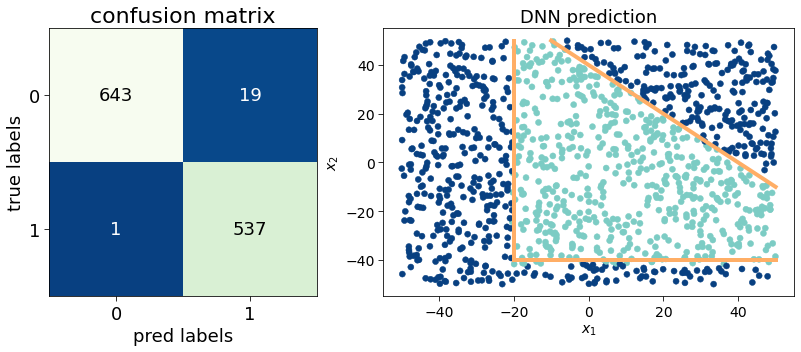

In [ ]:
fig = plt.figure(figsize=(12,5), constrained_layout=True)

# plot confusion matrix
ax = fig.add_subplot(121)

plot_utils.plot_confusion_matrix(
    cm = cm,
    ax = ax,
    title = "confusion matrix"
)
# plot predictions

# scale back x data
#mean = np.mean(x, axis=0)
#std = np.std(x, axis=0)

ax  = plot_utils.plot_labeled_data(
        x               = x_test*std + mean, 
        labels          = plot_utils.flatten(y_pred), 
        fig             = fig, 
        subplot_id      = 122,
        title           = "DNN prediction", 
        palette         = "GnBu_r",
        hue_norm        = (0, 2),
        fontsize        = 14, 
        legend          = False 
    )
plot_utils.boundaries(ax)
    
plt.show()

### Grid Search CV

We now implement a grid search in order to tune the network hyperparameters. Optimization is performed splitting the hyperparameter space in two clusters:

1. optimizer, loss, hidden activation function, epochs, batch size 
2. shape of the network & number of total neurons, dropout architecture, dropout rates

the former includes the main learning parameters and the latter takes care of the NN architecture. Dropout settings are grouped with the second cluster given their close dependence with the NN architecture.

Then, for each cluster we proceed as follow:

- perform a grid search over each single parameter of the cluster, refine the default model with the best found value
- taking into accounts the values within a $\sigma$ of the best value for each parameter re-run a grid search for all the parameters of the given cluster, re-fine the model with the new best values


To perfrom grid search operations we used the `GridSearchCV` method from the *sklearn* library, and for a more user-friendly usage the interface with this method is handled by the `GridSearch` class implemented in ```gridsearch.py```.


#### 1 - Learning parameters
Below, we reported all the different values that we explored for each parameter, a more in-depth description of the roles and differences between the various possibilities can be found [here](https://keras.io/api/).
$$
\textit{optimizer}=
\begin{cases}
\text{SGD} \\
\text{RMSprop} \\
\text{Adam} \\
\text{Adadelta} \\
\text{Adagrad} \\
\text{Nadam} \\
\text{Adamax} \\
\text{Ftrl} 
\end{cases}
\hspace{0.5 cm}
\textit{hidden activation}=
\begin{cases}
\text{relu} \\
\text{elu} \\
\text{sigmoid} \\
\text{tanh} \\
\text{softmax} \\
\text{softsign} \\
\text{softplus} \\
\text{selu} 
\end{cases}
\hspace{0.5 cm}
\textit{epochs}=
\begin{cases}
10 \\
50 \\
100 \\
200 \\
300 \\
400 \\ 
\end{cases}
\hspace{0.5 cm}
\textit{batch size}=
\begin{cases}
50 \\
100 \\
250 \\
500 \\
1000 \\
\text{N\_train} \\ 
\end{cases}
$$

In [ ]:
## OPTIMIZER
# define parameter list
optimizer  = ['SGD', 'RMSprop', 'Adam', 'Adadelta', 'Adagrad', 'Nadam', 'Adamax', 'Ftrl']
param_grid = dict(optimizer = optimizer)

# perform grid search
grid = gridsearch.GridSearch(x_train, y_train, model_gridsearch, param_grid)
grid.get_result()

GridSearchCV(cv=4,
             estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x7f871a3adb50>,
             n_jobs=-1,
             param_grid={'optimizer': ['SGD', 'RMSprop', 'Adam', 'Adadelta',
                                       'Adagrad', 'Nadam', 'Adamax', 'Ftrl']})

Best: 0.998661 using {'optimizer': 'Nadam'}
0.998661 (0.000773) with: {'optimizer': 'Nadam'}
0.995982 (0.001946) with: {'optimizer': 'Adam'}
0.995536 (0.001996) with: {'optimizer': 'RMSprop'}
0.994643 (0.002187) with: {'optimizer': 'Adamax'}
0.983482 (0.005110) with: {'optimizer': 'SGD'}
0.741518 (0.014025) with: {'optimizer': 'Adagrad'}
0.547768 (0.017005) with: {'optimizer': 'Ftrl'}
0.515625 (0.118426) with: {'optimizer': 'Adadelta'}


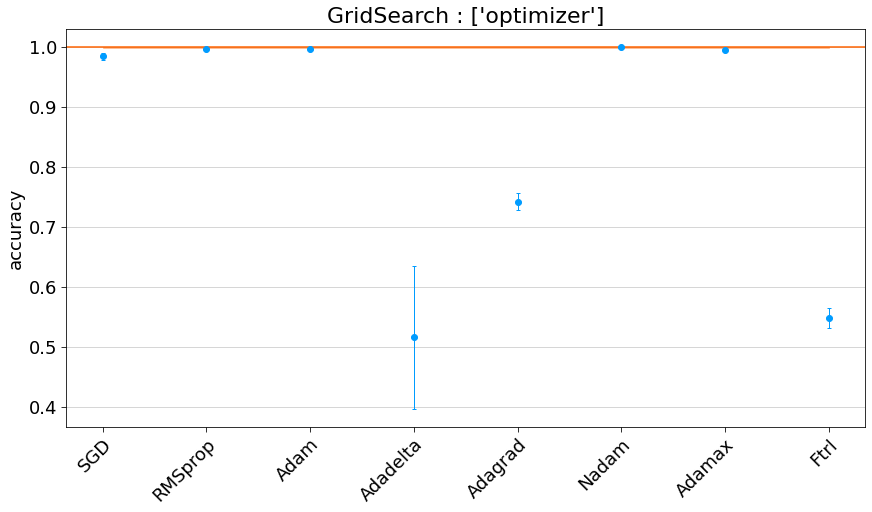

In [ ]:
# print grid search results
grid.print_result()

# plot grid search results
key = ["optimizer"]

fig = plt.figure(figsize=(12,7), constrained_layout=True)

ax = plot_utils.plot_gs_results(
    gs_results = [grid.grid_result],
    fig        = fig,
    fontsize   = 18,
    legend     = False,
    title      = f"GridSearch : {key}",
    key        = key,
    fill_box   = True,
    legend_title = None
)
ax.grid(axis="y", color="k", alpha=0.2)

plt.show()

In [ ]:
# update the model with best found value
model_gridsearch = model_gridsearch.set_params(optimizer='Nadam')

In [ ]:
## HIDDEN ACTIVATION
# define parameter list
hidden_activation = ['relu', 'elu', 'sigmoid', 'tanh', 'softmax', 'softsign', 'softplus', 'selu']
param_grid        = dict(hidden_activation         = hidden_activation)

# perform grid search
grid = gridsearch.GridSearch(x_train, y_train, model_gridsearch, param_grid)
grid.get_result()

GridSearchCV(cv=4,
             estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x7f871a3adb50>,
             n_jobs=-1,
             param_grid={'hidden_activation': ['relu', 'elu', 'sigmoid', 'tanh',
                                               'softmax', 'softsign',
                                               'softplus', 'selu']})

Best: 0.997768 using {'hidden_activation': 'softsign'}
0.997768 (0.001481) with: {'hidden_activation': 'softsign'}
0.996875 (0.001946) with: {'hidden_activation': 'tanh'}
0.995536 (0.001996) with: {'hidden_activation': 'relu'}
0.993750 (0.001996) with: {'hidden_activation': 'elu'}
0.991964 (0.001546) with: {'hidden_activation': 'selu'}
0.978571 (0.007254) with: {'hidden_activation': 'softmax'}
0.935268 (0.016817) with: {'hidden_activation': 'softplus'}
0.919643 (0.019521) with: {'hidden_activation': 'sigmoid'}


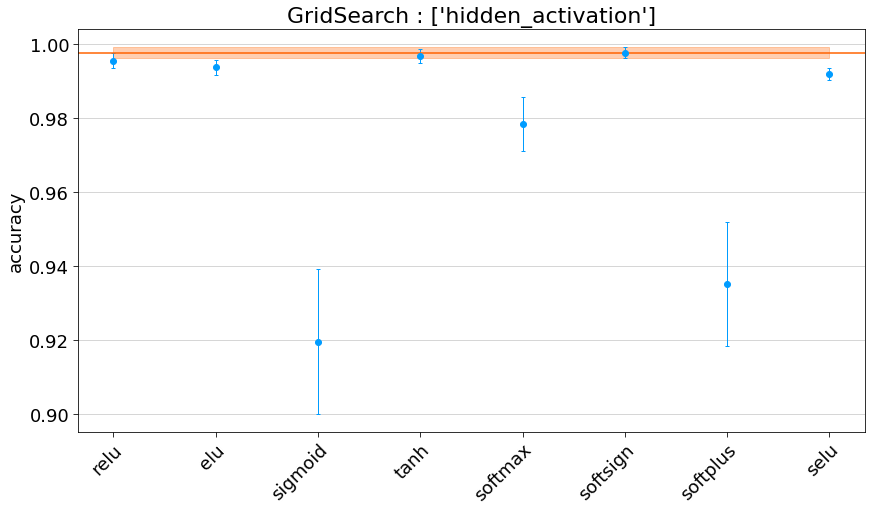

In [ ]:
# print grid search results
grid.print_result()

# plot grid search results
key = ["hidden_activation"]

fig = plt.figure(figsize=(12,7), constrained_layout=True)

ax = plot_utils.plot_gs_results(
    gs_results = [grid.grid_result],
    fig        = fig,
    fontsize   = 18,
    legend     = False,
    title      = f"GridSearch : {key}",
    key        = key,
    fill_box   = True,
    legend_title = None
)
ax.grid(axis="y", color="k", alpha=0.2)

plt.show()

In [ ]:
# update the model with best found value
model_gridsearch = model_gridsearch.set_params(hidden_activation='softsign')

In [ ]:
## EPOCHS
# define parameter list
N_epochs        = [10, 50, 100, 200, 300, 400]
param_grid = dict(epochs        = N_epochs)

# perfrom grid search
grid = gridsearch.GridSearch(x_train, y_train, model_gridsearch, param_grid)
grid.get_result()

GridSearchCV(cv=4,
             estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x7f871a3adb50>,
             n_jobs=-1, param_grid={'epochs': [10, 50, 100, 200, 300, 400]})

Best: 0.997768 using {'epochs': 300}
0.997768 (0.000773) with: {'epochs': 300}
0.997321 (0.002679) with: {'epochs': 400}
0.996875 (0.001481) with: {'epochs': 200}
0.975446 (0.009138) with: {'epochs': 100}
0.925446 (0.015172) with: {'epochs': 50}
0.704018 (0.037188) with: {'epochs': 10}


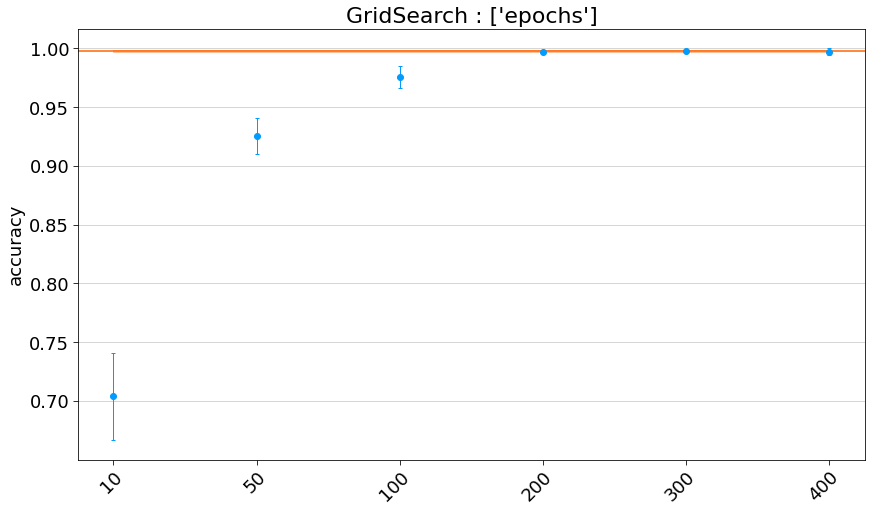

In [ ]:
# print grid search results
grid.print_result()

# plot grid search results
key = ["epochs"]

fig = plt.figure(figsize=(12,7), constrained_layout=True)

ax = plot_utils.plot_gs_results(
    gs_results = [grid.grid_result],
    fig        = fig,
    fontsize   = 18,
    legend     = False,
    title      = f"GridSearch : {key}",
    key        = key,
    fill_box   = True,
    legend_title = None
)
ax.grid(axis="y", color="k", alpha=0.2)

plt.show()

In [ ]:
# update the model
model_gridsearch = model_gridsearch.set_params(epochs=300)

In [ ]:
## BATCH_SIZE
# define parameter list
minibatch        = [N_train, 50, 100, 250, 500 , 1000]
param_grid = dict(batch_size        = minibatch)

# perfrom grid search
grid = gridsearch.GridSearch(x_train, y_train, model_gridsearch, param_grid)
grid.get_result()

GridSearchCV(cv=4,
             estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x7f871a3adb50>,
             n_jobs=-1,
             param_grid={'batch_size': [2240, 50, 100, 250, 500, 1000]})

Best: 0.997321 using {'batch_size': 50}
0.997321 (0.001996) with: {'batch_size': 100}
0.997321 (0.001996) with: {'batch_size': 50}
0.986161 (0.006844) with: {'batch_size': 250}
0.966071 (0.013658) with: {'batch_size': 500}
0.897768 (0.026945) with: {'batch_size': 1000}
0.792857 (0.041515) with: {'batch_size': 2240}


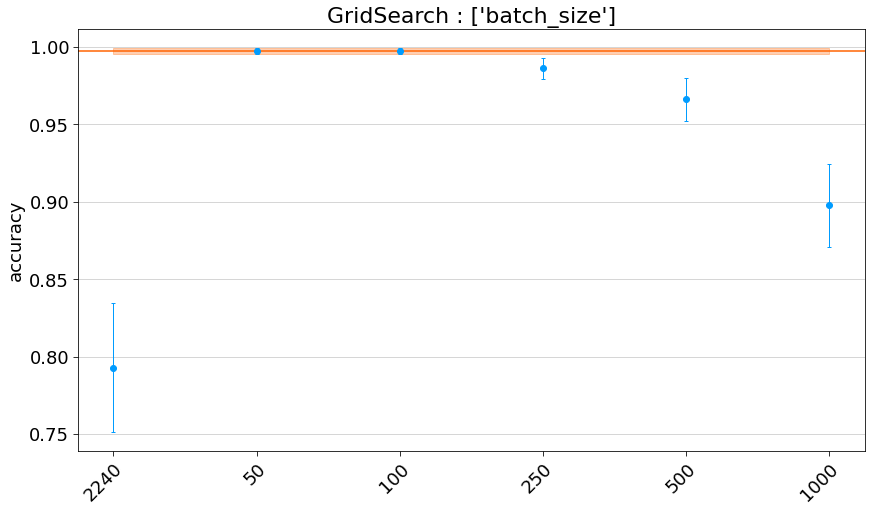

In [ ]:
# print grid search results
grid.print_result()

# plot grid search results
key = ["batch_size"]

fig = plt.figure(figsize=(12,7), constrained_layout=True)

ax = plot_utils.plot_gs_results(
    gs_results = [grid.grid_result],
    fig        = fig,
    fontsize   = 18,
    legend     = False,
    title      = f"GridSearch : {key}",
    key        = key,
    fill_box   = True,
    legend_title = None
)
ax.grid(axis="y", color="k", alpha=0.2)

plt.show()

In [ ]:
# update the model
model_gridsearch = model_gridsearch.set_params(batch_size=50)

Now we can take the best values for each parameter (i.e all the values within a $\sigma$ with respect to the best found value) and perform a total GridSearch over all the parameters of the cluster.

In [ ]:
## 1- TOTAL GRIDSEARCH
optimizer         = ['RMSprop', 'Adamax', 'Nadam', 'Adam']
hidden_activation = ['relu', 'tanh', 'softsign']
#N_epochs          = [400, 300, 200]
minibatch         = [50, 100]

param_grid = dict(optimizer         = optimizer,
                  hidden_activation = hidden_activation,
                  #epochs     = N_epochs,
                  batch_size = minibatch)

# perfrom grid search
grid = gridsearch.GridSearch(x_train, y_train, model_gridsearch, param_grid)
grid.get_result()

GridSearchCV(cv=4,
             estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x7f871a3adb50>,
             n_jobs=-1,
             param_grid={'batch_size': [50, 100],
                         'hidden_activation': ['relu', 'tanh', 'softsign'],
                         'optimizer': ['RMSprop', 'Adamax', 'Nadam', 'Adam']})

Best: 0.998661 using {'batch_size': 50, 'hidden_activation': 'softsign', 'optimizer': 'Adam'}
0.998661 (0.000773) with: {'batch_size': 50, 'hidden_activation': 'softsign', 'optimizer': 'Adam'}
0.998214 (0.000000) with: {'batch_size': 50, 'hidden_activation': 'tanh', 'optimizer': 'RMSprop'}
0.997768 (0.001946) with: {'batch_size': 50, 'hidden_activation': 'tanh', 'optimizer': 'Adam'}
0.997768 (0.001946) with: {'batch_size': 50, 'hidden_activation': 'softsign', 'optimizer': 'RMSprop'}
0.997768 (0.000773) with: {'batch_size': 50, 'hidden_activation': 'softsign', 'optimizer': 'Nadam'}
0.997768 (0.001481) with: {'batch_size': 50, 'hidden_activation': 'relu', 'optimizer': 'Nadam'}
0.997321 (0.001546) with: {'batch_size': 50, 'hidden_activation': 'tanh', 'optimizer': 'Nadam'}
0.996875 (0.000773) with: {'batch_size': 100, 'hidden_activation': 'tanh', 'optimizer': 'RMSprop'}
0.996429 (0.002525) with: {'batch_size': 100, 'hidden_activation': 'tanh', 'optimizer': 'Adam'}
0.995982 (0.001481) with:

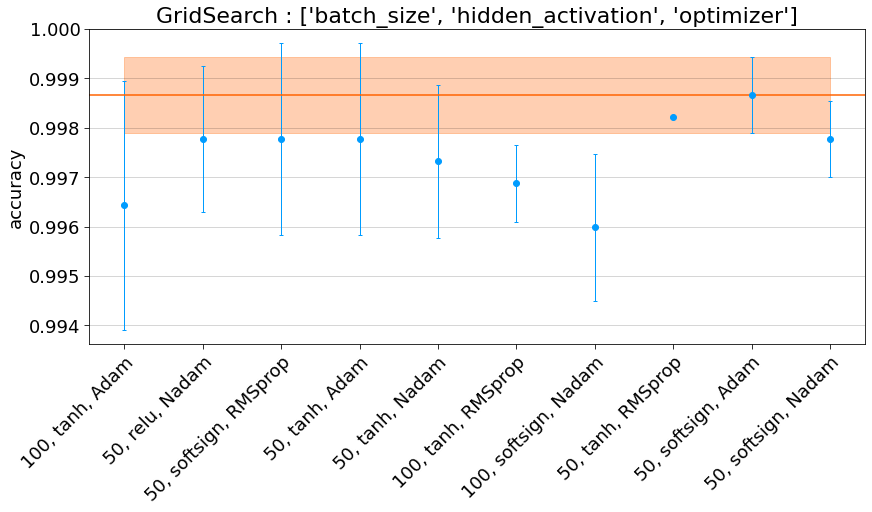

In [ ]:
# print grid search results
grid.print_result()

# plot grid search results
key = ["batch_size", "hidden_activation", "optimizer"]

fig = plt.figure(figsize=(12,7), constrained_layout=True)

ax = plot_utils.plot_gs_results(
    gs_results = [grid.grid_result],
    fig        = fig,
    fontsize   = 18,
    legend     = False,
    title      = f"GridSearch : {key}",
    key        = key,
    fill_box   = True,
    legend_title = None,
    max_comb   = 10
)
ax.grid(axis="y", color="k", alpha=0.2)

plt.show()

Here we plotted only the best 10 combinations of parameters. As three options are totally equivalent we can choose the one that we think will perfrom better on the whole dataset.

In [ ]:
# update the model
model_gridsearch = model_gridsearch.set_params(batch_size=50, hidden_activation='softsign', optimizer='Adam')

#### 2 - Architecture & Dropout parameters 

Firstly, we consider different shapes for out architecture keeping a smiliar number of total neurons. Given *h* and *w* respectively the height and width of the architecture, we consider the following scenarios:

- *h*>>*w*
- *h*<<*w*
- *h*=*w*


In [ ]:
## DIFFERENT NN SHAPES
# list of different shapes: h>>w, h<<w, h=w
neurons        = [ [20,20,1], [4 for i in range(10)]+[1], [6 for i in range(6)]+[1]]
param_grid = dict(neurons = neurons)

# perfrom grid search
grid = gridsearch.GridSearch(x_train, y_train, model_gridsearch, param_grid)
grid.get_result()

GridSearchCV(cv=4,
             estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x7f871a3adb50>,
             n_jobs=-1,
             param_grid={'neurons': [[20, 20, 1],
                                     [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1],
                                     [6, 6, 6, 6, 6, 6, 1]]})

Best: 0.999107 using {'neurons': [20, 20, 1]}
0.999107 (0.000893) with: {'neurons': [20, 20, 1]}
0.987500 (0.003341) with: {'neurons': [6, 6, 6, 6, 6, 6, 1]}
0.914286 (0.022482) with: {'neurons': [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1]}
[2 1 0]


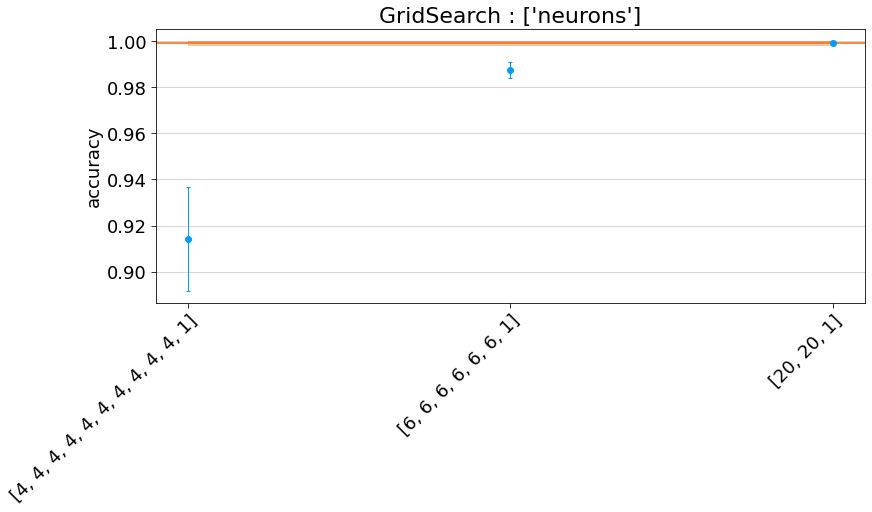

In [ ]:
# print grid search results
grid.print_result()

# plot grid search results
key = ["neurons"]

fig = plt.figure(figsize=(12,7), constrained_layout=True)

ax = plot_utils.plot_gs_results(
    gs_results = [grid.grid_result],
    fig        = fig,
    fontsize   = 18,
    legend     = False,
    title      = f"GridSearch : {key}",
    key        = key,
    fill_box   = True,
    legend_title = None
)
ax.grid(axis="y", color="k", alpha=0.2)

plt.show()

It's clear how the *h*>>*w* shape is preferred over the other possibilities. Now we can consider different number of neurons keeping the shape fixed.

In [ ]:
## DIFFERENT number of NEURONS
# parameter list
neurons        = [[5,5,1], [20,20,1], [100,100,1], [500,500,1]]
param_grid = dict(neurons = neurons)

# perform grid search
grid = gridsearch.GridSearch(x_train, y_train, model_gridsearch, param_grid)
grid.get_result()

GridSearchCV(cv=4,
             estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x7f871a3adb50>,
             n_jobs=-1,
             param_grid={'neurons': [[5, 5, 1], [20, 20, 1], [100, 100, 1],
                                     [500, 500, 1]]})

Best: 0.998661 using {'neurons': [100, 100, 1]}
0.998661 (0.000773) with: {'neurons': [100, 100, 1]}
0.997321 (0.001996) with: {'neurons': [20, 20, 1]}
0.990625 (0.005413) with: {'neurons': [500, 500, 1]}
0.924554 (0.003866) with: {'neurons': [5, 5, 1]}


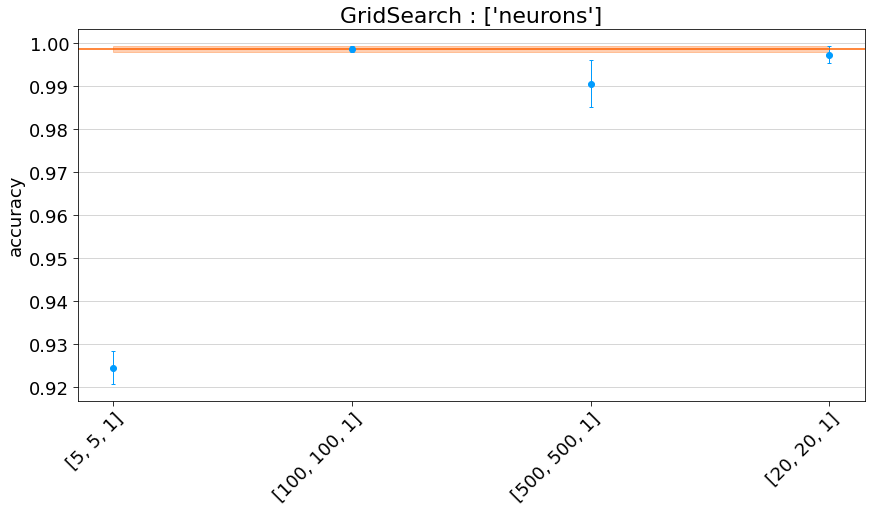

In [ ]:
# print grid search results
grid.print_result()

# plot grid search results
key = ["neurons"]

fig = plt.figure(figsize=(12,7), constrained_layout=True)

ax = plot_utils.plot_gs_results(
    gs_results = [grid.grid_result],
    fig        = fig,
    fontsize   = 18,
    legend     = False,
    title      = f"GridSearch : {key}",
    key        = key,
    fill_box   = True,
    legend_title = None
)
ax.grid(axis="y", color="k", alpha=0.2)

plt.show()

In [ ]:
# update the model
model_gridsearch = model_gridsearch.set_params(neurons=[100, 100, 1])

Once the architecture shape is optimized we can try different values for the dropout parameters, we can apply the dropout with a rate from $0.1$ to $0.5$ after the first layer (input layer is layer 0) or after the second one.

In [ ]:
## DROPOUT PARAMS
# parameters list
dropout_rates        = [[i/10] for i in range(6)]
dropout_layers       = [[1], [2]]
param_grid = dict(dropout_rates        = dropout_rates,
                  dropout_arc          = dropout_layers)

# perfrom grid search
grid = gridsearch.GridSearch(x_train, y_train, model_gridsearch, param_grid)
grid.get_result()

GridSearchCV(cv=4,
             estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x7f23280d4b50>,
             n_jobs=-1,
             param_grid={'dropout_arc': [[1], [2]],
                         'dropout_rates': [[0.0], [0.1], [0.2], [0.3], [0.4],
                                           [0.5]]})

Best: 0.998661 using {'dropout_arc': [1], 'dropout_rates': [0.2]}
0.998661 (0.000773) with: {'dropout_arc': [1], 'dropout_rates': [0.2]}
0.998661 (0.001481) with: {'dropout_arc': [1], 'dropout_rates': [0.3]}
0.997768 (0.000773) with: {'dropout_arc': [1], 'dropout_rates': [0.1]}
0.996875 (0.001946) with: {'dropout_arc': [1], 'dropout_rates': [0.4]}
0.996429 (0.001786) with: {'dropout_arc': [1], 'dropout_rates': [0.5]}
0.991071 (0.002823) with: {'dropout_arc': [2], 'dropout_rates': [0.3]}
0.990625 (0.001481) with: {'dropout_arc': [2], 'dropout_rates': [0.2]}
0.989286 (0.005504) with: {'dropout_arc': [2], 'dropout_rates': [0.5]}
0.989286 (0.002823) with: {'dropout_arc': [2], 'dropout_rates': [0.4]}
0.987946 (0.006726) with: {'dropout_arc': [1], 'dropout_rates': [0.0]}
0.987054 (0.006105) with: {'dropout_arc': [2], 'dropout_rates': [0.0]}
0.985714 (0.003993) with: {'dropout_arc': [2], 'dropout_rates': [0.1]}


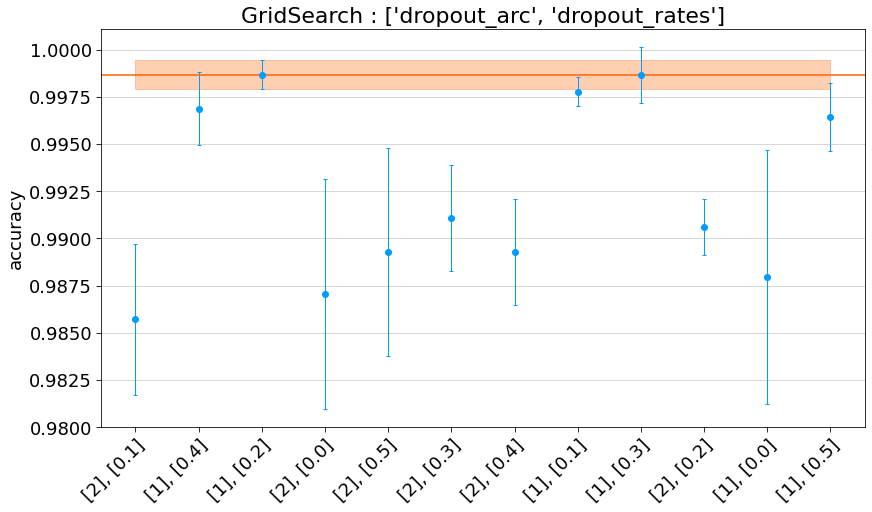

In [ ]:
# print grid search results
grid.print_result()

# plot grid search results
key = ["dropout_arc", "dropout_rates"]

fig = plt.figure(figsize=(12,7), constrained_layout=True)

ax = plot_utils.plot_gs_results(
    gs_results = [grid.grid_result],
    fig        = fig,
    fontsize   = 18,
    legend     = False,
    title      = f"GridSearch : {key}",
    key        = key,
    fill_box   = True,
    legend_title = None
)
ax.grid(axis="y", color="k", alpha=0.2)

plt.show()

The preferred layer after which apply dropout is clearly the first, the lower rates have similar performances.

In [ ]:
# update the model
model_gridsearch = model_gridsearch.set_params(dropout_arc=[1])

In [ ]:
## 2- TOTAL GRID
neurons              = [[100, 100,1], [20,20,1], [500,500,1]]
dropout_rates        = [[i/10] for i in range(1,4)]

param_grid = dict(neurons        = neurons,
                  dropout_rates  = dropout_rates)

# perform grid search
grid = gridsearch.GridSearch(x_train, y_train, model_gridsearch, param_grid)
grid.get_result()

GridSearchCV(cv=4,
             estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x7f23280d4b50>,
             n_jobs=-1,
             param_grid={'dropout_rates': [[0.1], [0.2], [0.3]],
                         'neurons': [[100, 100, 1], [20, 20, 1],
                                     [500, 500, 1]]})

Best: 0.998214 using {'dropout_rates': [0.3], 'neurons': [20, 20, 1]}
0.998214 (0.000000) with: {'dropout_rates': [0.3], 'neurons': [20, 20, 1]}
0.997768 (0.002320) with: {'dropout_rates': [0.2], 'neurons': [100, 100, 1]}
0.996875 (0.001481) with: {'dropout_rates': [0.3], 'neurons': [100, 100, 1]}
0.996875 (0.001481) with: {'dropout_rates': [0.2], 'neurons': [20, 20, 1]}
0.996875 (0.001481) with: {'dropout_rates': [0.1], 'neurons': [100, 100, 1]}
0.996875 (0.001946) with: {'dropout_rates': [0.1], 'neurons': [20, 20, 1]}
0.991964 (0.003892) with: {'dropout_rates': [0.3], 'neurons': [500, 500, 1]}
0.991071 (0.004374) with: {'dropout_rates': [0.2], 'neurons': [500, 500, 1]}
0.988393 (0.001996) with: {'dropout_rates': [0.1], 'neurons': [500, 500, 1]}


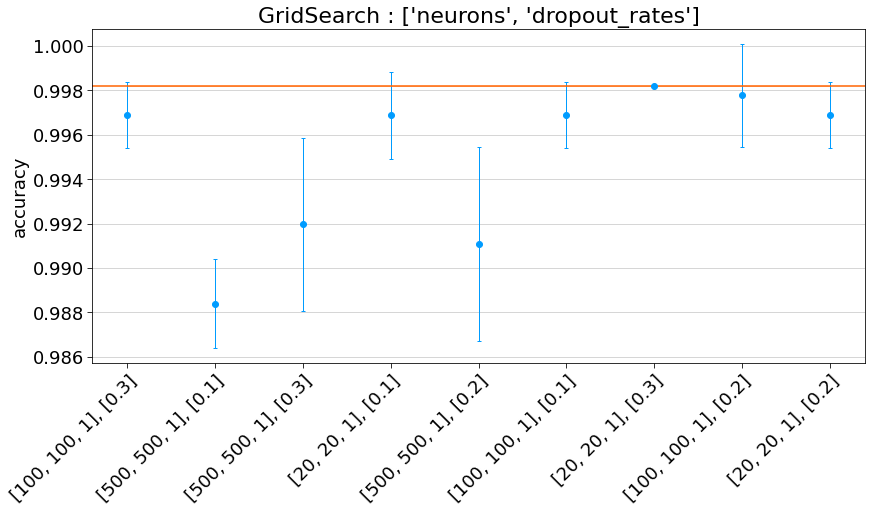

In [ ]:
# print grid search results
grid.print_result()

# plot grid search results
key = ["neurons", "dropout_rates"]

fig = plt.figure(figsize=(12,7), constrained_layout=True)

ax = plot_utils.plot_gs_results(
    gs_results = [grid.grid_result],
    fig        = fig,
    fontsize   = 18,
    legend     = False,
    title      = f"GridSearch : {key}",
    key        = key,
    fill_box   = True,
    legend_title = None
)
ax.grid(axis="y", color="k", alpha=0.2)

plt.show()

In [ ]:
# update the model
model_gridsearch = model_gridsearch.set_params(dropout_rates=[0.3], neurons=[20, 20, 1])

### Fit and evaluate the test set with the best model

Let's have a look at out model after the tuning of its hyperparameters

In [ ]:
# check current model
model_gridsearch.get_params()

{'n_features': 2,
 'epochs': 300,
 'batch_size': 50,
 'hidden_activation': 'softsign',
 'optimizer': 'Adam',
 'dropout_rates': [0.3],
 'neurons': [20, 20, 1],
 'build_fn': <function __main__.create_model(n_features, neurons=[20, 20, 1], dropout_arc=[1], dropout_rates=[0.2], hidden_activation='relu', batch_norm_arc=None, output_activation='sigmoid', name='my lovely neural network', loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])>}

Next we must fit the model over the whole training set

In [ ]:
fit = model_gridsearch.fit(x_train, y_train, validation_data=(x_valid, y_valid), verbose=0)

Here we plot the loss and accuracy computed on the train and test set along the training process.

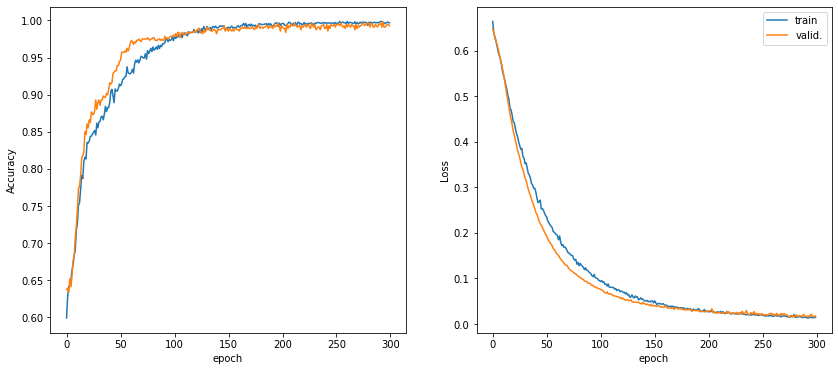

In [ ]:
fig,AX=plt.subplots(1,2,figsize=(14,6.))
ax=AX[0]
ax.plot(fit.history['accuracy'],label="train")
ax.plot(fit.history['val_accuracy'],label="valid.")
ax.set_xlabel('epoch')
ax.set_ylabel("Accuracy")
ax=AX[1]
ax.plot(fit.history['loss'],label="train")
ax.plot(fit.history['val_loss'],label="valid.")
ax.set_xlabel('epoch')
ax.set_ylabel("Loss")
ax.legend()

Then, we can evaluate the effectivness of out optimization procedure predicting the labels of our test set. An immediate outlook of the model performances is provided thanks to the confusion matrix plot.

In [ ]:
y_pred =model_gridsearch.predict(x_test)

pred_binary = y_pred.copy()
pred_binary[y_pred <= 0.5] = 0
pred_binary[y_pred >  0.5] = 1

cm = confusion_matrix(y_test, plot_utils.flatten(pred_binary))

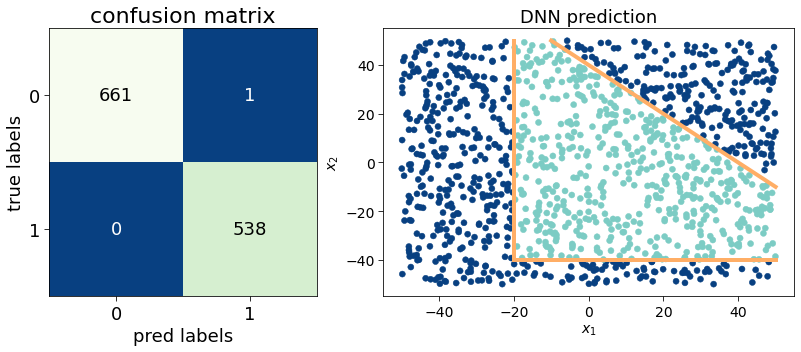

In [ ]:
fig = plt.figure(figsize=(12,5), constrained_layout=True)

# plot confusion matrix
ax = fig.add_subplot(121)

plot_utils.plot_confusion_matrix(
    cm = cm,
    ax = ax,
    title = "confusion matrix"
)
# plot predictions

# scale back x data
mean = np.mean(x, axis=0)
std = np.std(x, axis=0)

ax  = plot_utils.plot_labeled_data(
        x               = x_test*std+mean, 
        labels          = plot_utils.flatten(y_pred), 
        fig             = fig, 
        subplot_id      = 122,
        title           = "DNN prediction", 
        palette         = "GnBu_r",
        hue_norm        = (0, 2),
        fontsize        = 14, 
        legend          = False 
    )
plot_utils.boundaries(ax)
    
plt.show()

## 3 - Check whether any other rescaling of data or initialization of weights may improve the accuracy of the DNN

### Data rescalings

Next, we create identical copies of our dataset and apply a different data rescaling to each one of them. This way, we can test our model behaviour under a change in mean and variance of the same data. 

We thus define three data rescalings, with their implementation located in ```preprocess.py```:

1) No rescaling
2) Standardization
3) Normalization

The first one is as straightforward as it seems: we simply do not apply any rescaling to our data to see whether rescaling input data is relevant to achieve a satisfactory result. The second one, standardization, is probably the most common rescaling scenarios on this kind. It can be translated into a function $std(x)$ as follows:

$$
    x' = std(x) = \frac{x-\bar{x}}{\sigma(x)}
$$

where $\sigma(x)$ is a vector whose components are the standard deviations of $x$ along each of its dimensions. 

The last one instead, normalization, is a simple shift and shrink to fit data into a $\mathcal{D}'\equiv [0,\,1]\times[0,\,1]$ box, namely:

$$
    x' = norm(x) = \frac{x-x_{\text{min}}}{|x_{\text{max}}-x_{\text{min}}|}
$$

where $x_{\text{min}}$ and $x_{\text{max}}$ are vectors of the minimum and maximum values of the input dataset, along each of its dimension, respectively.

A visual representation of the three different input datasets is shown below. 

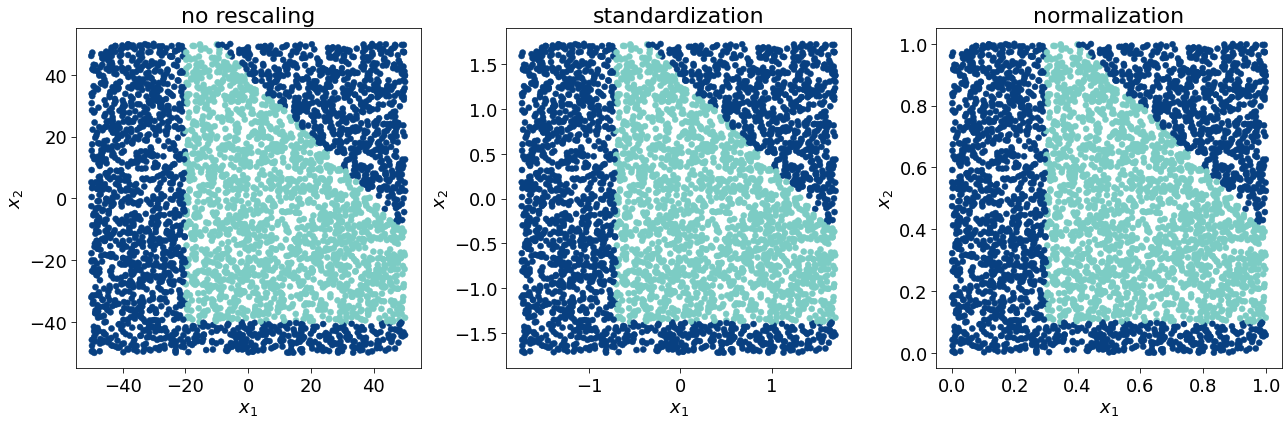

In [ ]:
# number of data
N = 4000
# box size
B = 100

# random seed for reproducibility
np.random.seed(20220308)

x, y_true = create_data.create_data(N, B, c="triang")

mean = np.mean(x, axis=0) 
std  = np.std(x, axis=0)

# no rescaling
x_nr   = np.copy(x)
# standardization
x_std  = preprocess.standardize(x, mean, std)
# normalization
x_norm = preprocess.normalize(x)

dataset = np.array([x_nr, x_std, x_norm])
titles  = ["no rescaling", "standardization", "normalization"]

fig = plt.figure(figsize=(18,6), constrained_layout=True)

for i, data in enumerate(dataset):
    ax  = plot_utils.plot_labeled_data(
        x               = data, 
        labels          = y_true, 
        fig             = fig, 
        subplot_id      = 131+i,
        title           = titles[i], 
        palette         = "GnBu_r",
        hue_norm        = (0, 2),
        fontsize        = 18, 
        legend          = False 
    )
plt.show()

#### Training, test, validation

Now that we have the three differently rescaled datasets we split each of them into three subsets: *training set*, *validation set* and *test set*. These three subsets of the input data are used in different steps of the neural network implementation, namely training, validating and testing the model. 

The key feature of these three subsets is that they are disjoint sets, i.e. they do not share *any* example $x\in\mathcal{D}$ and thus $\mathcal{D}_{\text{train}} \cap \mathcal{D}_{\text{valid}} \cap \mathcal{D}_{\text{test}} = \emptyset$.

In [ ]:
train_test_frac  = 0.7
valid_train_frac = 0.3 

N_train = int(N*train_test_frac*(1-valid_train_frac))
N_valid = int(N*train_test_frac*valid_train_frac)
N_test  = int(N*(1-train_test_frac))

train_idx = N_train
valid_idx = N_train + N_valid
test_idx  = N_train + N_valid + N_test

data_split = {
    "training_set"   : N_train,
    "test_set"       : N_test,
    "validation_set" : N_valid
}

for key, val in data_split.items():
    print(f"{key} \t N = {val}")

training_set      = []
training_labels   = []
test_set          = []
test_labels       = []
validation_set    = []
validation_labels = []

for data in dataset:

    training_set.append(data[0:train_idx])
    training_labels.append(y_true[0:train_idx])

    validation_set.append(data[train_idx:valid_idx])
    validation_labels.append(y_true[train_idx:valid_idx])

    test_set.append(data[valid_idx:test_idx])
    test_labels.append(y_true[valid_idx:test_idx])

training_set 	 N = 1959
test_set 	 N = 1200
validation_set 	 N = 840


#### Neural network hyper-parameters

Now we start implementing the neural network model. First, we define its hyperparameters as the best values we have found using GridSearchCV beforehand.

In [ ]:
N_features = x.shape[1]

## NN hyperparameter

architecture      = [N_features, 20, 20, 1]
dropout_arc       = [1] 
dropout_rates     = [0.3] 
batch_norm_arc    = None   
input_dim         = architecture[0]
hidden_activation = "softsign"
output_activation = "sigmoid"
name              = "neural network"

loss      = "binary_crossentropy"
optimizer = "adam"
metrics   = ["accuracy"]

minibatch = 50
N_epochs  = 300

#### Training

Then we create one model for each of the three rescalings. We train these models using the validation set for an in-training accuracy evaluation on an "unseen" data sample. 

We finally print out the end-of-training loss and accuracy on both the training set and the validation set. On top of that, at the very end of the training procedure, we evaluate the three models on the test set to get a final evaluation of performance. 

In [ ]:
networks    = []
fit_results = []

for i in range(len(dataset)):

    name = f"{titles[i]} network"

    network = nn_model.create_model(
        input_dim         = input_dim,
        architecture      = architecture,
        dropout_layers    = dropout_arc,
        dropout_rates     = dropout_rates,
        batch_norm_layers = batch_norm_arc,
        hidden_activation = hidden_activation,
        output_activation = output_activation,
        loss              = loss,
        optimizer         = optimizer,
        metrics           = metrics,
        nn_name           = name,
    )

    # network.summary()

    t0 = time.time()
    fit = network.fit(
        training_set[i], training_labels[i],
        epochs          = N_epochs,
        batch_size      = minibatch,
        validation_data = (validation_set[i], validation_labels[i]),
        verbose         = 0,
    )
    t1 = time.time()

    test = network.evaluate(
        test_set[i], test_labels[i],
        batch_size      = minibatch,
        verbose         = 0,
    )


    print("="*30)
    print(f"\n{titles[i]} training : {t1-t0:.2f} seconds")

    print(f"\ntraining loss     : {fit.history['loss'][-1]:.5f}")
    print(f"training accuracy : {fit.history['accuracy'][-1]:.5f}")

    print(f"\nvalid loss        : {fit.history['val_loss'][-1]:.5f}")
    print(f"valid accuracy    : {fit.history['val_accuracy'][-1]:.5f}\n")

    print(f"\n{titles[i]} testing")

    print(f"\ntest loss         : {test[0]:.5f}")
    print(f"test accuracy     : {test[1]:.5f}\n")

    print("="*30)

    networks.append(network)
    fit_results.append(fit)


no rescaling training : 27.96 seconds

training loss     : 0.05844
training accuracy : 0.97907

valid loss        : 0.04587
valid accuracy    : 0.98333


no rescaling testing

test loss         : 0.02705
test accuracy     : 0.99333


standardization training : 41.40 seconds

training loss     : 0.02002
training accuracy : 0.99643

valid loss        : 0.02020
valid accuracy    : 0.99286


standardization testing

test loss         : 0.01321
test accuracy     : 0.99917


normalization training : 41.41 seconds

training loss     : 0.05784
training accuracy : 0.98264

valid loss        : 0.04211
valid accuracy    : 0.98452


normalization testing

test loss         : 0.03360
test accuracy     : 0.99750



After that, we plot the accuracy and the loss over the training epochs for both the training and the validation set, color-coded by data rescalings. 

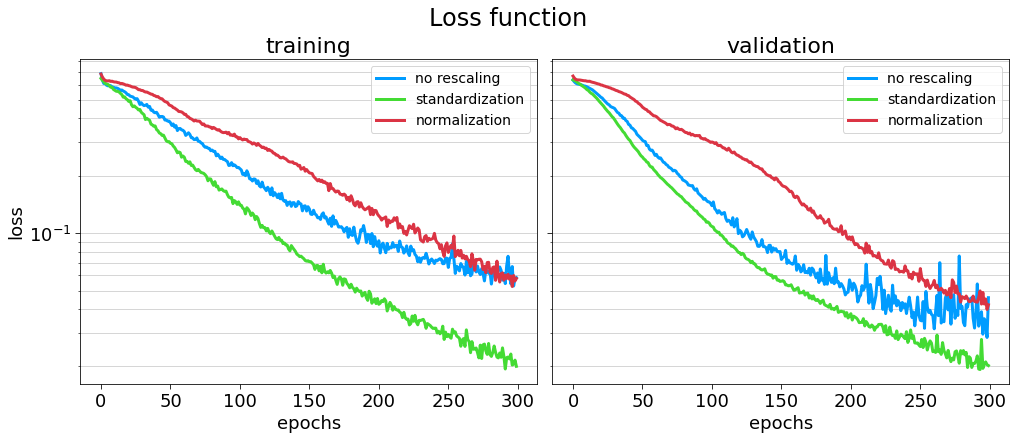

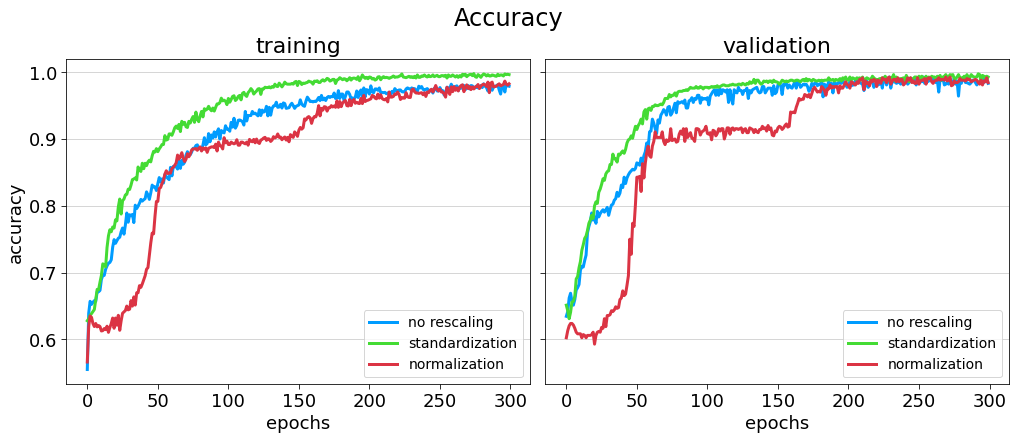

In [ ]:
palette = {
    "no rescaling"   : ["#009cff", "#ff6300"],
    "standardization": ["#44db34", "#cb34db"],
    "normalization"  : ["#db3444", "#7834db"]
}

fig, (ax1, ax2) = plt.subplots(
    nrows              = 1, 
    ncols              = 2, 
    sharex             = "all", 
    sharey             = "all",
    figsize            = (14,6), 
    constrained_layout = True
)
fig.suptitle("Loss function", fontsize=24)

ax1.grid(axis="y", color="k", alpha=0.2, which="both")
ax2.grid(axis="y", color="k", alpha=0.2, which="both")

for i, fit in enumerate(fit_results):

    ax1 = plot_utils.plot_loss(
        epochs     = N_epochs,
        loss       = fit.history["loss"],
        fig        = fig,
        ax         = ax1,
        color      = palette[titles[i]][0],
        loss_label = "loss",
        title      = "training",
        label      = f"{titles[i]}",
    )
    ax2 = plot_utils.plot_loss(
        epochs = N_epochs,
        loss   = fit.history["val_loss"],
        fig    = fig,
        ax     = ax2,
        color  = palette[titles[i]][0],
        title  = "validation",
        label  = f"{titles[i]}",
    )

ax1.set_yscale("log")

plt.show()


## ====================================================##


fig, (ax1, ax2) = plt.subplots(
    nrows              = 1, 
    ncols              = 2, 
    sharex             = "all", 
    sharey             = "all",
    figsize            = (14,6), 
    constrained_layout = True
)
fig.suptitle("Accuracy", fontsize=24)

ax1.grid(axis="y", color="k", alpha=0.2)
ax2.grid(axis="y", color="k", alpha=0.2)

for i, fit in enumerate(fit_results):

    ax1 = plot_utils.plot_metric(
        epochs       = N_epochs,
        metric       = fit.history["accuracy"],
        fig          = fig,
        ax           = ax1,
        color        = palette[titles[i]][0],
        metric_label = "accuracy",
        title        = "training",
        label        = f"{titles[i]}",
    )
    ax2 = plot_utils.plot_metric(
        epochs       = N_epochs,
        metric       = fit.history["val_accuracy"],
        fig          = fig,
        ax           = ax2,
        color        = palette[titles[i]][0],
        title        = "validation",
        label        = f"{titles[i]}",
    )

ax1.set_yscale("linear")

plt.show()

We see that the standardization rescaling leads to an overall faster and more accurate model. 

### Weights and biases

Now we also plot a layer-by-layer histogram of weights and biases to check whether there are significant differences between different data rescalings.

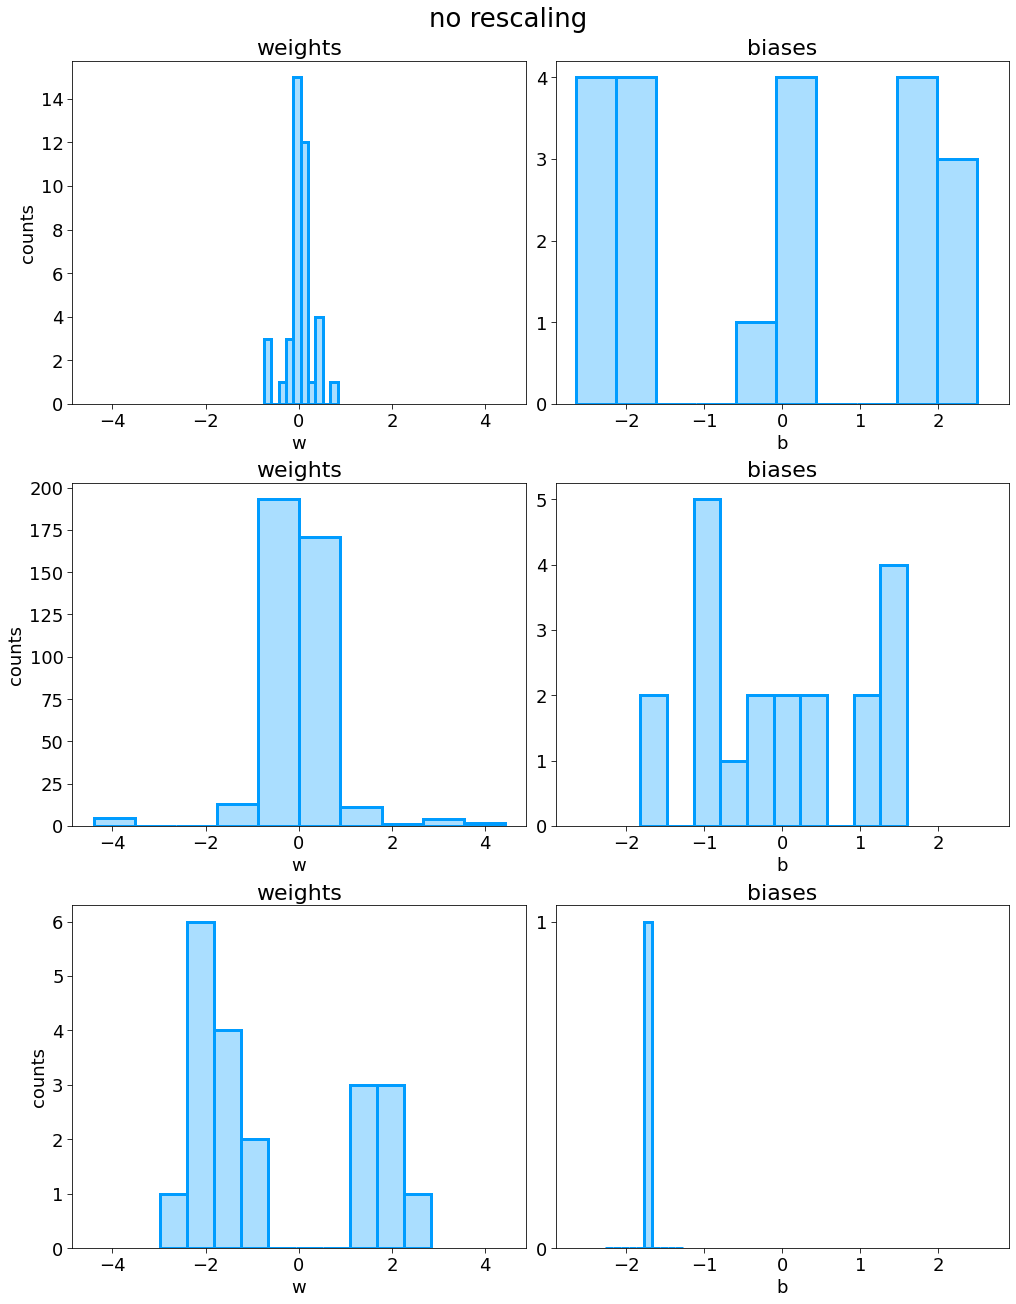

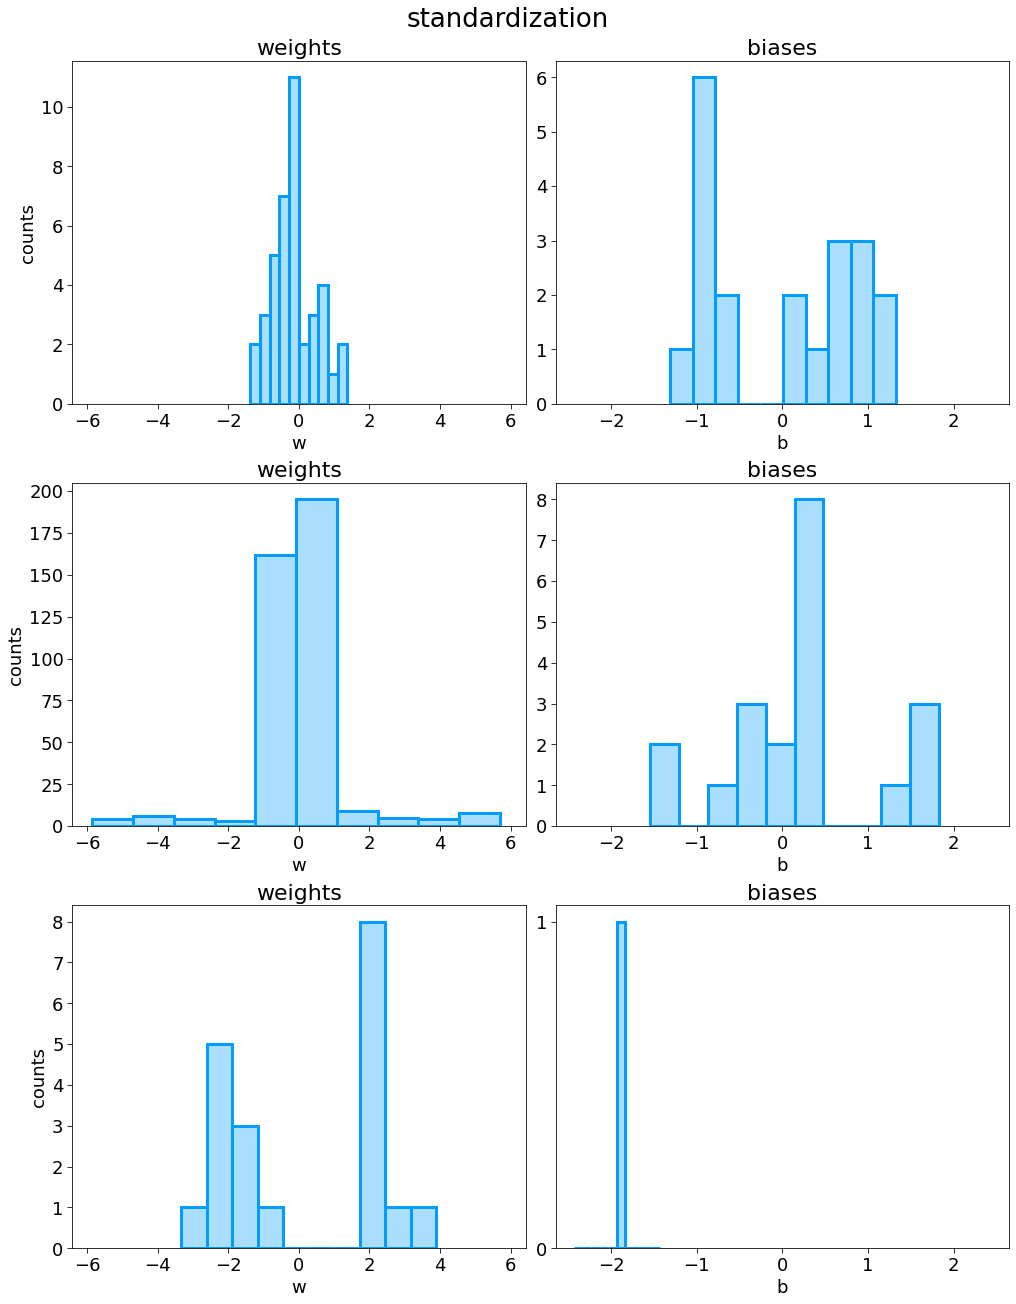

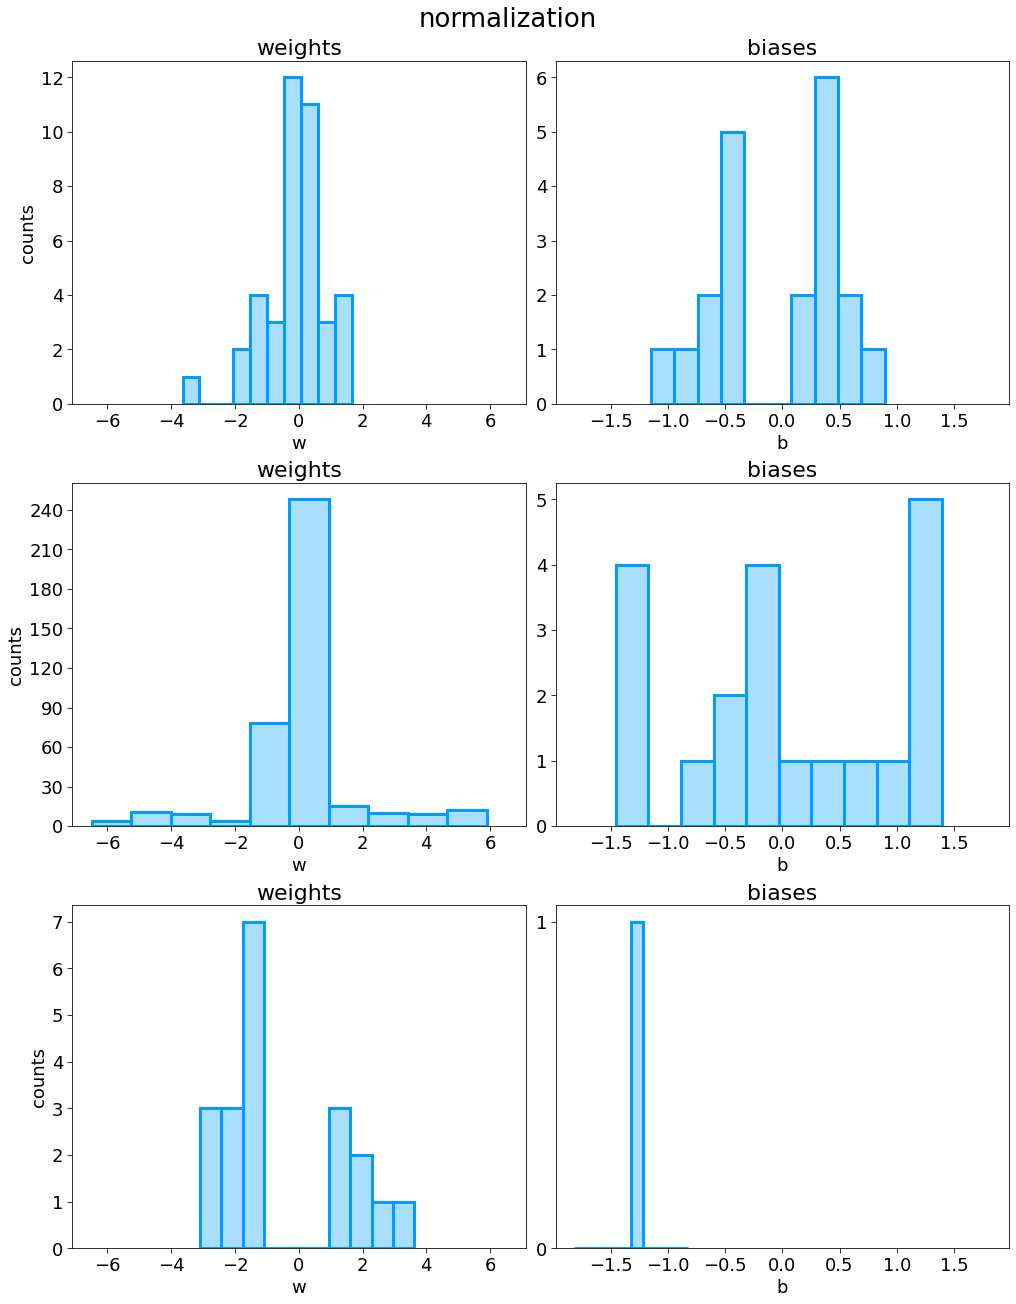

In [ ]:
for i, network in enumerate(networks):

    weights = network.get_weights()

    axes = plot_utils.plot_weights(
        weights  = weights,
        figsize  = (14, 18),
        suptitle = titles[i],
    )

    plt.show()

We cannot detect any significant differences in the weights distributions, as they all share approximately the same range of variability. Notice that this range becomes bigger as we advance into the following layers due to the ReLU activation function. 

### Neural network predictions on *test set*

Finally, we can use our trained models to predict the labels of the test sets. This allows us to build confusion matrices and compute the *sensitivity* and *specificity* of our models. In other words, we want to quantitatively assess how well our models perform on unseen data, and we aim to do so by checking true positives, true negatives, false positives and false negatives rates. 

In [ ]:
predictions        = []
binary_predictions = []
confusion_matrices = []

for i in range(len(dataset)):

    y_pred = networks[i].predict(test_set[i])
    predictions.append(plot_utils.flatten(y_pred))

    pred_binary = y_pred.copy()
    pred_binary[y_pred <= 0.5] = 0
    pred_binary[y_pred >  0.5] = 1
    binary_predictions.append(plot_utils.flatten(pred_binary))

    cm = confusion_matrix(test_labels[i], plot_utils.flatten(pred_binary))
    confusion_matrices.append(cm)

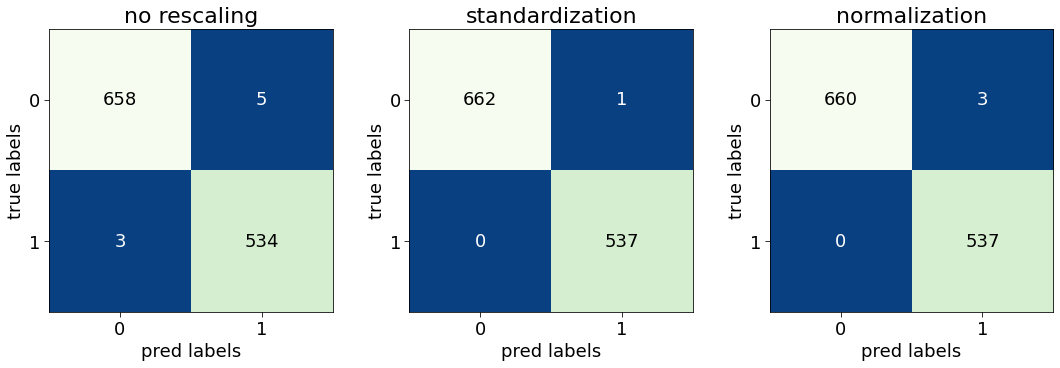

In [ ]:
labels = [0, 1]
fontsize=18

fig = plt.figure(figsize=(15,5), constrained_layout=True)

for i, cm in enumerate(confusion_matrices):

    ax = fig.add_subplot(131+i)

    total_0, total_1 =  np.sum(cm, axis=1)
 
    cm_norm_0 = cm[0]/total_0
    cm_norm_1 = cm[1]/total_1

    cm_norm = np.vstack((cm_norm_0, cm_norm_1))

    plot_utils.plot_confusion_matrix(
        cm = cm,
        ax = ax,
        title = titles[i]
    )
    

plt.show()

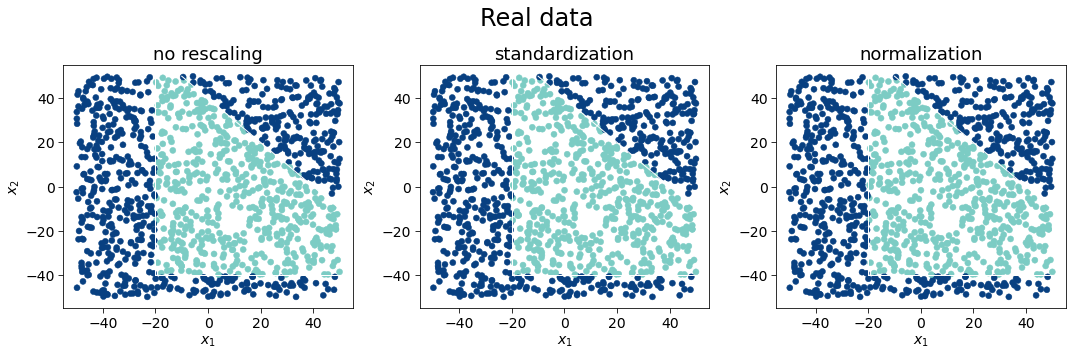

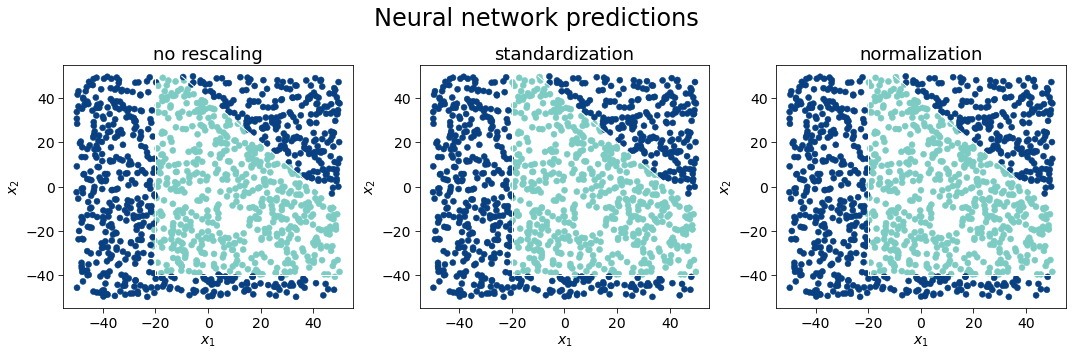

In [ ]:
fig1 = plt.figure(figsize=(15,5))
fig1.suptitle("Real data", fontsize=24)
fig2 = plt.figure(figsize=(15,5))
fig2.suptitle("Neural network predictions", fontsize=24)
for i in range(len(dataset)):

    ax = plot_utils.plot_labeled_data(
        x               = test_set[0], 
        labels          = test_labels[i],
        fig             = fig1, 
        subplot_id      = 131+i,
        title           = titles[i], 
        palette         = "GnBu_r",
        hue_norm        = (0, 2),
        fontsize        = 14, 
        legend          = False 
    )
    plot_utils.boundaries(ax, lw=1, color="w")

    ax = plot_utils.plot_labeled_data(
        x               = test_set[0], 
        labels          = binary_predictions[i], 
        fig             = fig2, 
        subplot_id      = 131+i,
        title           = titles[i], 
        palette         = "GnBu_r",
        hue_norm        = (0, 2),
        fontsize        = 14, 
        legend          = False 
    )
    plot_utils.boundaries(ax, lw=1, color="w")


plt.show()

### Weights initializers

In this section we check whether different weights initializations lead to sensibily different results. 

The initializers we test are:

1) RandomNormal
2) RandomUniform
3) TruncatedNormal
4) GlorotNormal
5) GlorotUniform
6) HeNormal
7) HeUniform

A detailed description of these kernel initializers can be found [here](https://keras.io/api/layers/initializers/). 


#### Neural network hyper-parameters

Here we set the neural network hyperparameters and create a list with aliases for the weights initializers reported above.

In [ ]:
N_features = x.shape[1]

## NN hyperparameter

architecture      = [N_features, 20, 20, 1]
dropout_arc       = [1] # [2]
dropout_rates     = [0.3] # [0.2]
batch_norm_arc    = None # [2]   
input_dim         = architecture[0]
hidden_activation = "softsign"
output_activation = "sigmoid"
name              = "my lovely neural network"

loss      = "binary_crossentropy"
optimizer = "adam"
metrics   = [
    tf.keras.metrics.Accuracy(name="accuracy"),
]

# list of initializers 
initializer_list = [
    "random_normal",
    "random_uniform",
    "truncated_normal",
    "glorot_normal",
    "glorot_uniform",
    "he_normal",
    "he_uniform",
    # "zeros",
    # "ones",
]

### GridSearch cross validation

Now, for each data rescaling (no rescaling, standardiation and normalization), we exploit

1) ```sklearn.model_selection.GridSearchCV```
2) ```keras.wrappers.scikit_learn.KerasClassifier```

to implement a grid search over the weights initializers list. 

The output of the following cell will contain the score for each kernel initializer.

In [ ]:
N_epochs  = 300
minibatch = 50

grid_search_results = []

gs_means, gs_stds, gs_params = [], [], []

predictions        = []
binary_predictions = []

confusion_matrices = []

for i in range(len(dataset)):

    model_gridsearch = KerasClassifier(
        build_fn          = nn_model.create_model, 
        input_dim         = input_dim,
        architecture      = architecture,
        epochs            = N_epochs, 
        batch_size        = minibatch
    )

    param_grid = dict(initializer = initializer_list)

    grid_search = GridSearchCV(estimator=model_gridsearch, param_grid=param_grid, n_jobs=-1, cv=4)

    grid_result = grid_search.fit(
        training_set[i], training_labels[i],
        # batch_size = minibatch,
        verbose    = 0,
    )

    grid_search_results.append(grid_result)


    # summarize results
    print("="*30)
    print()
    print(titles[i])
    print()
    print("Best model    : %.4f using %s" % (grid_result.best_score_, grid_result.best_params_))
    print()

    means  = grid_result.cv_results_['mean_test_score']
    stds   = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']

    gs_means.append(means)
    gs_stds.append(stds)
    gs_params.append(params)

    for mean, stdev, param in zip(means, stds, params):
        print("%.4f (%.4f) with: %r" % (mean, stdev, param))
    print()
    print("="*30)

    

    # y_pred = grid_search.predict(test_set[i])
    # predictions.append(plot_utils.flatten(y_pred))

    # pred_binary = y_pred.copy()
    # pred_binary[y_pred <= 0.5] = 0
    # pred_binary[y_pred >  0.5] = 1
    # binary_predictions.append(plot_utils.flatten(pred_binary))

    # cm = confusion_matrix(test_labels[i], plot_utils.flatten(pred_binary))
    # confusion_matrices.append(cm)


no rescaling

Best model    : 0.9898 using {'initializer': 'random_uniform'}

0.9837 (0.0081) with: {'initializer': 'random_normal'}
0.9898 (0.0071) with: {'initializer': 'random_uniform'}
0.9842 (0.0081) with: {'initializer': 'truncated_normal'}
0.9857 (0.0096) with: {'initializer': 'glorot_normal'}
0.9857 (0.0052) with: {'initializer': 'glorot_uniform'}
0.9704 (0.0065) with: {'initializer': 'he_normal'}
0.9735 (0.0085) with: {'initializer': 'he_uniform'}


standardization

Best model    : 0.9949 using {'initializer': 'glorot_uniform'}

0.9944 (0.0039) with: {'initializer': 'random_normal'}
0.9908 (0.0092) with: {'initializer': 'random_uniform'}
0.9939 (0.0029) with: {'initializer': 'truncated_normal'}
0.9934 (0.0046) with: {'initializer': 'glorot_normal'}
0.9949 (0.0034) with: {'initializer': 'glorot_uniform'}
0.9944 (0.0026) with: {'initializer': 'he_normal'}
0.9918 (0.0083) with: {'initializer': 'he_uniform'}


normalization

Best model    : 0.9959 using {'initializer': 'random_un

### GridSearch results

To gain a better understanding of the grid search results, it is better to visualize the returned scores.

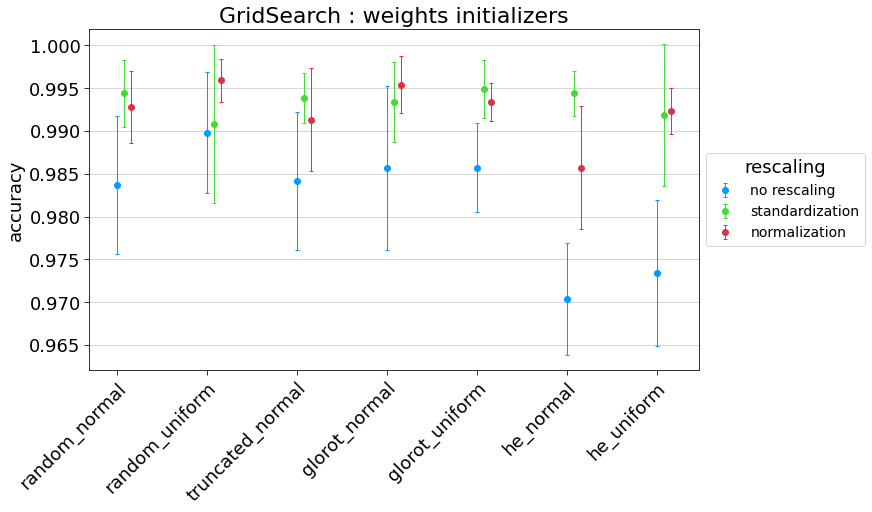

In [ ]:
fig = plt.figure(figsize=(12,7), constrained_layout=True)

ax = plot_utils.plot_gs_results(
    gs_results = grid_search_results,
    fig        = fig,
    fontsize   = 18,
    colors     = palette,
    labels     = titles,
    legend     = True,
    title      = "GridSearch : weights initializers"
)
ax.grid(axis="y", color="k", alpha=0.2)

plt.show()

### Training the best model

Next we take the best model, i.e. we set the weights initializer to the one that had the highest accuracy in the previous grid search, and train the model again. This because when running ```sklearn.model_selection.GridSearchCV.fit()``` models created do not see the whole training set. 

In [ ]:
N_features = x.shape[1]

## NN hyperparameter

architecture      = [N_features, 20, 20, 1]
dropout_arc       = [1] # [1]
dropout_rates     = [0.3] # [0.2]
batch_norm_arc    = None # [2]   
input_dim         = architecture[0]
hidden_activation = "softsign"
output_activation = "sigmoid"
name              = "my lovely neural network"

loss      = "binary_crossentropy"
optimizer = "adam"
metrics   = ["accuracy"]
initializer_list = [
    "random_uniform",
    "glorot_uniform",
    "random_uniform",
]

minibatch = 50
N_epochs  = 300

In [ ]:
networks    = []
fit_results = []

for i in range(len(dataset)):

    name = f"{titles[i]} network"

    network = nn_model.create_model(
        input_dim         = input_dim,
        architecture      = architecture,
        dropout_layers    = dropout_arc,
        dropout_rates     = dropout_rates,
        batch_norm_layers = batch_norm_arc,
        hidden_activation = hidden_activation,
        output_activation = output_activation,
        loss              = loss,
        optimizer         = optimizer,
        initializer       = initializer_list[i],
        metrics           = metrics,
        nn_name           = name,
    )

    # network.summary()

    t0 = time.time()
    fit = network.fit(
        training_set[i], training_labels[i],
        epochs          = N_epochs,
        batch_size      = minibatch,
        validation_data = (validation_set[i], validation_labels[i]),
        verbose         = 0,
    )
    t1 = time.time()

    test = network.evaluate(
        test_set[i], test_labels[i],
        batch_size      = minibatch,
        verbose         = 0,
    )


    print("="*30)
    print(f"\n{titles[i]} training : {t1-t0:.2f} seconds")

    print(f"\ntraining loss     : {fit.history['loss'][-1]:.5f}")
    print(f"training accuracy : {fit.history['accuracy'][-1]:.5f}")

    print(f"\nvalid loss        : {fit.history['val_loss'][-1]:.5f}")
    print(f"valid accuracy    : {fit.history['val_accuracy'][-1]:.5f}\n")

    print(f"\n{titles[i]} testing")

    print(f"\ntest loss         : {test[0]:.5f}")
    print(f"test accuracy     : {test[1]:.5f}\n")

    print("="*30)

    networks.append(network)
    fit_results.append(fit)


no rescaling training : 27.82 seconds

training loss     : 0.04334
training accuracy : 0.98264

valid loss        : 0.02233
valid accuracy    : 0.99286


no rescaling testing

test loss         : 0.02527
test accuracy     : 0.99167


standardization training : 41.41 seconds

training loss     : 0.01661
training accuracy : 0.99490

valid loss        : 0.01673
valid accuracy    : 0.99524


standardization testing

test loss         : 0.01002
test accuracy     : 0.99833


normalization training : 27.55 seconds

training loss     : 0.15307
training accuracy : 0.95661

valid loss        : 0.12703
valid accuracy    : 0.96429


normalization testing

test loss         : 0.12348
test accuracy     : 0.97167



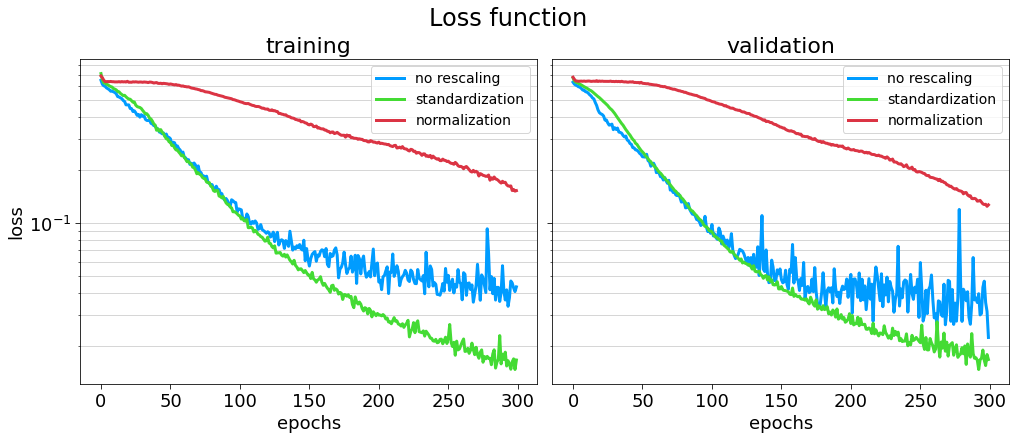

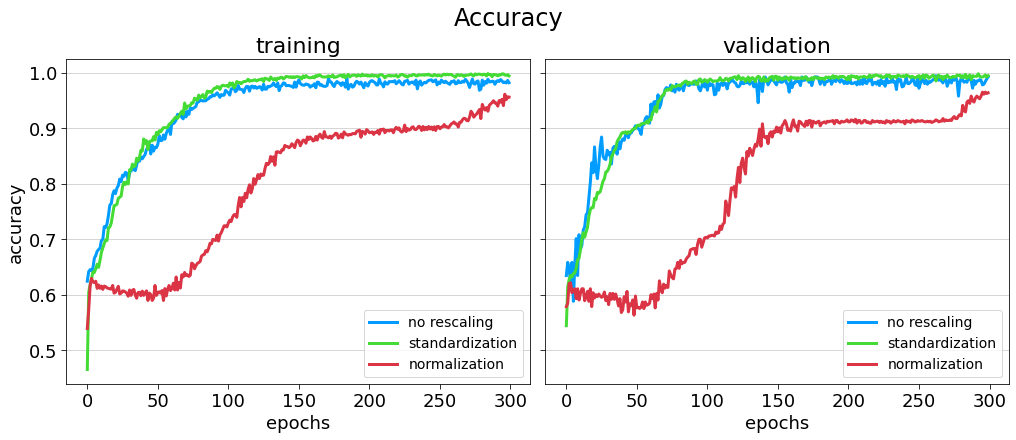

In [ ]:
palette = {
    "no rescaling"   : ["#009cff", "#ff6300"],
    "standardization": ["#44db34", "#cb34db"],
    "normalization"  : ["#db3444", "#7834db"]
}

fig, (ax1, ax2) = plt.subplots(
    nrows              = 1, 
    ncols              = 2, 
    sharex             = "all", 
    sharey             = "all",
    figsize            = (14,6), 
    constrained_layout = True
)
fig.suptitle("Loss function", fontsize=24)

ax1.grid(axis="y", color="k", alpha=0.2, which="both")
ax2.grid(axis="y", color="k", alpha=0.2, which="both")

for i, fit in enumerate(fit_results):

    ax1 = plot_utils.plot_loss(
        epochs     = N_epochs,
        loss       = fit.history["loss"],
        fig        = fig,
        ax         = ax1,
        color      = palette[titles[i]][0],
        loss_label = "loss",
        title      = "training",
        label      = f"{titles[i]}",
    )
    ax2 = plot_utils.plot_loss(
        epochs = N_epochs,
        loss   = fit.history["val_loss"],
        fig    = fig,
        ax     = ax2,
        color  = palette[titles[i]][0],
        title  = "validation",
        label  = f"{titles[i]}",
    )

ax1.set_yscale("log")

plt.show()


## ====================================================##


fig, (ax1, ax2) = plt.subplots(
    nrows              = 1, 
    ncols              = 2, 
    sharex             = "all", 
    sharey             = "all",
    figsize            = (14,6), 
    constrained_layout = True
)
fig.suptitle("Accuracy", fontsize=24)

ax1.grid(axis="y", color="k", alpha=0.2)
ax2.grid(axis="y", color="k", alpha=0.2)

for i, fit in enumerate(fit_results):

    ax1 = plot_utils.plot_metric(
        epochs       = N_epochs,
        metric       = fit.history["accuracy"],
        fig          = fig,
        ax           = ax1,
        color        = palette[titles[i]][0],
        metric_label = "accuracy",
        title        = "training",
        label        = f"{titles[i]}",
    )
    ax2 = plot_utils.plot_metric(
        epochs       = N_epochs,
        metric       = fit.history["val_accuracy"],
        fig          = fig,
        ax           = ax2,
        color        = palette[titles[i]][0],
        title        = "validation",
        label        = f"{titles[i]}",
    )

ax1.set_yscale("linear")

plt.show()

We see in the figures above that now the "normalization" rescaling behaves poorly. Instead, the "no rescaling" option performs quite better than the non-optimized case that has been shown in the last section. The "standardization" rescaling is the most consistent and most accurate in any scenario. 

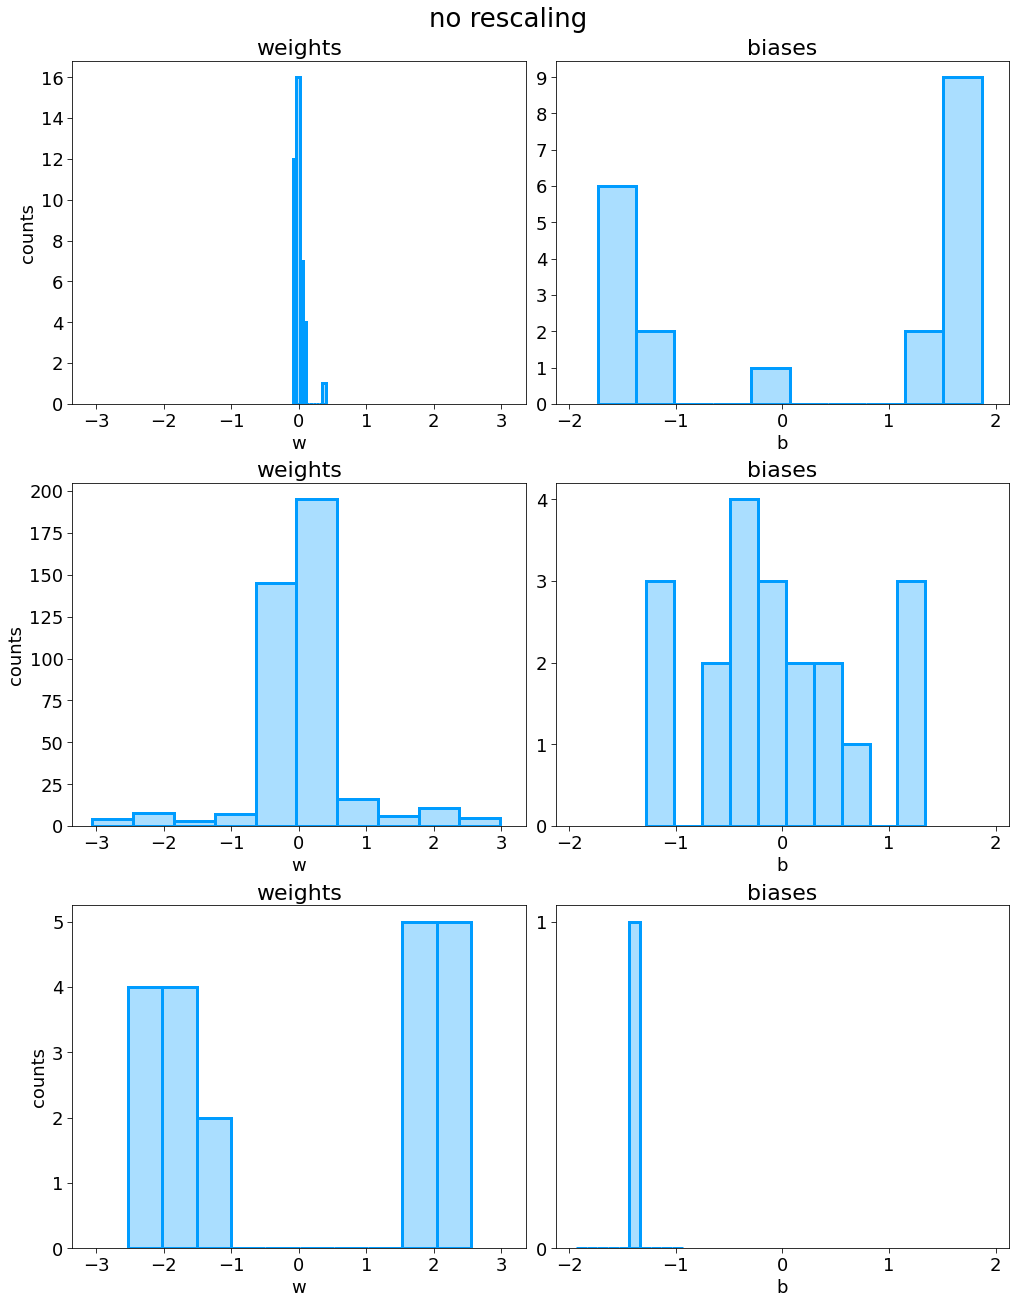

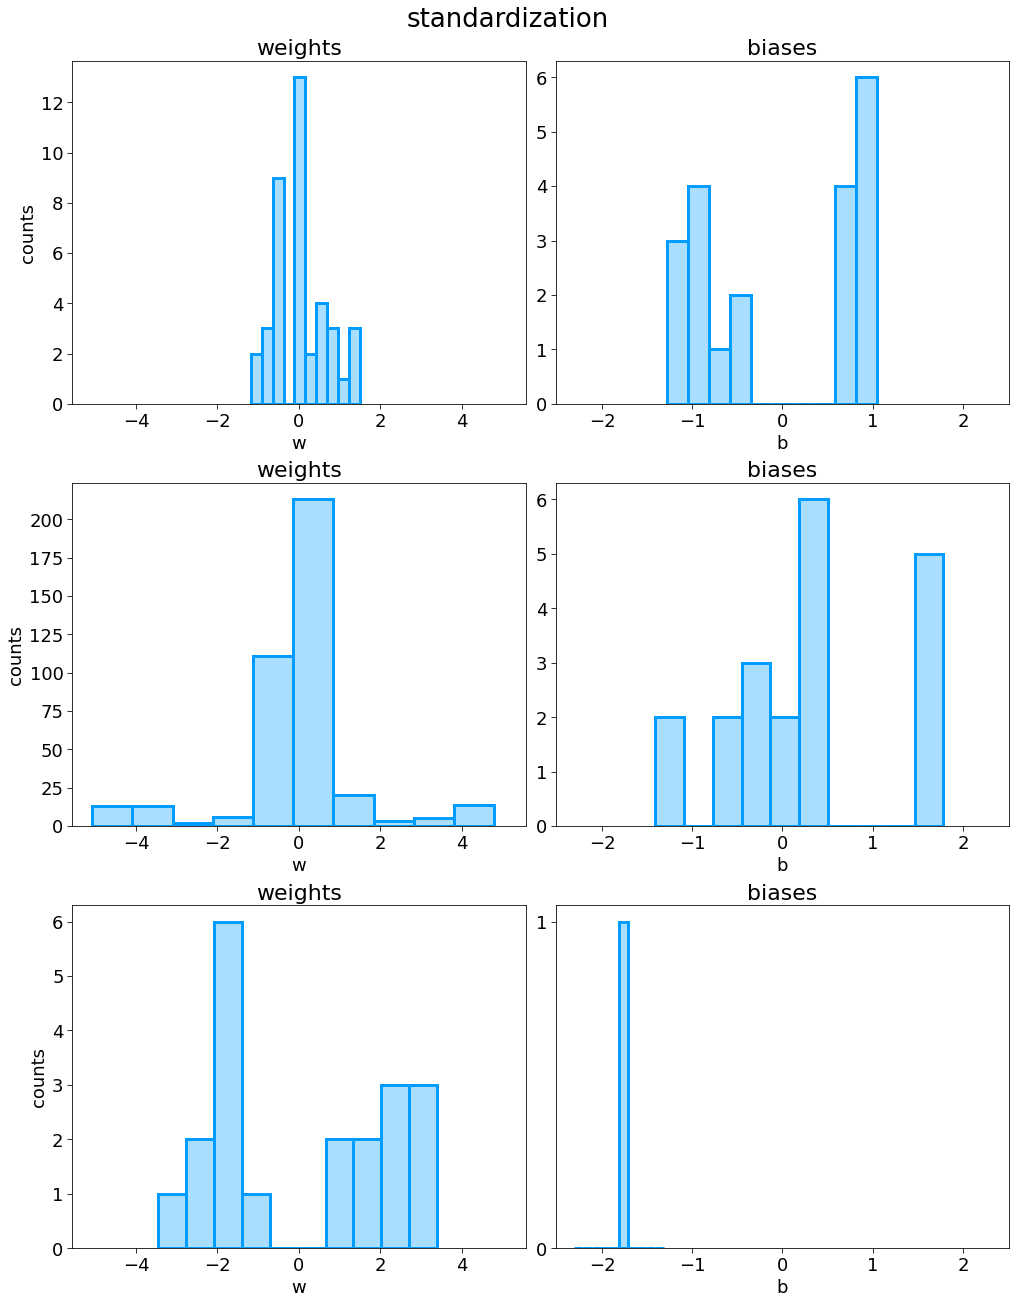

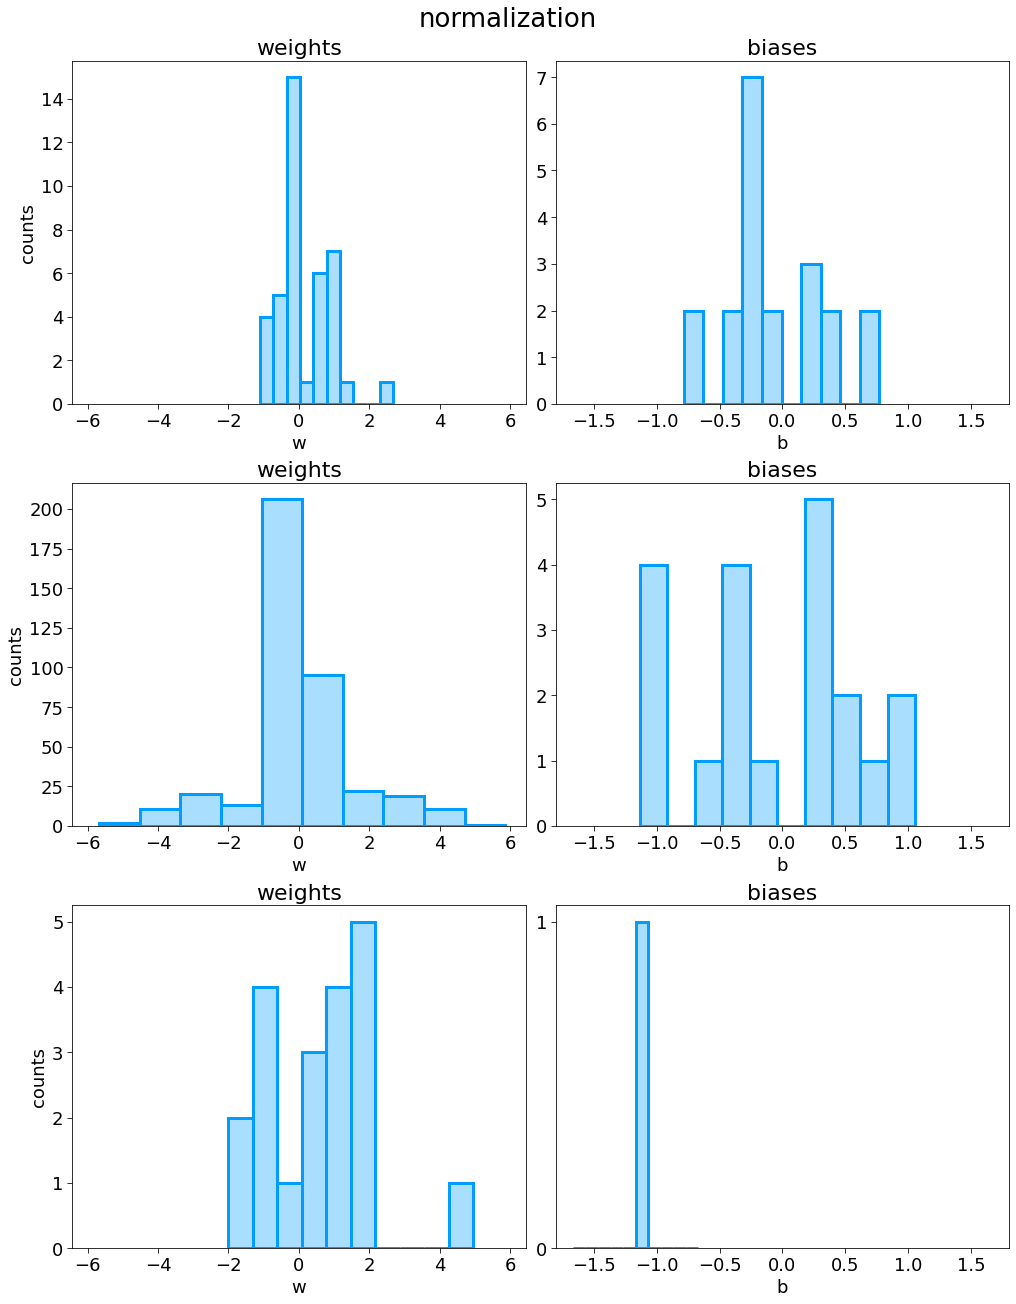

In [ ]:
for i, network in enumerate(networks):

    weights = network.get_weights()

    axes = plot_utils.plot_weights(
        weights  = weights,
        figsize  = (14, 18),
        suptitle = titles[i],
    )

    plt.show()

In the previous histograms of weights we clearly see the influence of different initializers, but the overall increasing width of the histogram persists as we noticed in the last section.

### Neural network predictions

Finally we predict labels on the test set and compute confusion matrices to check the prediction performance.

In [ ]:
predictions        = []
binary_predictions = []
confusion_matrices = []

for i in range(len(dataset)):

    y_pred = networks[i].predict(test_set[i])
    predictions.append(plot_utils.flatten(y_pred))

    pred_binary = y_pred.copy()
    pred_binary[y_pred <= 0.5] = 0
    pred_binary[y_pred >  0.5] = 1
    binary_predictions.append(plot_utils.flatten(pred_binary))

    cm = confusion_matrix(test_labels[i], plot_utils.flatten(pred_binary))
    confusion_matrices.append(cm)

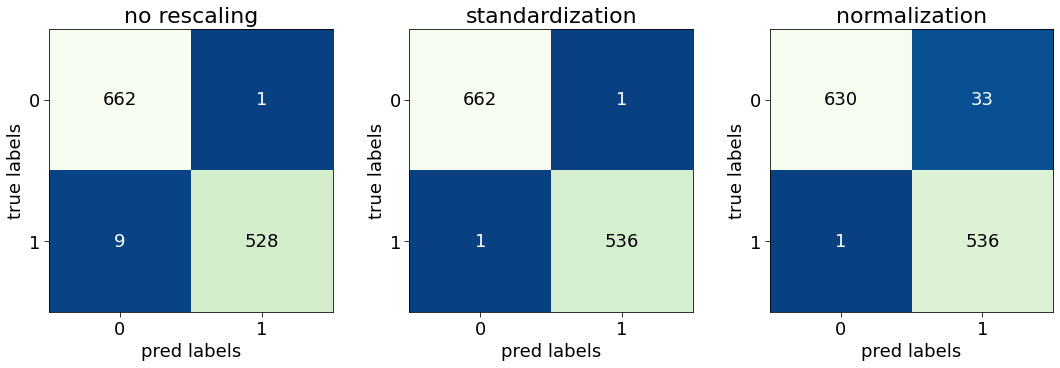

In [ ]:
labels = [0, 1]
fontsize=18

fig = plt.figure(figsize=(15,5), constrained_layout=True)

for i, cm in enumerate(confusion_matrices):

    ax = fig.add_subplot(131+i)

    total_0, total_1 =  np.sum(cm, axis=1)
 
    cm_norm_0 = cm[0]/total_0
    cm_norm_1 = cm[1]/total_1

    cm_norm = np.vstack((cm_norm_0, cm_norm_1))

    plot_utils.plot_confusion_matrix(
        cm = cm,
        ax = ax,
        title = titles[i]
    )
    

plt.show()

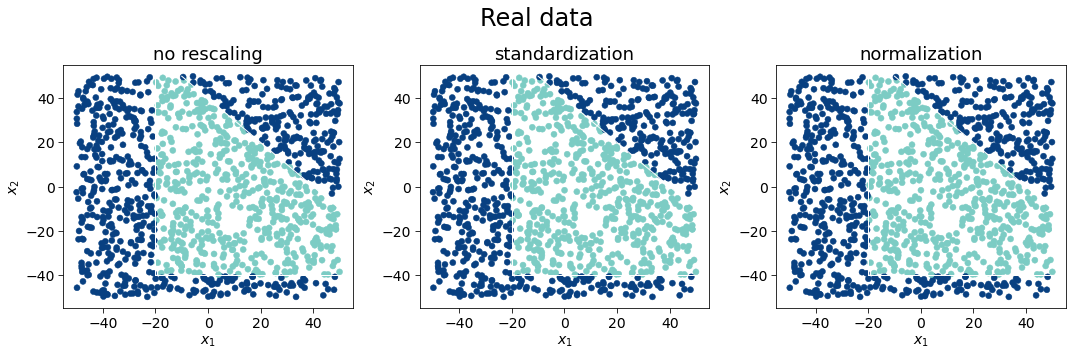

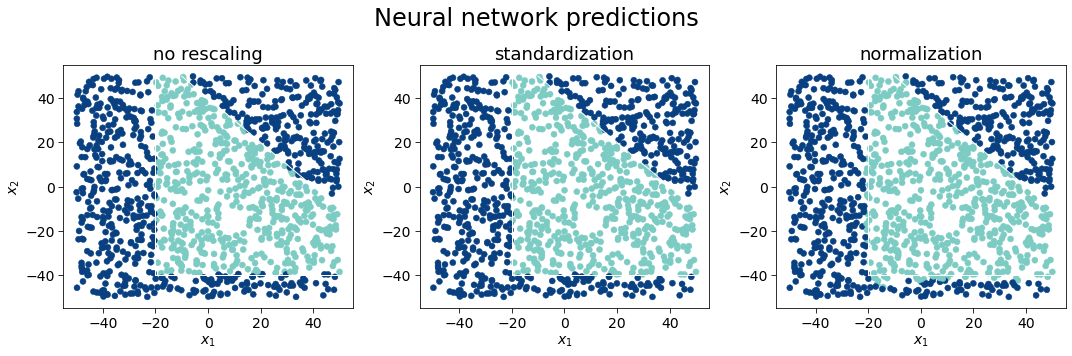

In [ ]:
fig1 = plt.figure(figsize=(15,5))
fig1.suptitle("Real data", fontsize=24)
fig2 = plt.figure(figsize=(15,5))
fig2.suptitle("Neural network predictions", fontsize=24)
for i in range(len(dataset)):

    ax = plot_utils.plot_labeled_data(
        x               = test_set[0], 
        labels          = test_labels[i],
        fig             = fig1, 
        subplot_id      = 131+i,
        title           = titles[i], 
        palette         = "GnBu_r",
        hue_norm        = (0, 2),
        fontsize        = 14, 
        legend          = False 
    )
    plot_utils.boundaries(ax, lw=1, color="w")

    ax = plot_utils.plot_labeled_data(
        x               = test_set[0], 
        labels          = binary_predictions[i], 
        fig             = fig2, 
        subplot_id      = 131+i,
        title           = titles[i], 
        palette         = "GnBu_r",
        hue_norm        = (0, 2),
        fontsize        = 14, 
        legend          = False 
    )
    plot_utils.boundaries(ax, lw=1, color="w")


plt.show()

## 4 - Study different data

Finally we check the behaviour of the best model on different distributions of data. Mainly we check if the DNN performances are optimal also when:

1) Changing shape of data
2) Increasing the number of boundaries
3) Increasing data dimensionality

### 4.0) Defining NNs
In this section a list of NNs used in the following is created


In [ ]:
## NN hyperparameters

dropout_arc       = [1] 
dropout_rates     = [0.3] 
batch_norm_arc    = None   
input_dims        = [2, 2] + [ i for i in range(3, 21)]
hidden_activation = "softsign"
output_activation = "sigmoid"
gname             = " data neural network"

loss        = "binary_crossentropy"
optimizer   = "adam"
metrics     = ["accuracy"]
weight_init = 'glorot_uniform'

minibatch = 50
N_epochs  = 300

net_names = ['circular', 'weird'] + ['{0}d'.format(i) for i in input_dims[2:]]


networks = [ nn_model.create_model( input_dims[i], [input_dims[i], 20, 20, 1], 
             dropout_arc, dropout_rates, batch_norm_arc, hidden_activation,
             output_activation, weight_init, loss, optimizer, metrics, 
             name + gname ) for i, name in enumerate(net_names)]

# define also a initially-guessed not optimized DNN
no_network = nn_model.create_model( 2, [2, 20, 20, 1], dropout_arc, [0.2],
                                    [2], 'relu', 'sigmoid', weight_init, 
                                    loss, optimizer, metrics, 'not optimized network')
no_N_epochs = 250

### 4.1) Circular data
Firstly we check if the network is able to learn a simple non linear boundary, *i.e.* the radius of a circle
#### 4.1.a) Generating data

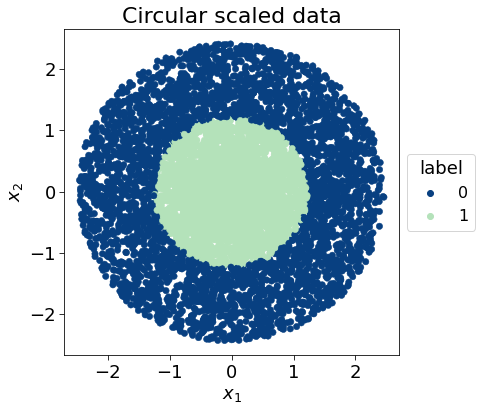

In [ ]:
# number of data
N = 8000
# box dim
B = 100

x, y = create_data.create_data(N, B, c='rad')
# re-scaling data 
mean = np.mean(x, axis=0)
std = np.std(x, axis=0)
x_scaled = preprocess.standardize(x, mean, std)

# plotting data
fig = plt.figure( figsize=(6,6) )
ax  = plot_utils.plot_labeled_data( x_scaled, y,
                                    fig, title='Circular scaled data',
                                    palette='GnBu_r', hue_norm=(0,1.5))
plt.show()

#### 4.1.b) Dividing data
Here we divide data in test, validation and training sets such that they are disjoint sets

In [ ]:
train_frac = 0.7                   # fraction of original data used for training and validation (other for test)
valid_frac = 0.3                   # fraction of previous data used for validation (other for training)

N_train = int(N*train_frac)
N_valid = int(N_train*valid_frac)
circ_test  = (np.copy(x_scaled[N_train:]),       np.copy(y[N_train:]))
circ_train = (np.copy(x_scaled[N_valid:N_train]),np.copy(y[N_valid:N_train]))
circ_valid = (np.copy(x_scaled[0:N_valid]),      np.copy(y[0:N_valid]))

print(f"\nN_train :\t{circ_train[0].shape[0]} \nN_valid :\t{circ_valid[0].shape[0]} \
        \nN_test  :\t{circ_test[0].shape[0]}")


N_train :	3920 
N_valid :	1680         
N_test  :	2400


#### 4.1.c) Training best DNN
Now we train the best model paying attention to the dimensionality of the input

In [ ]:
print(networks[0].summary())
fit1 = networks[0].fit(
       circ_train[0], circ_train[1],
       epochs          = N_epochs,
       batch_size      = minibatch,
       validation_data = circ_valid,
       verbose         = 0 )

Model: "circular data neural network"
____________________________________________________________________________________________________
 Layer (type)                                Output Shape                            Param #        
 input_layer (InputLayer)                    [(None, 2)]                             0              
                                                                                                    
 hidden_0 (Dense)                            (None, 20)                              60             
                                                                                                    
 dropout_0 (Dropout)                         (None, 20)                              0              
                                                                                                    
 hidden_1 (Dense)                            (None, 20)                              420            
                                                     

#### 4.1.d) Results

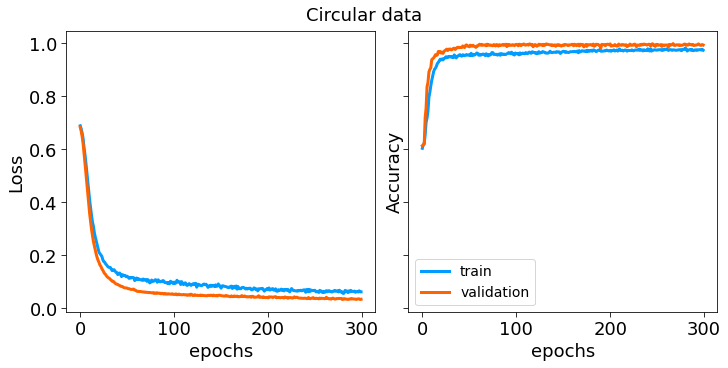

In [ ]:
fig, ax = plt.subplots( 1, 2, figsize=(10, 5), sharey=True, constrained_layout=True )
fig.suptitle( 'Circular data', fontsize=18)

# plotting loss history
plot_utils.plot_loss(
           epochs = N_epochs,
           loss   = fit1.history['loss'],
           fig    = fig,
           ax     = ax[0],
           label  = 'train',
           color  = "#009cff",
           legend = False )
plot_utils.plot_loss(
           epochs = N_epochs,
           loss   = fit1.history['val_loss'],
           fig    = fig,
           ax     = ax[0],
           label  = 'validation',
           color  = "#ff6300",
           legend = False,
           title  = None,
           loss_label = 'Loss' )

# plotting accuracy history
plot_utils.plot_metric(
           epochs = N_epochs,
           metric = fit1.history['accuracy'],
           fig    = fig,
           ax     = ax[1],
           label  = 'train',
           color  = "#009cff",
           title  = None )
plot_utils.plot_metric(
           epochs = N_epochs,
           metric = fit1.history['val_accuracy'],
           fig    = fig,
           ax     = ax[1],
           label  = 'validation',
           color  = "#ff6300",
           metric_label = 'Accuracy',
           title  = None )
    
plt.show()

In [ ]:
test = networks[0].evaluate(
    circ_test[0], circ_test[1],
    batch_size      = minibatch,
    verbose         = 0,
)

print("test loss, test accuracy:", test)

test loss, test accuracy: [0.0360894501209259, 0.9929166436195374]


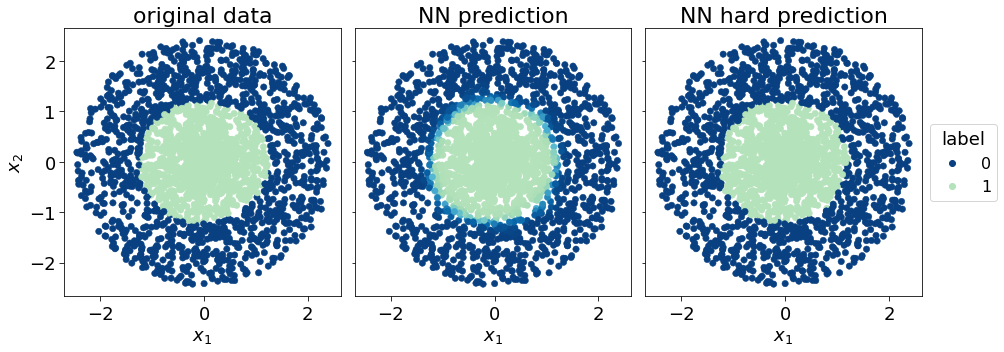

In [ ]:
plot_utils.plot_comparison(circ_test[0], circ_test[1], networks[0])
plt.show()

### 4.2) Weird data
Now we check if the NN is able to learn more complicated non linear boundaries.
#### 4.2.a) Generating data

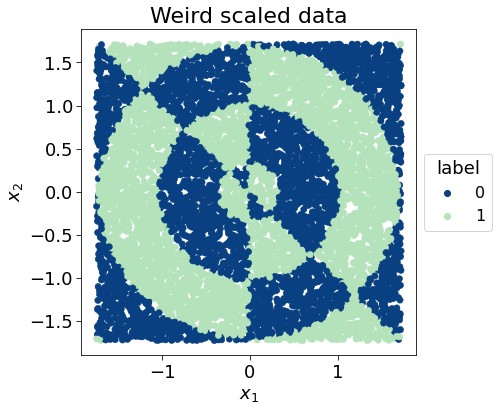

In [ ]:
x, y = create_data.create_data(N, B, c='weird')
# re-scaling data 
mean = np.mean(x, axis=0)
std = np.std(x, axis=0)
x_scaled = preprocess.standardize(x, mean, std)

# plotting data
fig = plt.figure( figsize=(6,6) )
ax  = plot_utils.plot_labeled_data( x_scaled, y,
                                    fig, title='Weird scaled data',
                                    palette='GnBu_r', hue_norm=(0,1.5))
plt.show()

#### 4.2.b) Dividing data

In [ ]:
weird_test  = (np.copy(x_scaled[N_train:]),       np.copy(y[N_train:]))
weird_train = (np.copy(x_scaled[N_valid:N_train]),np.copy(y[N_valid:N_train]))
weird_valid = (np.copy(x_scaled[0:N_valid]),      np.copy(y[0:N_valid]))

print(f"\nN_train :\t{weird_train[0].shape[0]} \nN_valid :\t{weird_valid[0].shape[0]} \
        \nN_test  :\t{weird_test[0].shape[0]}")


N_train :	3920 
N_valid :	1680         
N_test  :	2400


#### 4.2.c) Training best and not optimized DNN

In [ ]:
print(networks[1].summary())
fit2 = networks[1].fit(
       weird_train[0], weird_train[1],
       epochs          = N_epochs,
       batch_size      = minibatch,
       validation_data = weird_valid,
       verbose         = 0 )

# training not optimized DNN
print(no_network.summary())
no_fit = no_network.fit(
         weird_train[0], weird_train[1],
         epochs          = no_N_epochs,
         batch_size      = minibatch,
         validation_data = weird_valid,
         verbose         = 0 )

Model: "weird data neural network"
____________________________________________________________________________________________________
 Layer (type)                                Output Shape                            Param #        
 input_layer (InputLayer)                    [(None, 2)]                             0              
                                                                                                    
 hidden_0 (Dense)                            (None, 20)                              60             
                                                                                                    
 dropout_0 (Dropout)                         (None, 20)                              0              
                                                                                                    
 hidden_1 (Dense)                            (None, 20)                              420            
                                                        

#### 4.2.d) Results

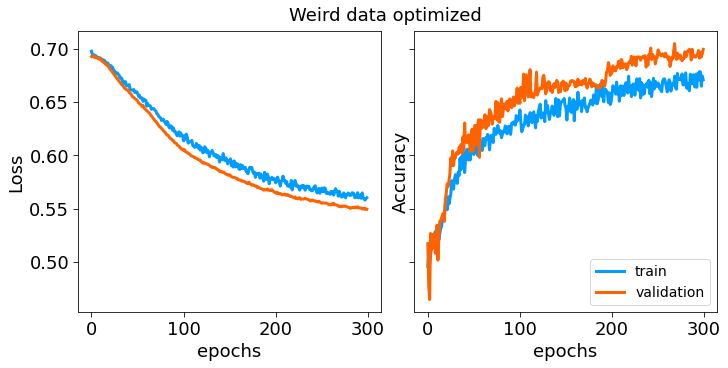

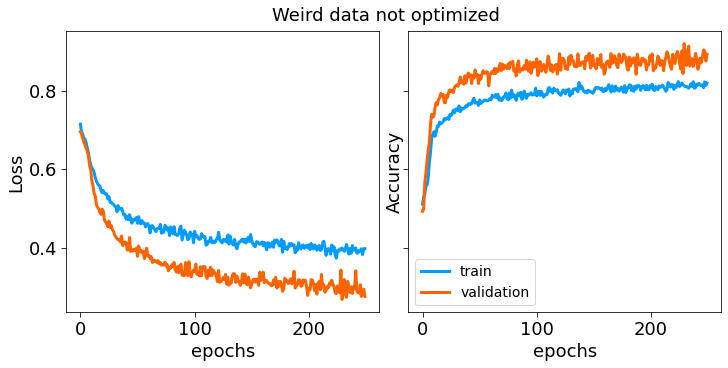

In [ ]:
# optimized network
fig, ax = plt.subplots( 1, 2, figsize=(10, 5), sharey=True, constrained_layout=True )
fig.suptitle( 'Weird data optimized', x=0.53, fontsize=18)

# plotting loss history
plot_utils.plot_loss(
           epochs = N_epochs,
           loss   = fit2.history['loss'],
           fig    = fig,
           ax     = ax[0],
           label  = 'train',
           color  = "#009cff",
           legend = False )
plot_utils.plot_loss(
           epochs = N_epochs,
           loss   = fit2.history['val_loss'],
           fig    = fig,
           ax     = ax[0],
           label  = 'validation',
           color  = "#ff6300",
           legend = False,
           title  = None,
           loss_label = 'Loss' )

# plotting accuracy history
plot_utils.plot_metric(
           epochs = N_epochs,
           metric = fit2.history['accuracy'],
           fig    = fig,
           ax     = ax[1],
           label  = 'train',
           color  = "#009cff",
           title  = None )
plot_utils.plot_metric(
           epochs = N_epochs,
           metric = fit2.history['val_accuracy'],
           fig    = fig,
           ax     = ax[1],
           label  = 'validation',
           color  = "#ff6300",
           metric_label = 'Accuracy',
           title  = None )
    
plt.show()


# not optimized network
fig, ax = plt.subplots( 1, 2, figsize=(10, 5), sharey=True, constrained_layout=True )
fig.suptitle( 'Weird data not optimized', x=0.53, fontsize=18)

# plotting loss history
plot_utils.plot_loss(
           epochs = no_N_epochs,
           loss   = no_fit.history['loss'],
           fig    = fig,
           ax     = ax[0],
           label  = 'train',
           color  = "#009cff",
           legend = False )
plot_utils.plot_loss(
           epochs = no_N_epochs,
           loss   = no_fit.history['val_loss'],
           fig    = fig,
           ax     = ax[0],
           label  = 'validation',
           color  = "#ff6300",
           legend = False,
           title  = None,
           loss_label = 'Loss' )

# plotting accuracy history
plot_utils.plot_metric(
           epochs = no_N_epochs,
           metric = no_fit.history['accuracy'],
           fig    = fig,
           ax     = ax[1],
           label  = 'train',
           color  = "#009cff",
           title  = None )
plot_utils.plot_metric(
           epochs = no_N_epochs,
           metric = no_fit.history['val_accuracy'],
           fig    = fig,
           ax     = ax[1],
           label  = 'validation',
           color  = "#ff6300",
           metric_label = 'Accuracy',
           title  = None )
    
plt.show()

In [ ]:
test = networks[1].evaluate(
    weird_test[0], weird_test[1],
    batch_size      = minibatch,
    verbose         = 0
)

no_test = no_network.evaluate(
    weird_test[0], weird_test[1],
    batch_size      = minibatch,
    verbose         = 0
)

print("optimized test loss, test accuracy:", test)
print("not optimized test loss, test accuracy:", no_test)

optimized test loss, test accuracy: [0.5408129692077637, 0.6974999904632568]
not optimized test loss, test accuracy: [0.2911299765110016, 0.8654166460037231]


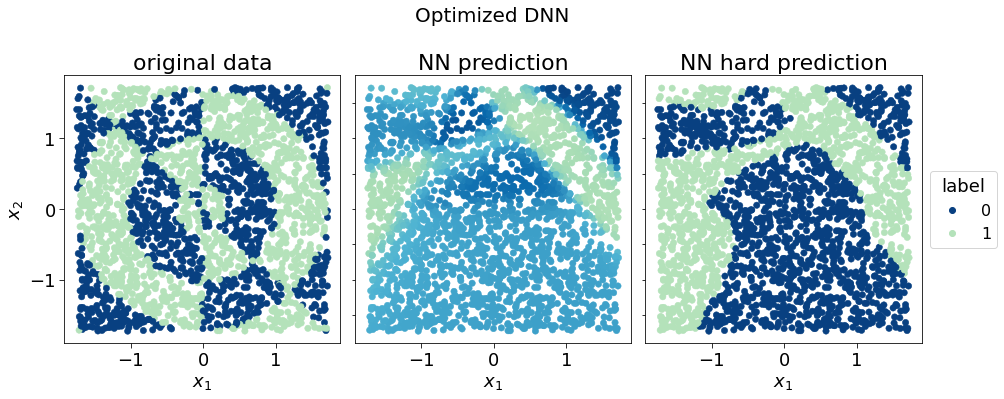

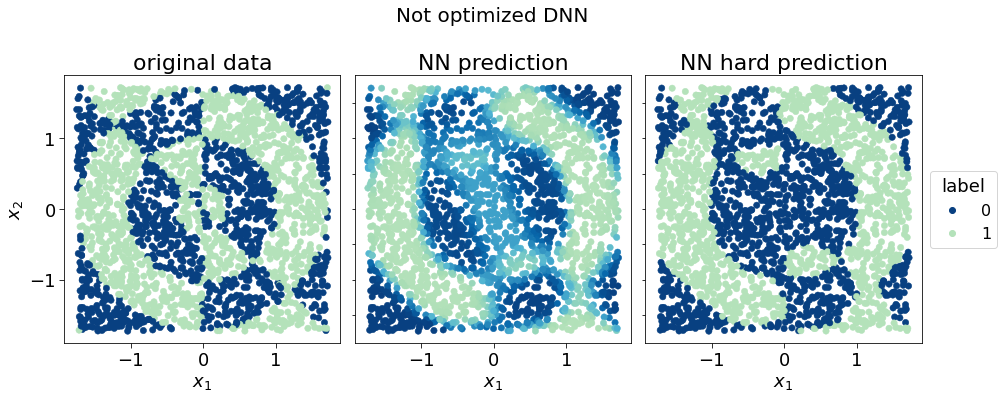

In [ ]:
fig = plot_utils.plot_comparison(weird_test[0], weird_test[1], networks[1])
fig.suptitle('Optimized DNN', x=0.53, y=1.1, fontsize = 20)
plt.show()

no_fig = plot_utils.plot_comparison(weird_test[0], weird_test[1], no_network)
no_fig.suptitle('Not optimized DNN', x=0.53, y=1.1, fontsize = 20)
plt.show()

### 4.3) 3to20D circular data
In this section we investigate the performances of the NN on data with a simple boundary but increasing feature space dimension.
#### 4.3.a) Generating data

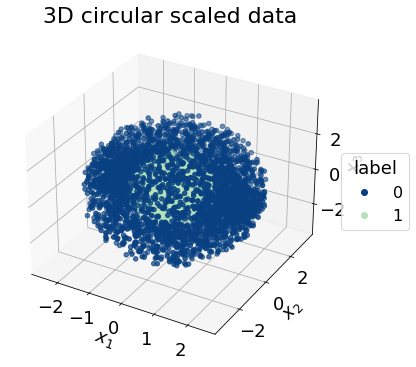

In [ ]:
data_list = []

for i in input_dims[2:]:
    x, y = create_data.create_data(N, B, c='radNd', dim=i)
    # re-scaling data 
    mean = np.mean(x, axis=0)
    std = np.std(x, axis=0)
    x_scaled = preprocess.standardize(x, mean, std)
    data_list.append((x_scaled, y))

# plotting data
fig = plt.figure( figsize=(6,6) )
ax  = plot_utils.plot_labeled_data( data_list[0][0], data_list[0][1],
                                    fig, title='3D circular scaled data',
                                    palette='GnBu_r', hue_norm=(0,1.5))
plt.show()

#### 4.3.b) Dividing data

In [ ]:
test_list  = []
valid_list = []
train_list = []

for x, y in data_list:
    test_list.append((np.copy(x[N_train:]),  np.copy(y[N_train:])))
    train_list.append((np.copy(x[N_valid:N_train]),  np.copy(y[N_valid:N_train])))
    valid_list.append((np.copy(x[0:N_valid]), np.copy(y[0:N_valid])))

print(f"\nN_train :\t{train_list[0][0].shape[0]} \nN_valid :\t{valid_list[0][0].shape[0]} \
        \nN_test  :\t{test_list[0][0].shape[0]}")


N_train :	3920 
N_valid :	1680         
N_test  :	2400


#### 4.3.c) Training best DNN

In [ ]:
fit_list = [ networks[i+2].fit(
             train_list[i][0], train_list[i][1],
             epochs          = N_epochs,
             batch_size      = minibatch,
             validation_data = (valid_list[i][0], valid_list[i][1]),
             verbose         = 0,
            ) for i in range(len(input_dims)-2) ]

#### 4.3.d) Results

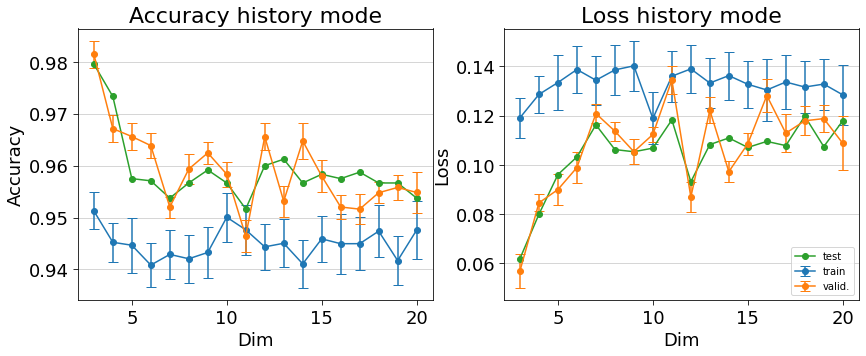

In [ ]:
test_array = np.asarray([networks[i+2].evaluate(
                         test_list[i][0], test_list[i][1],
                         batch_size      = minibatch,
                         verbose         = 0) for i in range(len(input_dims)-2)])

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14,5))
ax[0].set_axisbelow(True); ax[1].set_axisbelow(True)
ax[0].grid(axis="y", color="k", alpha=0.2); ax[1].grid(axis="y", color="k", alpha=0.2)

ax[0].set_title('Accuracy history mode', fontsize=22)
ax[0].set_xlabel('Dim', fontsize=18)
ax[0].set_ylabel("Accuracy", fontsize=18)
ax[0].tick_params(axis="both", which="major", labelsize=18, length=5)

ax[0].errorbar(input_dims[2:],[plot_utils.history_mode(fit_list[i].history['accuracy']) for i in range(len(fit_list))], 
               yerr=[np.asarray(fit_list[i].history['accuracy'])[-201:-1].std() for i in range(len(fit_list))],
               capsize=5, marker='o', label="train")
ax[0].errorbar(input_dims[2:],[plot_utils.history_mode(fit_list[i].history['val_accuracy']) for i in range(len(fit_list))], 
               yerr=[np.asarray(fit_list[i].history['val_accuracy'])[-201:-1].std() for i in range(len(fit_list))],
               capsize=5, marker='o', label="valid.")
ax[0].plot(input_dims[2:], test_array[:,1], marker='o', label='test')


ax[1].set_title('Loss history mode', fontsize=22)
ax[1].set_xlabel('Dim', fontsize=18)
ax[1].set_ylabel("Loss", fontsize=18)
ax[1].tick_params(axis="both", which="major", labelsize=18, length=5)

ax[1].errorbar(input_dims[2:],[plot_utils.history_mode(fit_list[i].history['loss']) for i in range(len(fit_list))], 
               yerr=[np.asarray(fit_list[i].history['loss'])[-201:-1].std() for i in range(len(fit_list))],
               capsize=5, marker='o', label="train")
ax[1].errorbar(input_dims[2:],[plot_utils.history_mode(fit_list[i].history['val_loss']) for i in range(len(fit_list))], 
               yerr=[np.asarray(fit_list[i].history['val_loss'])[-201:-1].std() for i in range(len(fit_list))],
               capsize=5, marker='o',label="valid.")
ax[1].plot(input_dims[2:], test_array[:,0], marker='o', label='test')
ax[1].legend()

plt.show()

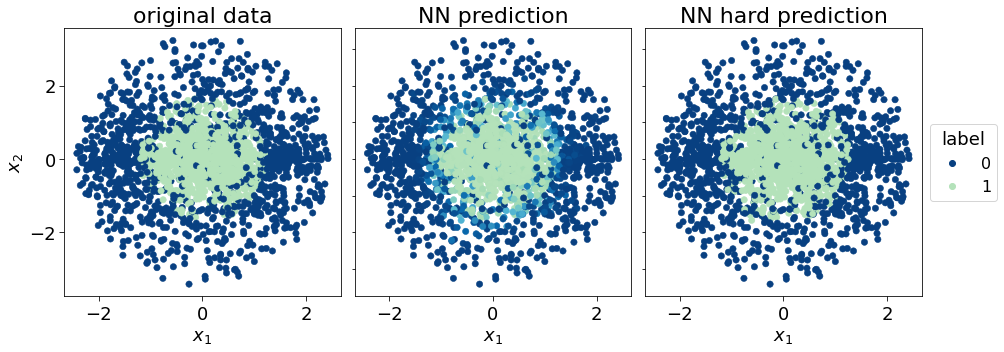

In [ ]:
plot_utils.plot_comparison( test_list[-1][0], test_list[-1][1], networks[-1])
plt.show()

### 4.4) Final plots
in this section fancier and meaningful plots are produced
#### 4.4.a) $f_3$ labeled data 

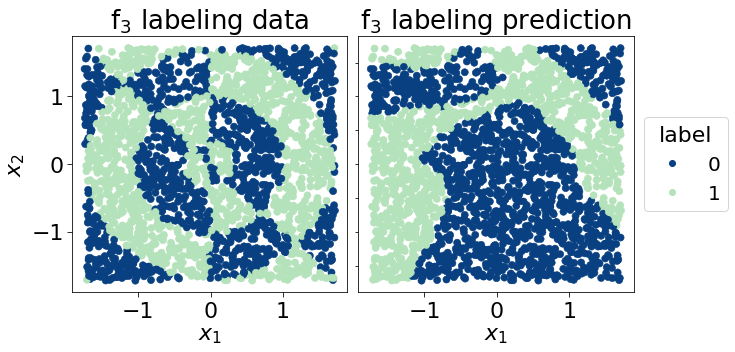

In [ ]:
# plot comparison between original labels and predicted ones

pred = networks[1].predict(weird_test[0]).reshape((-1,))
pred_binary = pred.copy()
pred_binary[pred <= 0.5] = 0
pred_binary[pred >  0.5] = 1

fig = plt.figure(figsize=(9,5))

plot_utils.plot_labeled_data(
    weird_test[0], 
    weird_test[1], 
    fig, 
    subplot_id      = 121, 
    title           = "f$_3$ labeling data", 
    legend          = False,
    palette         = 'GnBu_r',
    hue_norm        = (0, 1.5),
    fontsize        = 22,
    msize           = 50,
)

ax, lgn = plot_utils.plot_labeled_data(
    weird_test[0],
    pred_binary,
    fig,
    subplot_id    = 122,
    title         = "f$_3$ labeling prediction",
    legend        = True,
    palette       = 'GnBu_r',
    hue_norm      = (0, 1.5),
    show_ylbl     = False,
    return_lgn    = True,
    fontsize      = 22,
    msize         = 50,
)


fig.savefig('plots/weird_comparison.pdf', bbox_extra_artists=(lgn,), bbox_inches='tight')

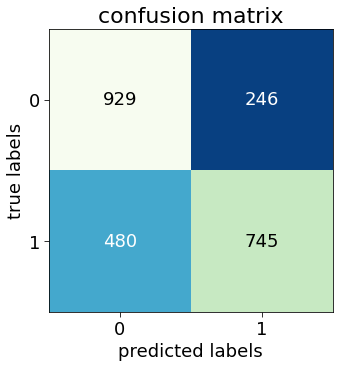

In [ ]:
# plot confusion matrix

cm = confusion_matrix( weird_test[1], pred_binary)
fig, ax = plt.subplots(1, 1, figsize=(5,5), constrained_layout=True)

plot_utils.plot_confusion_matrix(
    cm,
    ax,
    cmap     = "GnBu_r",
    labels   = [0, 1],
    fontsize = 18,
    title    = 'confusion matrix',
)

fig.savefig('plots/weird_cm.pdf')

#### 4.4.b) 3to20D history mode 

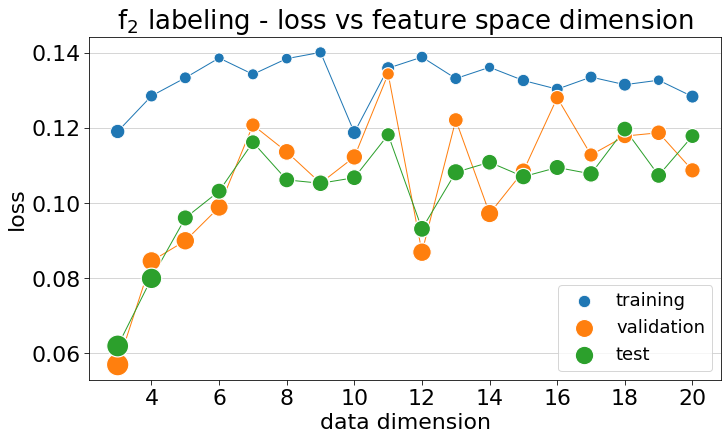

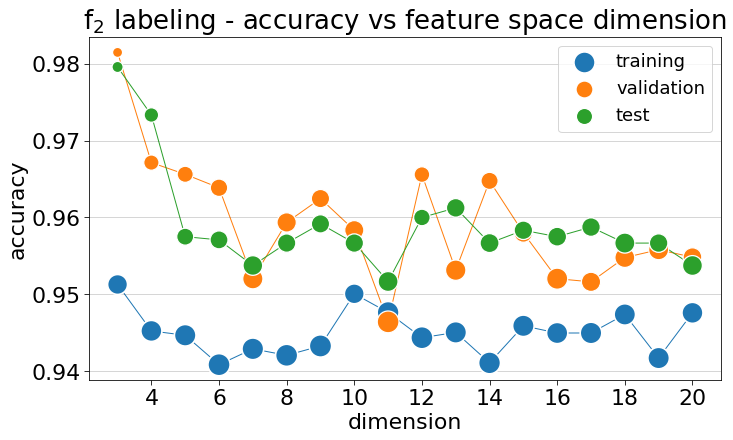

In [ ]:
loss_mode_ls     = [plot_utils.history_mode(fit_list[i].history['loss']) for i in range(len(fit_list))]
val_loss_mode_ls = [plot_utils.history_mode(fit_list[i].history['val_loss']) for i in range(len(fit_list))]
acc_mode_ls      = [plot_utils.history_mode(fit_list[i].history['accuracy']) for i in range(len(fit_list))]
val_acc_mode_ls  = [plot_utils.history_mode(fit_list[i].history['val_accuracy']) for i in range(len(fit_list))]


loss_max = max(
    loss_mode_ls     +
    val_loss_mode_ls +
    test_array[:,0].tolist() 
)
loss_min = min(
    loss_mode_ls     +
    val_loss_mode_ls +
    test_array[:,0].tolist() 
)
acc_max  = max(
    acc_mode_ls     +
    val_acc_mode_ls +
    test_array[:,1].tolist()
)
acc_min  = min(
    acc_mode_ls     +
    val_acc_mode_ls +
    test_array[:,1].tolist()
)

loss_norm = (loss_min, loss_max)
acc_norm  = (acc_min,  acc_max)

fontsize = 22

fig1, ax = plt.subplots(figsize=(10,6), constrained_layout=True)
ax.set_axisbelow(True)
ax.grid(axis="y", color="k", alpha=0.2)

ax = plot_utils.scatter_results(
    parameter    = input_dims[2:],
    result       = loss_mode_ls,
    fig          = fig, 
    ax           = ax,
    label        = "training",
    metric_label = "loss",
    par_label    = "data dimension",
    color        = "tab:blue",
    fontsize     = fontsize,
    ms           = acc_mode_ls,
    mnorm        = acc_norm,
    legend       = True,
    title        = "Loss function comparison"
)

ax = plot_utils.scatter_results(
    parameter    = input_dims[2:],
    result       = val_loss_mode_ls,
    fig          = fig, 
    ax           = ax,
    label        = "validation",
    metric_label = "loss",
    par_label    = "data dimension",
    color        = "tab:orange",
    fontsize     = fontsize,
    ms           = val_acc_mode_ls,
    mnorm        = acc_norm,
    legend       = True,
    title        = "Loss function comparison"
)

ax = plot_utils.scatter_results(
    parameter    = input_dims[2:],
    result       = test_array[:,0],
    fig          = fig, 
    ax           = ax,
    label        = "test",
    metric_label = "loss",
    par_label    = "data dimension",
    color        = "tab:green",
    fontsize     = fontsize,
    ms           = test_array[:,1],
    mnorm        = acc_norm,
    legend       = True,
    title        = "f$_2$ labeling - loss vs feature space dimension"
)

ax.set_yscale("linear")
ax.set_xticks(input_dims[3::2])

plt.show()


fig2, ax = plt.subplots(figsize=(10,6), constrained_layout=True)
ax.set_axisbelow(True)
ax.grid(axis="y", color="k", alpha=0.2)


ax = plot_utils.scatter_results(
    parameter    = input_dims[2:],
    result       = acc_mode_ls,
    fig          = fig, 
    ax           = ax,
    label        = "training",
    metric_label = "accuracy",
    par_label    = "data dimension",
    color        = "tab:blue",
    fontsize     = fontsize,
    ms           = loss_mode_ls,
    mnorm        = loss_norm,
    legend       = True,
    title        = "Accuracy comparison"
)

ax = plot_utils.scatter_results(
    parameter    = input_dims[2:],
    result       = val_acc_mode_ls,
    fig          = fig, 
    ax           = ax,
    label        = "validation",
    metric_label = "accuracy",
    par_label    = "data dimension",
    color        = "tab:orange",
    fontsize     = fontsize,
    ms           = val_loss_mode_ls,
    mnorm        = loss_norm,
    legend       = True,
    title        = "Accuracy comparison"
)

ax = plot_utils.scatter_results(
    parameter    = input_dims[2:],
    result       = test_array[:,1],
    fig          = fig, 
    ax           = ax,
    label        = "test",
    metric_label = "accuracy",
    par_label    = "dimension",
    color        = "tab:green",
    fontsize     = fontsize,
    ms           = test_array[:,0],
    mnorm        = loss_norm,
    legend       = True,
    title        = "f$_2$ labeling - accuracy vs feature space dimension"
)

ax.set_yscale("linear")
ax.set_xticks(input_dims[3::2])

plt.show()

fig1.savefig('plots/3to20D_losshistory.pdf')
fig2.savefig('plots/3to20D_acchistory.pdf')

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=452e6836-b7b8-455e-80d9-d4109b6baddf' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>